## Applying classifiers to make drug predictions

Here we apply embeddings generated in the NB:
`Graph embedding using SkipGram 20201001 homogeneous graph training.ipynb`
md5 hash: 261f9f7b0137263728c292a1a878d7baf3f875f3

that were used to generate link classifiers in this NB:
`Link prediction 20201001 homogeneous graph.ipynb`
md5 hash 3a13cb16b3db2a53917f7d25e16313b0fb3d411d

kg-covid-19:
version 20201001

ensmallen-graph
Version: 0.4.4 # upgraded from 0.4.3 for an update vers that has get_edge_id() and a few other methods. Otherwise 0.4.3 and 0.4.4 should be the same

embiggen
Version: 0.6.0

In [1]:
import os

w2v = "SkipGram"
exp_name = "80_20_kg_covid_19_20201001_training_test_epoch_500_delta_0.0001"
s3_path = "s3://kg-hub-public-data/embeddings/20201001/"  # keep trailing slash

base_dl_dir = "downloaded_data"
graph_data_dir = os.path.join(base_dl_dir, "kg-covid-19-20201001")
embedding_data_dir = os.path.join(base_dl_dir, "embeddings-20201001")
classifier_data_dir = os.path.join(base_dl_dir, "classifiers-20201001")

# graph stuff
graph_out_file = os.path.join(graph_data_dir + "/kg-covid-19.tar.gz")
nodes_file = os.path.join(graph_data_dir, "merged-kg_nodes.tsv")
edges_file = os.path.join(graph_data_dir, "merged-kg_edges.tsv")
sorted_edges_file = os.path.join(graph_data_dir, "merged-kg_edges_SORTED.tsv")
graph_tar_url = "https://kg-hub.berkeleybop.io/kg-covid-19/20201001/kg-covid-19.tar.gz"

# embeddings URLs
base_kghub_url = "http://kg-hub.berkeleybop.io/"
embeddings_url = os.path.join(base_kghub_url, "embeddings/20201001/SkipGram_80_20_kg_covid_19_20201001_training_test_epoch_500_delta_0.0001_embedding.npy")
embedding_file = os.path.join(embedding_data_dir, "SkipGram_embedding.npy")

# classifier URLs
classifier_base_url = "http://kg-hub.berkeleybop.io/embeddings/20201001/SkipGram_80_20_kg_covid_19_20201001_training_test_epoch_500_delta_0.0001_"
classifier_edge_models_to_use = 'average'
classifier_edge_models = ['average', 'hadamard', 'weightedL1', 'weightedL2']
classifier_suffix = '_finalized_model.h5'
classifier_urls = [f"{classifier_base_url}{m}{classifier_suffix}" for m in classifier_edge_models]
classifier_files = [f"{classifier_data_dir}/{w2v}_{exp_name}{m}{classifier_suffix}" for m in classifier_edge_models]

# params
seed = 42
train_percentage = 0.8
patience = 5

In [2]:
from pkg_resources import get_distribution
assert(get_distribution("ensmallen-graph").version == '0.4.4')  # upgraded from 0.4.3 for an update vers that has get_edge_id() and other methods
assert(get_distribution("embiggen").version == '0.6.0')

In [3]:
import silence_tensorflow.auto # Import needed to avoid TensorFlow warnings and general useless infos.

## Retrieve and load graph

In [4]:
# get the graphs, if necessary

import urllib
import os
os.makedirs(graph_data_dir, exist_ok=True)

if not os.path.exists(nodes_file) or not os.path.exists(edges_file):
    with urllib.request.urlopen(graph_tar_url) as response, \
        open(graph_out_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)
    os.system("tar -xvzf " + graph_out_file + " -C " + graph_data_dir)

In [5]:
%%time
from ensmallen_graph import EnsmallenGraph

if not os.path.exists(sorted_edges_file):
    graph = EnsmallenGraph.from_unsorted_csv(
        edge_path = edges_file,
        sources_column="subject",
        destinations_column="object",
        directed=False,
        node_path = nodes_file,
        nodes_column = 'id',
        node_types_column = 'category',
        default_node_type = 'biolink:NamedThing'
    )

    graph.dump_edges(sorted_edges_file,
        sources_column="subject",
        destinations_column="object")

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.6 ms


In [7]:
from ensmallen_graph import EnsmallenGraph
 
graph = EnsmallenGraph.from_sorted_csv(
    edge_path = sorted_edges_file,
    sources_column="subject",
    destinations_column="object",
    directed=False,
    nodes_number=377577,  # should be = or > than actual number
    edges_number=30949369,   # same ^
    node_path = nodes_file,
    nodes_column = 'id',
    node_types_column = 'category',
    default_node_type = 'biolink:NamedThing'
)

graph.report()

{'edges_number': '30949369',
 'nodes_number': '377577',
 'directed': 'false',
 'has_weights': 'false',
 'self_loops_rate': '0.00001554151233261008',
 'singletons': '8314',
 'density': '0.037284237441157525',
 'unique_node_types_number': '37',
 'unique_edge_types_number': '0',
 'has_edge_types': 'false',
 'has_node_types': 'true',
 'self_loops_number': '481',
 'degree_mean': '81.96836406878597'}

## Make same holdouts as before

In [8]:
%%time
pos_training, pos_validation = graph.connected_holdout(train_percentage, seed=seed)

CPU times: user 2min 41s, sys: 1.03 s, total: 2min 42s
Wall time: 2min 40s


The followings are check that are not necessary, but are offered as sanity checks:

In [9]:
%%time
coherence_check=True
if coherence_check:
    assert graph.contains(pos_training)
    assert graph.contains(pos_validation)
    assert (pos_training | pos_validation).contains(graph)
    assert graph.contains(pos_training | pos_validation)
    assert not pos_training.overlaps(pos_validation)
    assert not pos_validation.overlaps(pos_training)

CPU times: user 21min 26s, sys: 2.28 s, total: 21min 29s
Wall time: 3min 40s


## Loading the embeddings

In [10]:
os.makedirs(embedding_data_dir, exist_ok=True)

if not os.path.exists(embedding_file):
    with urllib.request.urlopen(embeddings_url) as response, \
        open(embedding_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

In [11]:
import numpy as np
embeddings = np.load(embedding_file)

#### More coherence checks

In [12]:
assert len(pos_training.get_nodes_reverse_mapping()) == len(embeddings)
assert len(pos_training.get_node_types()) == len(embeddings)

In [13]:
node_curies = list(np.array(pos_training.get_nodes_reverse_mapping()))

In [14]:
sars_cov_2_curie = 'CHEMBL.TARGET:CHEMBL4303835'
sars_cov_2_idx = node_curies.index(sars_cov_2_curie)

In [15]:
drug_idx = list(np.where(pos_training.get_node_types() == pos_training.get_node_types_reverse_mapping().index('biolink:Drug'))[0])
drug_names = [node_curies[i] for i in drug_idx]

In [16]:
chem_substance_idx = list(np.where(pos_training.get_node_types() == pos_training.get_node_types_reverse_mapping().index('biolink:ChemicalSubstance'))[0])
chem_substance_names = [node_curies[i] for i in chem_substance_idx]

In [17]:
import re
chembl_prefix = 'CHEMBL.COMPOUND'
chembl_names = [x for x in node_curies if (match := re.compile(chembl_prefix).search(x))]
chembl_idx = [index for index, x in enumerate(node_curies) if (match := re.compile(chembl_prefix).search(x))]

## Loading trained MLP models

In [18]:
from tqdm.auto import tqdm
os.makedirs(classifier_data_dir, exist_ok=True)

for i, url in tqdm(enumerate(classifier_urls)):
    with urllib.request.urlopen(url) as response, \
        open(os.path.join(classifier_files[i]), 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

In [19]:
import tensorflow as tf
mlp_model = (classifier_edge_models_to_use, 
             tf.keras.models.load_model(
                 classifier_files[classifier_edge_models.index(classifier_edge_models_to_use)]
             ))

In [20]:
sars_cov_2_emb = embeddings[sars_cov_2_idx]

In [85]:
print(f"using %s model for edge embeddings" % mlp_model[0])

using average model for edge embeddings


In [21]:
from embiggen import GraphTransformer, EdgeTransformer

assert(mlp_model[0] in EdgeTransformer.methods)

transformer = GraphTransformer(mlp_model[0]) # pass edge embedding method, which is mlp_model[0]
transformer.fit(embeddings)
train_edges = transformer.transform(pos_training)
assert(pos_training.get_edges_number() == len(train_edges))

In [28]:
# let's try to predict a link that should exist in training graph
# example SARS-CoV-2 -> ChEMBL compound edge (which should bge positive)
example_chembl_edge = train_edges[pos_training.get_edge_id(sars_cov_2_idx, chembl_idx[0])]
example_chembl_edge.shape
example_chembl_edge.__class__
mlp_model[1].predict(example_chembl_edge.reshape(1, -1))

array([[0.960194]], dtype=float32)

In [35]:
# prepare source (drugs) and destination (SARS-CoV-2) numpy arrays
import logging
import numpy as np
drug_idx_wo_exist_links = []
for drug_id in drug_idx:
    if not pos_training.has_edge(drug_id, sars_cov_2_idx) and not pos_training.has_edge(sars_cov_2_idx, drug_id):
        drug_idx_wo_exist_links.append(drug_id)
    else:
        logging.warning("Not using edge %s %s which was present in training graph" % (drug_id, sars_cov_2_idx))
drug_idx_wo_exist_links = np.asarray(drug_idx_wo_exist_links)
sars_cov_2_dest = np.repeat(sars_cov_2_idx, len(drug_idx_wo_exist_links))

In [36]:
# Make an edge transformer for drug -> SARS-CoV-2 edge for every member of drug_idx

from embiggen import GraphTransformer, EdgeTransformer
assert(mlp_model[0] in EdgeTransformer.methods)

edge_transformer = EdgeTransformer(mlp_model[0]) # pass edge embedding method, which is mlp_model[0]
assert(drug_idx_wo_exist_links.shape == sars_cov_2_dest.shape)
edge_transformer.fit(embeddings)
drug_edges = edge_transformer.transform(sources=drug_idx_wo_exist_links, destinations=sars_cov_2_dest)
assert(len(drug_idx_wo_exist_links) == len(drug_edges))

drug_prediction_pval = mlp_model[1].predict(drug_edges)

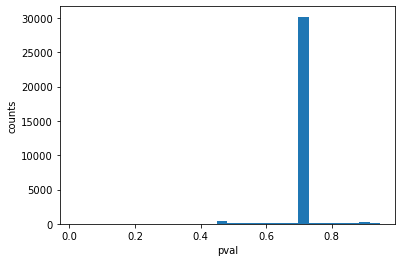

In [37]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(drug_prediction_pval, density=False, bins=30)  # `density=False` would make counts
plt.ylabel('counts')
plt.xlabel('pval');

In [40]:
sort_idx = np.argsort(drug_prediction_pval, axis=0)[::-1]

with open("drug_sars_cov2_link_prediction.tsv", "w") as out:
    out.write("graph_id\tCURIE\tpval\n")
    for idx in np.nditer(sort_idx, order='F'):
        line = f"%i    %s     %f\n" % (drug_idx_wo_exist_links[idx],
                        pos_training.get_nodes_reverse_mapping()[drug_idx_wo_exist_links[idx]],
                        drug_prediction_pval[idx])
        print(line)
        out.write(line)

56464    ttd.drug:D0Y9MP     0.945995

56573    ttd.drug:D06FWY     0.941788

62878    ttd.drug:D0H9HT     0.940128

56069    ttd.drug:D0Y3TM     0.940032

49507    ttd.drug:D0E9CG     0.938412

68499    ttd.drug:D0X2GF     0.938159

66845    ttd.drug:D0MX5B     0.937725

41886    ttd.drug:D0A0RT     0.937488

53434    ttd.drug:D0H0QR     0.937358

42905    ttd.drug:D0W2UK     0.937350

45111    ttd.drug:D01ZWF     0.936848

44690    ttd.drug:D06AZC     0.936342

58509    ttd.drug:D0Q0OH     0.935356

60745    ttd.drug:D03JAL     0.935334

61774    ttd.drug:D0M0KA     0.935326

47003    ttd.drug:D0EC6Q     0.934763

61478    ttd.drug:D01WXZ     0.934428

62861    ttd.drug:D04OTF     0.934078

44863    ttd.drug:D06GJP     0.933899

66437    ttd.drug:D01RPM     0.933406

63653    ttd.drug:D09RGM     0.932701

48157    ttd.drug:D0B8DR     0.932652

54426    ttd.drug:D08YGY     0.932397

42941    ttd.drug:D03EUD     0.932301

53379    ttd.drug:D0I1RG     0.932095

47089    ttd.drug:D08SLS 

53949    ttd.drug:D03JQL     0.905877

51586    ttd.drug:D0HM1V     0.905837

46338    ttd.drug:D02PWM     0.905768

43368    ttd.drug:D04RCT     0.905608

40994    ttd.drug:D0AL8T     0.905573

65715    ttd.drug:D08JVS     0.905314

43867    ttd.drug:D0F8LS     0.905096

56549    ttd.drug:D01WXA     0.905094

60623    ttd.drug:D0DS7W     0.904901

47154    ttd.drug:D0C1ZQ     0.904885

67265    ttd.drug:D0T7VN     0.904850

58763    ttd.drug:D0YV1Q     0.904421

48218    ttd.drug:D01AAI     0.904363

39449    PHARMGKB:PA166182756     0.904329

43474    ttd.drug:D0Z7NC     0.904182

55046    ttd.drug:D0D4QL     0.904073

45989    ttd.drug:D0F3NH     0.904061

57528    ttd.drug:D0MY0R     0.903782

37321    DrugCentral:770     0.903781

55773    ttd.drug:D06PVN     0.903733

50337    ttd.drug:D09FTJ     0.903523

45199    ttd.drug:D06LUX     0.903384

64330    ttd.drug:D0G9BP     0.903293

58406    ttd.drug:D07NWZ     0.903268

63236    ttd.drug:D09JXO     0.903024

261265    CHEBI:1562

42849    ttd.drug:D05TYI     0.854521

57196    ttd.drug:D0OA1P     0.853531

61342    ttd.drug:D0W2QN     0.852742

59399    ttd.drug:D0F5EI     0.852384

37708    DrugCentral:1423     0.851376

67500    ttd.drug:D0S5BD     0.850247

42520    ttd.drug:D06BYR     0.850084

50200    ttd.drug:D00CGJ     0.848977

41603    ttd.drug:D08TBP     0.848182

61559    ttd.drug:D0MZ8D     0.847893

64969    ttd.drug:D08TQK     0.847842

53741    ttd.drug:D03TOK     0.846579

45878    ttd.drug:D0X9QV     0.846540

38488    DrugCentral:2994     0.845290

47313    ttd.drug:D07GUX     0.844315

53356    ttd.drug:D01WWC     0.844185

65940    ttd.drug:D05NMK     0.844150

67008    ttd.drug:D0T6SP     0.842292

66542    ttd.drug:D0X4CI     0.842267

56242    ttd.drug:D03NUN     0.841999

45664    ttd.drug:D0Y8UV     0.841692

41646    ttd.drug:D05JAJ     0.841439

69521    ttd.drug:D0K5EP     0.841018

47776    ttd.drug:D00GIK     0.839493

59978    ttd.drug:D06KWA     0.839448

69178    ttd.drug:D00KE

46611    ttd.drug:D0O1BN     0.752284

43737    ttd.drug:D0U0XD     0.751853

63493    ttd.drug:D0H8AI     0.751111

52326    ttd.drug:D05GBE     0.750201

42819    ttd.drug:D05HYJ     0.749859

50883    ttd.drug:D0E6GH     0.748778

41193    ttd.drug:D07NYQ     0.748319

37977    DrugCentral:1932     0.748088

56275    ttd.drug:D0Y1MJ     0.747755

68182    ttd.drug:D0B2EL     0.747586

48365    ttd.drug:D0O6JE     0.747537

60127    ttd.drug:D0LJ8J     0.747093

59501    ttd.drug:D0V5WW     0.746452

41562    ttd.drug:D0M5FF     0.746105

50349    ttd.drug:D0FY4L     0.746000

65404    ttd.drug:D0V4TV     0.745859

47820    ttd.drug:D0O8PQ     0.745640

49688    ttd.drug:D0H4AD     0.745483

56625    ttd.drug:D0Z5LZ     0.744479

60698    ttd.drug:D0Q8HM     0.744299

65706    ttd.drug:D0ZV0R     0.744213

44758    ttd.drug:D0O5WD     0.743431

49466    ttd.drug:D00VKV     0.743338

53946    ttd.drug:D0YY4R     0.742296

44351    ttd.drug:D09JLI     0.742177

47102    ttd.drug:D0S3WR

37795    DrugCentral:1599     0.711301

62495    ttd.drug:D01BZH     0.711293

46405    ttd.drug:D0V5BX     0.711293

62291    ttd.drug:D0M9RQ     0.711292

57426    ttd.drug:D0VA2O     0.711279

41189    ttd.drug:D0F2ME     0.711278

66247    ttd.drug:D0W7AB     0.711277

55300    ttd.drug:D03HPW     0.711276

47530    ttd.drug:D09GJI     0.711274

57175    ttd.drug:D0A0YI     0.711269

57920    ttd.drug:D03NMB     0.711268

46959    ttd.drug:D00PWQ     0.711267

57423    ttd.drug:D0J3NS     0.711267

48285    ttd.drug:D0P0LG     0.711267

45304    ttd.drug:D0P1KV     0.711266

52166    ttd.drug:D03ELL     0.711264

39451    PHARMGKB:PA166114316     0.711254

56049    ttd.drug:D00YAZ     0.711254

42596    ttd.drug:D05FFB     0.711253

45462    ttd.drug:D0Q8SO     0.711248

40549    DRUGBANK:DB00580     0.711224

59194    ttd.drug:D0G6DH     0.711221

55520    ttd.drug:D0Z0MG     0.711218

38342    DrugCentral:2635     0.711217

51335    ttd.drug:D08HPL     0.711211

55096    ttd.drug

55655    ttd.drug:D08HTF     0.710797

50870    ttd.drug:D0Z9YE     0.710794

40010    PHARMGKB:PA452249     0.710794

46766    ttd.drug:D06EQN     0.710791

66873    ttd.drug:D0I4NL     0.710790

45648    ttd.drug:D01TBJ     0.710790

68014    ttd.drug:D07RTQ     0.710790

42232    ttd.drug:D09JAB     0.710789

54772    ttd.drug:D0H3NA     0.710786

58279    ttd.drug:D06TNG     0.710782

50717    ttd.drug:D0ST5P     0.710781

49527    ttd.drug:D0Z5SM     0.710778

44239    ttd.drug:D0M9TG     0.710777

48181    ttd.drug:D0Z3IZ     0.710773

51199    ttd.drug:D06MGI     0.710773

66940    ttd.drug:D0IA7Z     0.710771

58377    ttd.drug:D02HWL     0.710770

43696    ttd.drug:D03XDN     0.710769

62664    ttd.drug:D0I5UY     0.710767

45811    ttd.drug:D00BPE     0.710766

42483    ttd.drug:D04UNE     0.710766

41377    ttd.drug:D0M9FQ     0.710764

69152    ttd.drug:D0Y2WP     0.710760

39964    PHARMGKB:PA165107055     0.710759

43953    ttd.drug:D0LI0M     0.710759

41807    ttd.drug:

53415    ttd.drug:D0VU2X     0.710523

69120    ttd.drug:D0Y4RS     0.710523

50094    ttd.drug:D08GJH     0.710521

50765    ttd.drug:D08KSJ     0.710521

62042    ttd.drug:D0BH3Y     0.710521

41993    ttd.drug:D03PIB     0.710519

41680    ttd.drug:D0X1MY     0.710519

45485    ttd.drug:D0IW4Q     0.710518

39088    DrugCentral:5179     0.710515

50019    ttd.drug:D05SWY     0.710514

65228    ttd.drug:D0SV0D     0.710512

57446    ttd.drug:D0H2VW     0.710511

54868    ttd.drug:D0B5AZ     0.710510

64200    ttd.drug:D01LVE     0.710507

54241    ttd.drug:D0J4YH     0.710505

63484    ttd.drug:D0X3RW     0.710503

53237    ttd.drug:D0YA7R     0.710503

42335    ttd.drug:D09MCN     0.710501

44499    ttd.drug:D0V3MV     0.710500

63821    ttd.drug:D05MUN     0.710500

63676    ttd.drug:D0J1KG     0.710499

66182    ttd.drug:D0E9CV     0.710497

61496    ttd.drug:D02QQE     0.710497

57593    ttd.drug:D0Z2SL     0.710493

67517    ttd.drug:D0Z0KL     0.710491

58681    ttd.drug:D0WV3D

67796    ttd.drug:D01FUB     0.710325

56395    ttd.drug:D03XZT     0.710324

64190    ttd.drug:D0Y0KY     0.710324

39885    PHARMGKB:PA166169879     0.710322

68273    ttd.drug:D00NQN     0.710322

55188    ttd.drug:D04EFQ     0.710322

65830    ttd.drug:D0G8DV     0.710321

44468    ttd.drug:D0S8CE     0.710321

61721    ttd.drug:D0IW6G     0.710320

44077    ttd.drug:D07ZJS     0.710319

41063    ttd.drug:D00ENR     0.710318

60461    ttd.drug:D0ID0R     0.710318

58607    ttd.drug:D0O7NV     0.710316

42884    ttd.drug:D0DB0Z     0.710315

48685    ttd.drug:D09RVI     0.710314

59695    ttd.drug:D08QZD     0.710314

58500    ttd.drug:D0O2CH     0.710313

43001    ttd.drug:D0JB4S     0.710310

58580    ttd.drug:D05RWL     0.710309

58020    ttd.drug:D0H1HP     0.710309

56439    ttd.drug:D05QYR     0.710308

67913    ttd.drug:D00KTE     0.710308

53273    ttd.drug:D0S9RP     0.710308

60355    ttd.drug:D08KSQ     0.710308

46367    ttd.drug:D0K1OA     0.710307

69520    ttd.drug:D0

38373    DrugCentral:2708     0.710178

61566    ttd.drug:D0D4UH     0.710178

44975    ttd.drug:D00CEO     0.710177

42322    ttd.drug:D0G2WI     0.710177

64125    ttd.drug:D05YQT     0.710176

60180    ttd.drug:D0Z7LS     0.710176

53831    ttd.drug:D0E4UI     0.710176

65799    ttd.drug:D0G8FT     0.710175

42964    ttd.drug:D0CH4M     0.710175

46476    ttd.drug:D05CWM     0.710175

68459    ttd.drug:D0M6YZ     0.710175

48034    ttd.drug:D09HAM     0.710175

56027    ttd.drug:D09QBG     0.710174

55050    ttd.drug:D08FZQ     0.710173

66849    ttd.drug:D02VBF     0.710173

52382    ttd.drug:D0G8CV     0.710172

55652    ttd.drug:D02LWF     0.710171

55152    ttd.drug:D0KP0L     0.710169

41930    ttd.drug:D0GH7L     0.710168

58648    ttd.drug:D04QZD     0.710168

39060    DrugCentral:5089     0.710168

68939    ttd.drug:D0U7ZY     0.710166

57076    ttd.drug:D04VQH     0.710166

63037    ttd.drug:D0R8LB     0.710166

45209    ttd.drug:D0I6EH     0.710162

55201    ttd.drug:D0WR6

50154    ttd.drug:D0A3OF     0.710073

53274    ttd.drug:D0SG8X     0.710073

67622    ttd.drug:D0V1CW     0.710072

64251    ttd.drug:D0H3TC     0.710072

61396    ttd.drug:D0S3UH     0.710071

41119    ttd.drug:D0G3VE     0.710070

42021    ttd.drug:D0A2FM     0.710070

44728    ttd.drug:D0O4JU     0.710070

53934    ttd.drug:D0JR2C     0.710070

51939    ttd.drug:D0AU9U     0.710070

58958    ttd.drug:D0IY0R     0.710070

50164    ttd.drug:D05JIO     0.710070

58441    ttd.drug:D0E3EY     0.710069

47056    ttd.drug:D08SOF     0.710068

55572    ttd.drug:D0Q9DK     0.710067

53940    ttd.drug:D07JFY     0.710066

66775    ttd.drug:D0T9NZ     0.710066

56306    ttd.drug:D08NZE     0.710065

68782    ttd.drug:D0H7CG     0.710064

46024    ttd.drug:D0UG1W     0.710063

47831    ttd.drug:D0D4SI     0.710063

58443    ttd.drug:D07QIT     0.710063

46351    ttd.drug:D0Z2FB     0.710063

42094    ttd.drug:D0SH2X     0.710063

68513    ttd.drug:D0O0EA     0.710063

38963    DrugCentral:4940

59804    ttd.drug:D06QJT     0.709975

67169    ttd.drug:D09YQO     0.709974

63607    ttd.drug:D05UZY     0.709974

52713    ttd.drug:D07JTD     0.709974

67312    ttd.drug:D0SU0E     0.709974

61311    ttd.drug:D0Z0GX     0.709973

64181    ttd.drug:D01CIB     0.709973

63584    ttd.drug:D09CER     0.709972

37924    DrugCentral:1827     0.709972

48373    ttd.drug:D08RBS     0.709971

56070    ttd.drug:D08OKJ     0.709971

47682    ttd.drug:D06GYO     0.709971

55727    ttd.drug:D0G6EI     0.709969

58138    ttd.drug:D0A4EA     0.709969

38863    DrugCentral:4728     0.709968

47729    ttd.drug:D05HFD     0.709968

56925    ttd.drug:D01JJO     0.709967

53447    ttd.drug:D0O6WN     0.709967

63222    ttd.drug:D0S7SE     0.709966

61169    ttd.drug:D04MYO     0.709965

60050    ttd.drug:D04SDD     0.709965

64062    ttd.drug:D07VEA     0.709964

67859    ttd.drug:D0N2TF     0.709964

42327    ttd.drug:D0XL1R     0.709964

65281    ttd.drug:D0K6DG     0.709964

56732    ttd.drug:D08KY

54646    ttd.drug:D02YIW     0.709875

65730    ttd.drug:D03LUF     0.709875

37379    DrugCentral:832     0.709875

41100    ttd.drug:D02TLZ     0.709874

39188    DrugCentral:5330     0.709874

57997    ttd.drug:D00CTS     0.709873

44552    ttd.drug:D07SOM     0.709873

43519    ttd.drug:D05GDP     0.709873

51310    ttd.drug:D0G7NE     0.709872

37240    DrugCentral:606     0.709872

59763    ttd.drug:D01JGB     0.709871

57545    ttd.drug:D0N4AH     0.709871

44488    ttd.drug:D0A2FO     0.709870

39469    PHARMGKB:PA452621     0.709870

62390    ttd.drug:D01RJV     0.709870

51205    ttd.drug:D0S6BX     0.709869

37776    DrugCentral:1569     0.709869

50805    ttd.drug:D04JHN     0.709868

51859    ttd.drug:D00BXG     0.709868

51279    ttd.drug:D07VLY     0.709868

39106    DrugCentral:5220     0.709868

49226    ttd.drug:D0L9YP     0.709867

54756    ttd.drug:D0Q7TH     0.709866

48128    ttd.drug:D0Y2RM     0.709866

65316    ttd.drug:D0R1BA     0.709866

37192    DrugCentral

37278    DrugCentral:672     0.709792

47990    ttd.drug:D01PGY     0.709792

47836    ttd.drug:D06BFB     0.709791

54050    ttd.drug:D0S7VI     0.709791

44843    ttd.drug:D05RTH     0.709791

38235    DrugCentral:2423     0.709791

60326    ttd.drug:D0S5RC     0.709791

50954    ttd.drug:D0Y2MT     0.709790

68725    ttd.drug:D00DXV     0.709790

48234    ttd.drug:D0I7MX     0.709790

59769    ttd.drug:D0L9VP     0.709790

50709    ttd.drug:D0N1PA     0.709790

40535    DRUGBANK:DB01580     0.709789

63366    ttd.drug:D0M1EI     0.709789

48108    ttd.drug:D07FZA     0.709789

38314    DrugCentral:2580     0.709789

42512    ttd.drug:D08ELY     0.709789

68533    ttd.drug:D04QUO     0.709788

63124    ttd.drug:D04KIH     0.709788

52582    ttd.drug:D06OFD     0.709787

42813    ttd.drug:D0YC7C     0.709787

39513    PHARMGKB:PA166176008     0.709786

45535    ttd.drug:D0C4CG     0.709786

51937    ttd.drug:D0AK9V     0.709786

40746    ttd.drug:D0HU9H     0.709786

55650    ttd.drug

39603    PHARMGKB:PA166153449     0.709718

52720    ttd.drug:D0S1AY     0.709717

41644    ttd.drug:D0Q5VB     0.709717

43133    ttd.drug:D0Z7YS     0.709717

58113    ttd.drug:D04AQH     0.709717

62452    ttd.drug:D0RP8X     0.709716

68596    ttd.drug:D00GKE     0.709715

41728    ttd.drug:D0M7QA     0.709715

38527    DrugCentral:3219     0.709714

42135    ttd.drug:D01EGC     0.709714

51538    ttd.drug:D0YS2W     0.709714

58501    ttd.drug:D02NCW     0.709714

38887    DrugCentral:4814     0.709714

42121    ttd.drug:D0J3OD     0.709714

52009    ttd.drug:D02HWP     0.709713

55953    ttd.drug:D0B9UU     0.709713

50736    ttd.drug:D0J6SX     0.709713

59107    ttd.drug:D0R4PS     0.709713

59412    ttd.drug:D0X4CO     0.709712

64656    ttd.drug:D0H3OP     0.709712

66637    ttd.drug:D05JAH     0.709712

68040    ttd.drug:D01IRX     0.709712

38393    DrugCentral:2738     0.709712

53517    ttd.drug:D0YP0T     0.709711

69528    ttd.drug:D0FB7S     0.709711

46550    ttd.drug

57370    ttd.drug:D0PJ3M     0.709651

52126    ttd.drug:D0IT5D     0.709651

40737    ttd.drug:D06XXH     0.709650

66609    ttd.drug:D01CDK     0.709650

40752    ttd.drug:D0RT2C     0.709649

54344    ttd.drug:D04QFU     0.709649

64509    ttd.drug:D07GOR     0.709649

52269    ttd.drug:D01DAW     0.709648

66786    ttd.drug:D06CXU     0.709648

49311    ttd.drug:D0DX6L     0.709648

51789    ttd.drug:D0IM5E     0.709647

57654    ttd.drug:D0BC6Q     0.709646

56047    ttd.drug:D0N3FL     0.709645

41466    ttd.drug:D0A8BV     0.709645

57464    ttd.drug:D0KV5Z     0.709645

53418    ttd.drug:D0F4NS     0.709645

57550    ttd.drug:D0X1FT     0.709644

46350    ttd.drug:D0RJ1W     0.709643

60517    ttd.drug:D09YHQ     0.709643

65948    ttd.drug:D0R1CG     0.709643

38690    DrugCentral:4172     0.709642

50758    ttd.drug:D0A7SR     0.709641

46913    ttd.drug:D0NJ4G     0.709641

60875    ttd.drug:D0D7PF     0.709641

56161    ttd.drug:D05ERT     0.709641

65388    ttd.drug:D0C1OJ

37864    DrugCentral:1739     0.709591

37096    DrugCentral:323     0.709591

56759    ttd.drug:D07DCG     0.709590

62449    ttd.drug:D0N6CB     0.709589

43000    ttd.drug:D0C9NX     0.709589

56922    ttd.drug:D05TXS     0.709589

63016    ttd.drug:D0T9IK     0.709589

66630    ttd.drug:D0Y8JN     0.709589

45027    ttd.drug:D0QE8Z     0.709588

60496    ttd.drug:D09ICC     0.709588

55791    ttd.drug:D0C4GN     0.709588

69382    ttd.drug:D0I4FP     0.709588

46769    ttd.drug:D07OOI     0.709588

39108    DrugCentral:5222     0.709587

55818    ttd.drug:D0XQ3W     0.709587

39865    CHEBI:9738     0.709586

46332    ttd.drug:D06BCT     0.709586

56135    ttd.drug:D05CEU     0.709586

56774    ttd.drug:D05BHF     0.709586

48111    ttd.drug:D0ZO1R     0.709585

37238    DrugCentral:602     0.709585

68816    ttd.drug:D02HXC     0.709584

51265    ttd.drug:D0FT9J     0.709584

69456    ttd.drug:D0J6WV     0.709584

69525    ttd.drug:D0K5QH     0.709584

47082    ttd.drug:D04SCQ    

42311    ttd.drug:D06ACI     0.709532

41571    ttd.drug:D0E1SW     0.709532

68225    ttd.drug:D05TSP     0.709531

40761    ttd.drug:D00NYJ     0.709531

58860    ttd.drug:D04ACK     0.709531

61349    ttd.drug:D09VSK     0.709530

61049    ttd.drug:D0YA8J     0.709529

63382    ttd.drug:D02MOV     0.709529

57417    ttd.drug:D08ZGW     0.709527

66402    ttd.drug:D0U8RR     0.709527

37949    DrugCentral:1876     0.709527

47804    ttd.drug:D0GJ7J     0.709526

59288    ttd.drug:D07WSB     0.709526

43592    ttd.drug:D0F2DC     0.709526

42582    ttd.drug:D08KWL     0.709526

57547    ttd.drug:D0E3GI     0.709525

49977    ttd.drug:D0W4XY     0.709525

58146    ttd.drug:D0U4XJ     0.709525

52275    ttd.drug:D0K1DC     0.709525

65329    ttd.drug:D0D9SF     0.709525

49253    ttd.drug:D0LM5H     0.709525

55690    ttd.drug:D0R6DA     0.709525

49163    ttd.drug:D0S2GT     0.709524

67256    ttd.drug:D0DH0Y     0.709524

52007    ttd.drug:D0O4TF     0.709524

63950    ttd.drug:D0I7FI

44539    ttd.drug:D05HRP     0.709471

43847    ttd.drug:D0H1CO     0.709471

37004    DrugCentral:141     0.709470

69377    ttd.drug:D0E9FD     0.709470

54625    ttd.drug:D0P8BE     0.709470

39557    CHEBI:8405     0.709470

64548    ttd.drug:D0R9ED     0.709469

46533    ttd.drug:D04MWJ     0.709469

49432    ttd.drug:D03NWI     0.709469

60007    ttd.drug:D05TMJ     0.709467

38555    DrugCentral:3401     0.709467

60550    ttd.drug:D0I4RK     0.709467

59972    ttd.drug:D0N4QT     0.709467

58661    ttd.drug:D0VT8P     0.709467

41734    ttd.drug:D0B4IN     0.709466

61720    ttd.drug:D0C1JV     0.709466

68585    ttd.drug:D04LHI     0.709466

59095    ttd.drug:D0M8HH     0.709465

69563    ttd.drug:D0XO7J     0.709465

42673    ttd.drug:D0L1LJ     0.709465

57098    ttd.drug:D0E0SA     0.709465

50086    ttd.drug:D09YJT     0.709465

67869    ttd.drug:D0VT0T     0.709465

48149    ttd.drug:D0L0VU     0.709464

42070    ttd.drug:D08DRD     0.709463

66145    ttd.drug:D09TGT     

44926    ttd.drug:D0Z7YI     0.709412

38185    DrugCentral:2345     0.709410

40205    CHEBI:8713     0.709410

68579    ttd.drug:D07OBG     0.709410

47224    ttd.drug:D07PAO     0.709410

62362    ttd.drug:D09JSA     0.709410

49472    ttd.drug:D0Q8ZV     0.709410

57806    ttd.drug:D06YPU     0.709409

37046    DrugCentral:224     0.709409

55624    ttd.drug:D0L1OY     0.709409

47664    ttd.drug:D0LW1Y     0.709409

56615    ttd.drug:D02DYU     0.709409

51791    ttd.drug:D0C4XQ     0.709408

45767    ttd.drug:D0T8HU     0.709408

43498    ttd.drug:D08HAM     0.709408

62872    ttd.drug:D02BPT     0.709407

56533    ttd.drug:D02OYL     0.709407

54406    ttd.drug:D0T2WM     0.709406

57774    ttd.drug:D0KP9A     0.709406

39559    CHEBI:8455     0.709405

51421    ttd.drug:D03LFR     0.709405

50414    ttd.drug:D05VNS     0.709405

65276    ttd.drug:D0J1MO     0.709404

47374    ttd.drug:D0ZI0S     0.709404

53145    ttd.drug:D03OQI     0.709404

38561    DrugCentral:3481     0.70

68492    ttd.drug:D0NH1Y     0.709360

58373    ttd.drug:D0K0LA     0.709360

46059    ttd.drug:D02RAU     0.709359

54612    ttd.drug:D07SZJ     0.709359

56525    ttd.drug:D0V3GT     0.709359

40700    ttd.drug:D0NU0U     0.709359

54242    ttd.drug:D06LMS     0.709359

49614    ttd.drug:D04VHK     0.709359

47065    ttd.drug:D0VZ8S     0.709358

48519    ttd.drug:D07XQS     0.709358

52553    ttd.drug:D0L9AJ     0.709358

56543    ttd.drug:D00EJS     0.709358

42182    ttd.drug:D02UQU     0.709357

68070    ttd.drug:D08MOJ     0.709357

67196    ttd.drug:D02LOE     0.709357

59530    ttd.drug:D0I9JH     0.709357

44147    ttd.drug:D0E8QK     0.709356

64045    ttd.drug:D02AWT     0.709356

55030    ttd.drug:D02MZZ     0.709356

52043    ttd.drug:D06TQU     0.709356

46529    ttd.drug:D0Q4CS     0.709356

54323    ttd.drug:D08OFD     0.709356

45037    ttd.drug:D01MMT     0.709355

63789    ttd.drug:D0Q6SF     0.709355

52913    ttd.drug:D07PND     0.709355

41210    ttd.drug:D07TKG 

66087    ttd.drug:D08LDV     0.709308

47936    ttd.drug:D03JHJ     0.709308

48835    ttd.drug:D09RWW     0.709308

64357    ttd.drug:D07QVR     0.709307

41960    ttd.drug:D09IOW     0.709307

63631    ttd.drug:D08OQO     0.709307

68723    ttd.drug:D0G6RN     0.709307

51197    ttd.drug:D06WTI     0.709307

43030    ttd.drug:D02NWS     0.709307

45600    ttd.drug:D06CWH     0.709306

39932    CHEBI:4657     0.709306

65853    ttd.drug:D0V9LY     0.709305

52733    ttd.drug:D00GIU     0.709305

68809    ttd.drug:D0B2WZ     0.709305

45079    ttd.drug:D0Q4YP     0.709305

46365    ttd.drug:D0V2CN     0.709304

57326    ttd.drug:D02ANZ     0.709304

60928    ttd.drug:D05EGR     0.709304

58258    ttd.drug:D0IB4H     0.709304

51361    ttd.drug:D07UZX     0.709304

66532    ttd.drug:D09AXR     0.709303

39756    CHEBI:6062     0.709303

48402    ttd.drug:D0D8NM     0.709303

63523    ttd.drug:D03HYZ     0.709303

67071    ttd.drug:D0I4JB     0.709302

59826    ttd.drug:D09INX     0.7093

54299    ttd.drug:D0K7LI     0.709260

60912    ttd.drug:D01OBJ     0.709259

41040    ttd.drug:D0V4GT     0.709259

53072    ttd.drug:D0H4GB     0.709258

44536    ttd.drug:D0Z1OI     0.709258

51470    ttd.drug:D0R2ES     0.709258

37268    DrugCentral:657     0.709258

53343    ttd.drug:D04YJO     0.709258

60958    ttd.drug:D02NNN     0.709258

37955    DrugCentral:1883     0.709257

44372    ttd.drug:D01LRC     0.709257

37377    DrugCentral:830     0.709257

37979    DrugCentral:1934     0.709256

68186    ttd.drug:D0U9JR     0.709256

48723    ttd.drug:D0A6OO     0.709256

39099    DrugCentral:5209     0.709255

46610    ttd.drug:D00NRJ     0.709255

68941    ttd.drug:D04GPF     0.709255

48221    ttd.drug:D0H9BP     0.709255

59165    ttd.drug:D0H0ZU     0.709254

63090    ttd.drug:D0Q1HE     0.709254

48780    ttd.drug:D03KPA     0.709253

69058    ttd.drug:D0O4IO     0.709253

38175    DrugCentral:2328     0.709253

62408    ttd.drug:D0O3GR     0.709253

54641    ttd.drug:D0E

62801    ttd.drug:D0LC5C     0.709214

65097    ttd.drug:D0V4FT     0.709214

59786    ttd.drug:D05WZF     0.709214

61062    ttd.drug:D0T3DG     0.709214

68992    ttd.drug:D0F8KX     0.709213

66496    ttd.drug:D0NX1O     0.709213

37209    DrugCentral:520     0.709213

43341    ttd.drug:D0Z7TM     0.709212

51088    ttd.drug:D0D8DZ     0.709212

56110    ttd.drug:D04ALU     0.709212

61777    ttd.drug:D00RST     0.709211

37103    DrugCentral:332     0.709211

47613    ttd.drug:D02PAU     0.709211

42825    ttd.drug:D09FBJ     0.709211

57414    ttd.drug:D0V6SS     0.709211

53958    ttd.drug:D0MO3W     0.709211

63102    ttd.drug:D00PXO     0.709211

68764    ttd.drug:D0Y9ZR     0.709210

48179    ttd.drug:D0B3NZ     0.709210

48404    ttd.drug:D0E3OH     0.709210

61975    ttd.drug:D0F5JY     0.709210

46501    ttd.drug:D0B6GA     0.709210

66822    ttd.drug:D0PI2I     0.709210

48502    ttd.drug:D00IPO     0.709209

67156    ttd.drug:D0H3VI     0.709209

64162    ttd.drug:D0E5BW 

66346    ttd.drug:D02PLE     0.709174

51638    ttd.drug:D07JID     0.709174

65191    ttd.drug:D0Y0WW     0.709174

43620    ttd.drug:D07DLA     0.709173

52661    ttd.drug:D06RNU     0.709173

47045    ttd.drug:D0LK4X     0.709173

52077    ttd.drug:D0M9GO     0.709172

66928    ttd.drug:D0K1GJ     0.709172

54926    ttd.drug:D08SSP     0.709171

67376    ttd.drug:D00RDO     0.709171

40774    ttd.drug:D0S3PO     0.709171

61732    ttd.drug:D0P8MM     0.709170

53537    ttd.drug:D0P5AE     0.709170

50038    ttd.drug:D0N7HY     0.709170

56771    ttd.drug:D0X9LK     0.709170

38858    DrugCentral:4718     0.709169

68641    ttd.drug:D09PJK     0.709169

66099    ttd.drug:D0C0LO     0.709168

64688    ttd.drug:D0A9IB     0.709168

46237    ttd.drug:D04DQJ     0.709168

68841    ttd.drug:D0L0WC     0.709168

58095    ttd.drug:D0G9XP     0.709168

39614    CHEBI:6992     0.709168

62942    ttd.drug:D0O3DI     0.709167

52262    ttd.drug:D0E7FT     0.709167

59263    ttd.drug:D00GOQ     

69036    ttd.drug:D02WXX     0.709129

41175    ttd.drug:D06ZEE     0.709129

66749    ttd.drug:D0O9WX     0.709129

48888    ttd.drug:D01RLF     0.709129

59475    ttd.drug:D0E6BA     0.709128

42987    ttd.drug:D0R3RJ     0.709128

48257    ttd.drug:D0H2ZQ     0.709128

62225    ttd.drug:D0YZ7D     0.709128

59793    ttd.drug:D03ETT     0.709128

49352    ttd.drug:D01ENR     0.709127

55361    ttd.drug:D01BAU     0.709127

61002    ttd.drug:D09RFE     0.709127

38079    DrugCentral:2130     0.709127

69196    ttd.drug:D00QIJ     0.709126

58538    ttd.drug:D09LEN     0.709126

51129    ttd.drug:D0D6KZ     0.709126

51838    ttd.drug:D05JHA     0.709126

50583    ttd.drug:D0RK3S     0.709125

42913    ttd.drug:D0F7BE     0.709125

59121    ttd.drug:D09WVR     0.709125

61582    ttd.drug:D02BBA     0.709125

41782    ttd.drug:D0G5GB     0.709125

69567    ttd.drug:D00SBX     0.709125

39352    DRUGBANK:DB00072     0.709125

45953    ttd.drug:D04GWY     0.709124

43627    ttd.drug:D03CM

44571    ttd.drug:D0AH1B     0.709089

62266    ttd.drug:D02HNQ     0.709089

44446    ttd.drug:D0W5IF     0.709089

41068    ttd.drug:D0B0XK     0.709089

52156    ttd.drug:D0J0GJ     0.709088

56067    ttd.drug:D03TJJ     0.709088

59772    ttd.drug:D0D0LD     0.709088

46609    ttd.drug:D09AAZ     0.709088

39127    DrugCentral:5250     0.709088

62277    ttd.drug:D0S5BV     0.709088

45051    ttd.drug:D0J0UN     0.709088

39511    PHARMGKB:PA166123066     0.709088

40942    ttd.drug:D0ME8Z     0.709087

47038    ttd.drug:D0T2XU     0.709087

46483    ttd.drug:D0CD8G     0.709087

37182    DrugCentral:471     0.709087

45491    ttd.drug:D0RI8G     0.709087

55449    ttd.drug:D0S9JH     0.709087

63533    ttd.drug:D03BFX     0.709087

56307    ttd.drug:D0DX0R     0.709086

44671    ttd.drug:D09ZIW     0.709086

60913    ttd.drug:D09PLJ     0.709086

39487    PHARMGKB:PA164712509     0.709086

57757    ttd.drug:D05XMM     0.709086

38705    DrugCentral:4189     0.709085

68535    ttd.

56040    ttd.drug:D04DGN     0.709054

44861    ttd.drug:D0L9ZR     0.709054

60258    ttd.drug:D00PUR     0.709054

60960    ttd.drug:D07IEU     0.709054

65412    ttd.drug:D08MKR     0.709054

47462    ttd.drug:D05QPR     0.709053

60145    ttd.drug:D0L9AS     0.709053

53637    ttd.drug:D01KZC     0.709053

64995    ttd.drug:D04ZIA     0.709053

52941    ttd.drug:D0DN4Q     0.709053

37954    DrugCentral:1882     0.709053

45096    ttd.drug:D0L5RI     0.709052

45542    ttd.drug:D0E0AA     0.709051

44379    ttd.drug:D0I8CA     0.709051

57159    ttd.drug:D00YXA     0.709051

59147    ttd.drug:D01YWE     0.709051

51542    ttd.drug:D0L9CD     0.709051

65867    ttd.drug:D02CLV     0.709050

43179    ttd.drug:D0IT6Q     0.709050

56902    ttd.drug:D04ULI     0.709050

64470    ttd.drug:D0B2HY     0.709050

60982    ttd.drug:D08VIS     0.709050

37904    DrugCentral:1803     0.709049

52251    ttd.drug:D0SO4O     0.709049

61840    ttd.drug:D0V6DE     0.709049

48992    ttd.drug:D0M0W

43407    ttd.drug:D0O7IH     0.709013

45528    ttd.drug:D0EX7J     0.709013

38537    DrugCentral:3260     0.709013

47814    ttd.drug:D03IDU     0.709013

42637    ttd.drug:D06WTZ     0.709013

55277    ttd.drug:D0X2BP     0.709013

42359    ttd.drug:D00FEH     0.709013

61254    ttd.drug:D0F2JS     0.709013

65055    ttd.drug:D01MZI     0.709012

48110    ttd.drug:D0HE1P     0.709012

37217    DrugCentral:558     0.709012

62240    ttd.drug:D0LI2E     0.709012

47013    ttd.drug:D08CTT     0.709012

52740    ttd.drug:D02NED     0.709012

60009    ttd.drug:D0GC7S     0.709012

55770    ttd.drug:D0YD9E     0.709011

44948    ttd.drug:D0RX7Z     0.709011

43112    ttd.drug:D0L5KP     0.709011

68924    ttd.drug:D05RSP     0.709011

62314    ttd.drug:D0RV0O     0.709011

49437    ttd.drug:D0FT0J     0.709011

41974    ttd.drug:D08NTB     0.709011

48722    ttd.drug:D03OPA     0.709010

52409    ttd.drug:D03YQY     0.709010

62912    ttd.drug:D00YNY     0.709010

55672    ttd.drug:D0V3BZ

50406    ttd.drug:D0J7VH     0.708977

40322    CHEBI:8461     0.708977

57103    ttd.drug:D0D2CF     0.708977

42157    ttd.drug:D0SW0V     0.708977

66018    ttd.drug:D0CE6C     0.708976

57592    ttd.drug:D08UNZ     0.708976

54635    ttd.drug:D0QO8X     0.708976

59913    ttd.drug:D03QLG     0.708976

37389    DrugCentral:847     0.708976

68208    ttd.drug:D08ZPX     0.708975

52467    ttd.drug:D01MFT     0.708975

39316    CHEBI:9123     0.708975

65376    ttd.drug:D05IQI     0.708975

51223    ttd.drug:D0Q7SS     0.708974

63835    ttd.drug:D0F4WJ     0.708974

67072    ttd.drug:D0J6LT     0.708974

63794    ttd.drug:D03BBU     0.708974

47750    ttd.drug:D0VP6M     0.708974

51950    ttd.drug:D0YP5U     0.708974

48010    ttd.drug:D04ZTH     0.708974

37591    DrugCentral:1202     0.708974

47422    ttd.drug:D0A9PW     0.708974

59583    ttd.drug:D09NRX     0.708973

52699    ttd.drug:D04EGE     0.708973

49431    ttd.drug:D0LE0E     0.708973

51985    ttd.drug:D0F9RK     0.708

42947    ttd.drug:D0MQ2D     0.708943

53783    ttd.drug:D0K9ZU     0.708943

65000    ttd.drug:D09MSN     0.708942

67657    ttd.drug:D0W1MX     0.708942

55307    ttd.drug:D0ZE2J     0.708942

260949    CHEBI:147409     0.708942

57863    ttd.drug:D0C4HG     0.708942

50022    ttd.drug:D0T7RY     0.708942

61847    ttd.drug:D02OLS     0.708942

47446    ttd.drug:D08HHA     0.708942

59000    ttd.drug:D0G0VV     0.708941

54775    ttd.drug:D0K0KR     0.708941

46211    ttd.drug:D04ORY     0.708941

53050    ttd.drug:D00LZP     0.708941

46123    ttd.drug:D0Y1MW     0.708941

44872    ttd.drug:D0Q0IM     0.708941

50901    ttd.drug:D0D0UP     0.708941

61143    ttd.drug:D06WBA     0.708941

42288    ttd.drug:D02QMU     0.708940

49731    ttd.drug:D02YSN     0.708940

63958    ttd.drug:D0OK3K     0.708940

57560    ttd.drug:D05DDS     0.708940

60675    ttd.drug:D08EDV     0.708940

53031    ttd.drug:D0EQ3O     0.708940

52066    ttd.drug:D09WSG     0.708940

68959    ttd.drug:D0E5TD   

42755    ttd.drug:D0I9TR     0.708906

44123    ttd.drug:D0Z6DL     0.708906

42643    ttd.drug:D0WL5V     0.708906

52621    ttd.drug:D02ELL     0.708905

45776    ttd.drug:D07LVT     0.708905

53852    ttd.drug:D0G3BY     0.708905

46260    ttd.drug:D0G8VB     0.708905

54647    ttd.drug:D07RLW     0.708905

62036    ttd.drug:D0V6HE     0.708905

51503    ttd.drug:D03EQH     0.708905

55051    ttd.drug:D02PPQ     0.708904

55801    ttd.drug:D09XUB     0.708904

41966    ttd.drug:D05YNZ     0.708904

64115    ttd.drug:D0H2LN     0.708904

37880    DrugCentral:1763     0.708904

50187    ttd.drug:D04SIT     0.708904

51635    ttd.drug:D0YY6O     0.708904

66426    ttd.drug:D0JB7I     0.708904

59900    ttd.drug:D09BPC     0.708904

60400    ttd.drug:D07HRP     0.708903

47667    ttd.drug:D01UJK     0.708903

56243    ttd.drug:D0R9ZS     0.708903

62313    ttd.drug:D0B2NV     0.708903

43097    ttd.drug:D0B1YM     0.708903

43598    ttd.drug:D0M2XE     0.708903

60289    ttd.drug:D01JVG

68073    ttd.drug:D05FWW     0.708867

47502    ttd.drug:D07JCO     0.708867

39602    DRUGBANK:DB00065     0.708867

42372    ttd.drug:D0D3TB     0.708867

38136    DrugCentral:2251     0.708867

39456    PHARMGKB:PA166160027     0.708866

50266    ttd.drug:D0V5OY     0.708866

64345    ttd.drug:D05UPS     0.708866

66150    ttd.drug:D09VTB     0.708866

67389    ttd.drug:D0UK1S     0.708866

66619    ttd.drug:D0CT9O     0.708866

40819    ttd.drug:D06UEK     0.708866

56993    ttd.drug:D0ED5S     0.708865

49499    ttd.drug:D03AZU     0.708865

69223    ttd.drug:D00FLT     0.708865

46307    ttd.drug:D06ZKG     0.708865

41050    ttd.drug:D0O8ZE     0.708865

49779    ttd.drug:D04NKQ     0.708865

66511    ttd.drug:D0Z1VM     0.708865

261097    CHEBI:156060     0.708864

59410    ttd.drug:D0DR8N     0.708864

40333    CHEBI:8428     0.708864

43124    ttd.drug:D0YP4F     0.708864

38883    DrugCentral:4808     0.708864

54701    ttd.drug:D00TEN     0.708864

60606    ttd.drug:D01THN

37913    DrugCentral:1814     0.708833

60770    ttd.drug:D0E6KN     0.708833

62551    ttd.drug:D0DQ2D     0.708833

43500    ttd.drug:D00NSA     0.708832

47296    ttd.drug:D0O5QL     0.708831

56034    ttd.drug:D0BB0O     0.708831

61631    ttd.drug:D0IF3N     0.708831

59718    ttd.drug:D0Z3JI     0.708831

62523    ttd.drug:D0J6SP     0.708831

66263    ttd.drug:D0C8QA     0.708831

38968    DrugCentral:4949     0.708831

56343    ttd.drug:D0U2QP     0.708831

47071    ttd.drug:D0Z1WW     0.708830

47057    ttd.drug:D0I5UU     0.708830

64102    ttd.drug:D0L7LH     0.708830

51930    ttd.drug:D07OSA     0.708830

58467    ttd.drug:D03WPI     0.708830

54958    ttd.drug:D01AUL     0.708830

60323    ttd.drug:D02MZN     0.708830

66134    ttd.drug:D04GEI     0.708830

38946    DrugCentral:4923     0.708829

42980    ttd.drug:D0TN6E     0.708829

47112    ttd.drug:D0Y9IB     0.708829

58995    ttd.drug:D01ZOG     0.708829

65938    ttd.drug:D01ADL     0.708829

63775    ttd.drug:D0IZ

48728    ttd.drug:D0C2WX     0.708799

68766    ttd.drug:D08VKT     0.708799

68561    ttd.drug:D06QBK     0.708799

49325    ttd.drug:D02YCY     0.708799

59818    ttd.drug:D04SPQ     0.708798

65473    ttd.drug:D06NYA     0.708798

58703    ttd.drug:D00UUM     0.708798

43193    ttd.drug:D0X7JK     0.708798

51281    ttd.drug:D04LTV     0.708797

68231    ttd.drug:D0D6MH     0.708797

51065    ttd.drug:D04BII     0.708797

60521    ttd.drug:D01HUO     0.708797

54033    ttd.drug:D07WFK     0.708797

48342    ttd.drug:D0GW8X     0.708797

64235    ttd.drug:D0EN4B     0.708797

65741    ttd.drug:D0F0MU     0.708797

68883    ttd.drug:D01LMH     0.708797

51601    ttd.drug:D04GIO     0.708796

52263    ttd.drug:D0P3DM     0.708796

58741    ttd.drug:D02NJA     0.708796

68170    ttd.drug:D0T3HK     0.708796

41244    ttd.drug:D0T4CF     0.708796

67821    ttd.drug:D0P6HX     0.708796

56199    ttd.drug:D02XQX     0.708796

67474    ttd.drug:D07TUN     0.708795

54365    ttd.drug:D0SE1R 

51302    ttd.drug:D0Z5AO     0.708765

42377    ttd.drug:D07YQY     0.708765

38744    DrugCentral:4303     0.708765

66385    ttd.drug:D09LVY     0.708765

63263    ttd.drug:D0JH2D     0.708765

53227    ttd.drug:D0Z9MR     0.708765

54672    ttd.drug:D06BWZ     0.708764

59561    ttd.drug:D0M4BM     0.708764

46246    ttd.drug:D06DRL     0.708764

61284    ttd.drug:D0PC9R     0.708764

63934    ttd.drug:D0NF1D     0.708764

69278    ttd.drug:D0E1OC     0.708763

56108    ttd.drug:D02RIH     0.708763

56032    ttd.drug:D09VBE     0.708763

64529    ttd.drug:D0B6JV     0.708763

57170    ttd.drug:D06VYF     0.708763

64714    ttd.drug:D0A5LY     0.708763

56085    ttd.drug:D00XQK     0.708762

54841    ttd.drug:D0B2PW     0.708762

57059    ttd.drug:D0G8GL     0.708762

38178    DrugCentral:2332     0.708762

40957    ttd.drug:D05TPU     0.708762

45482    ttd.drug:D0Y6MS     0.708762

63956    ttd.drug:D0VS7X     0.708762

52633    ttd.drug:D0EP3W     0.708762

53259    ttd.drug:D00CQ

53143    ttd.drug:D08TJM     0.708732

56965    ttd.drug:D00SBD     0.708732

52315    ttd.drug:D0Z4VD     0.708731

54375    ttd.drug:D0AZ0Y     0.708731

56191    ttd.drug:D05PDF     0.708731

36995    DrugCentral:128     0.708730

52958    ttd.drug:D0P7QA     0.708730

38525    DrugCentral:3201     0.708730

64312    ttd.drug:D0M1BF     0.708730

56355    ttd.drug:D0E7PZ     0.708730

57931    ttd.drug:D08QME     0.708730

50281    ttd.drug:D04MSX     0.708729

46989    ttd.drug:D0A1YQ     0.708729

39718    DRUGBANK:DB00238     0.708729

43363    ttd.drug:D0I2VK     0.708728

56095    ttd.drug:D0M4ZK     0.708728

47669    ttd.drug:D0B9EN     0.708728

67210    ttd.drug:D03VQG     0.708728

40816    ttd.drug:D02GFZ     0.708728

50072    ttd.drug:D0MZ7I     0.708727

66582    ttd.drug:D0Q4UA     0.708727

55090    ttd.drug:D0U0LL     0.708727

39947    PHARMGKB:PA166163740     0.708726

62906    ttd.drug:D0RE9W     0.708726

41020    ttd.drug:D0P1TZ     0.708726

42727    ttd.drug:

42472    ttd.drug:D0M6FP     0.708697

52303    ttd.drug:D0X3JB     0.708697

56202    ttd.drug:D02CWR     0.708697

66419    ttd.drug:D08VUO     0.708697

66596    ttd.drug:D01OOO     0.708697

67895    ttd.drug:D06NPB     0.708697

47772    ttd.drug:D0SU0Y     0.708697

42875    ttd.drug:D0IJ7O     0.708697

39182    DrugCentral:5325     0.708696

51042    ttd.drug:D0R9AP     0.708696

56119    ttd.drug:D0Z4CY     0.708696

44095    ttd.drug:D09DRF     0.708696

55939    ttd.drug:D0S4VW     0.708696

42948    ttd.drug:D0O6SJ     0.708696

68450    ttd.drug:D0C7PT     0.708695

58581    ttd.drug:D04ZWQ     0.708695

40859    ttd.drug:D0C5WE     0.708695

52229    ttd.drug:D0F4SY     0.708695

62293    ttd.drug:D0K9MH     0.708695

45043    ttd.drug:D05GEY     0.708695

67322    ttd.drug:D0N2AI     0.708695

43453    ttd.drug:D0H6UA     0.708695

58117    ttd.drug:D0B3CY     0.708695

63333    ttd.drug:D0I2JX     0.708695

65687    ttd.drug:D09DAP     0.708694

59457    ttd.drug:D08VFY

65066    ttd.drug:D05DFV     0.708665

56185    ttd.drug:D0A1YF     0.708665

63008    ttd.drug:D0PE2Y     0.708665

69361    ttd.drug:D04NBD     0.708665

59911    ttd.drug:D04TKG     0.708665

62854    ttd.drug:D0K2CV     0.708665

60309    ttd.drug:D0K8VL     0.708665

37091    DrugCentral:314     0.708665

45460    ttd.drug:D0X0FB     0.708665

67772    ttd.drug:D03QHI     0.708664

66471    ttd.drug:D0VC9V     0.708664

41987    ttd.drug:D07DIX     0.708664

68380    ttd.drug:D0AW6C     0.708664

61848    ttd.drug:D07USR     0.708664

56733    ttd.drug:D0P8AX     0.708664

55418    ttd.drug:D0U4CE     0.708664

61068    ttd.drug:D0P4BQ     0.708664

43295    ttd.drug:D0D7BX     0.708664

56694    ttd.drug:D0Q4FH     0.708664

49186    ttd.drug:D0T8WU     0.708664

46955    ttd.drug:D0A3MV     0.708664

53780    ttd.drug:D04LBV     0.708663

61112    ttd.drug:D0L2AO     0.708663

67566    ttd.drug:D0FK6N     0.708663

67914    ttd.drug:D0L4DW     0.708663

67228    ttd.drug:D0WI0P 

39162    DrugCentral:5303     0.708636

46449    ttd.drug:D03DUY     0.708636

51711    ttd.drug:D0P4KP     0.708636

47759    ttd.drug:D06CNP     0.708636

42608    ttd.drug:D0G0KN     0.708636

68279    ttd.drug:D00GIB     0.708636

60320    ttd.drug:D01SGP     0.708636

65146    ttd.drug:D00YXU     0.708636

43776    ttd.drug:D03YGP     0.708636

62605    ttd.drug:D0WQ9A     0.708636

38803    DrugCentral:4507     0.708635

64830    ttd.drug:D02AUB     0.708635

54198    ttd.drug:D08OJB     0.708635

38634    DrugCentral:3920     0.708635

49126    ttd.drug:D05HCO     0.708635

59230    ttd.drug:D0LR2Y     0.708635

47789    ttd.drug:D0S0EP     0.708635

49160    ttd.drug:D0DC8J     0.708635

50848    ttd.drug:D08DVR     0.708635

42225    ttd.drug:D0V3LC     0.708634

65202    ttd.drug:D0D8MG     0.708634

62909    ttd.drug:D0O0JH     0.708634

38596    DrugCentral:3604     0.708634

57713    ttd.drug:D0Z8CQ     0.708634

65733    ttd.drug:D01ZLR     0.708634

47948    ttd.drug:D0U

61137    ttd.drug:D0H1GF     0.708608

67896    ttd.drug:D0F2IC     0.708608

52221    ttd.drug:D02LCR     0.708608

58412    ttd.drug:D0G9YH     0.708608

62520    ttd.drug:D07QJD     0.708608

65873    ttd.drug:D0I6IQ     0.708608

59568    ttd.drug:D02ZGN     0.708607

69022    ttd.drug:D03MUW     0.708607

69050    ttd.drug:D0A9EI     0.708607

67531    ttd.drug:D0AY7Y     0.708607

45787    ttd.drug:D0R2TM     0.708607

66854    ttd.drug:D0UH0Q     0.708607

53481    ttd.drug:D0C8XX     0.708607

55122    ttd.drug:D0C7GJ     0.708607

42454    ttd.drug:D00MIX     0.708607

45945    ttd.drug:D08FYH     0.708607

45765    ttd.drug:D0Z5HB     0.708606

52837    ttd.drug:D03BNO     0.708606

44611    ttd.drug:D07ZYL     0.708606

55832    ttd.drug:D00XRN     0.708606

67900    ttd.drug:D01VSI     0.708606

67338    ttd.drug:D01PBX     0.708606

57699    ttd.drug:D07WYI     0.708606

66418    ttd.drug:D03DUN     0.708606

44838    ttd.drug:D00OCB     0.708606

69384    ttd.drug:D07HET 

41847    ttd.drug:D0C9ZY     0.708579

58427    ttd.drug:D04NXQ     0.708579

59935    ttd.drug:D03XDX     0.708579

40960    ttd.drug:D0A5GM     0.708578

38114    DrugCentral:2200     0.708578

40244    PHARMGKB:PA165292659     0.708578

47300    ttd.drug:D0T3ZS     0.708578

39195    DrugCentral:5339     0.708578

39977    CHEBI:83527     0.708578

57200    ttd.drug:D0P0MR     0.708577

45309    ttd.drug:D09KWM     0.708577

56169    ttd.drug:D0Z3FP     0.708577

47278    ttd.drug:D0J3JY     0.708577

47150    ttd.drug:D01CYI     0.708577

40832    ttd.drug:D0B8DE     0.708577

60728    ttd.drug:D02LCH     0.708577

42241    ttd.drug:D08WRG     0.708577

38852    DrugCentral:4704     0.708577

67998    ttd.drug:D0O7DZ     0.708577

69358    ttd.drug:D0R1FZ     0.708576

63571    ttd.drug:D0V3OD     0.708576

62329    ttd.drug:D0N2CN     0.708576

51391    ttd.drug:D02OJH     0.708576

57671    ttd.drug:D0J9ZF     0.708576

53893    ttd.drug:D03CYB     0.708576

38966    DrugCentral:

56791    ttd.drug:D0S8YL     0.708552

65957    ttd.drug:D05PHX     0.708552

65155    ttd.drug:D02TMO     0.708551

46705    ttd.drug:D0P4GI     0.708551

58658    ttd.drug:D0B5MP     0.708551

49446    ttd.drug:D07OBI     0.708551

42940    ttd.drug:D0S3ZB     0.708551

59565    ttd.drug:D02TYS     0.708550

37012    DrugCentral:163     0.708550

56786    ttd.drug:D00YOW     0.708550

63389    ttd.drug:D0XT4J     0.708550

62802    ttd.drug:D0K5VE     0.708550

41436    ttd.drug:D0JZ2B     0.708549

52803    ttd.drug:D01LPX     0.708549

55751    ttd.drug:D0G6UA     0.708549

57728    ttd.drug:D00BVJ     0.708549

47153    ttd.drug:D0XD4N     0.708549

41075    ttd.drug:D0T0CY     0.708549

57460    ttd.drug:D0TW0Y     0.708549

63532    ttd.drug:D0S7UQ     0.708549

60491    ttd.drug:D0JB1D     0.708549

63310    ttd.drug:D06ZBT     0.708549

50481    ttd.drug:D03WBS     0.708549

48834    ttd.drug:D02FXS     0.708549

67757    ttd.drug:D05IQL     0.708549

37573    DrugCentral:1165

40531    PHARMGKB:PA166114906     0.708528

38605    DrugCentral:3639     0.708528

61936    ttd.drug:D09RND     0.708528

63244    ttd.drug:D07RRA     0.708528

52338    ttd.drug:D0VE4Z     0.708527

53075    ttd.drug:D03FAI     0.708527

49551    ttd.drug:D03VPS     0.708527

68706    ttd.drug:D07AUV     0.708527

55809    ttd.drug:D03GSK     0.708527

36980    DrugCentral:99     0.708527

63239    ttd.drug:D02OHW     0.708527

60683    ttd.drug:D01UGN     0.708526

59692    ttd.drug:D0F3CS     0.708526

50123    ttd.drug:D0F4NB     0.708526

50850    ttd.drug:D0J5XZ     0.708526

49119    ttd.drug:D0AO5H     0.708526

62103    ttd.drug:D0Y1NC     0.708526

69183    ttd.drug:D03YVB     0.708526

47023    ttd.drug:D0O6SX     0.708526

47726    ttd.drug:D0DX3V     0.708526

55908    ttd.drug:D0H2LT     0.708526

65198    ttd.drug:D0S1ME     0.708525

39238    CHEBI:31941     0.708525

58524    ttd.drug:D09UJD     0.708525

59309    ttd.drug:D05VEP     0.708525

58837    ttd.drug:D0Q5SL

63518    ttd.drug:D04HQL     0.708495

67143    ttd.drug:D01VIX     0.708495

55010    ttd.drug:D0X4SF     0.708495

37996    DrugCentral:1960     0.708495

41402    ttd.drug:D06TLQ     0.708495

63315    ttd.drug:D03LCM     0.708495

50319    ttd.drug:D03NAW     0.708495

38443    DrugCentral:2828     0.708494

59943    ttd.drug:D08GNX     0.708494

40210    CHEBI:110423     0.708494

39168    DrugCentral:5309     0.708494

65447    ttd.drug:D0F6SY     0.708494

60677    ttd.drug:D0A5JU     0.708494

56987    ttd.drug:D0F9GL     0.708494

41741    ttd.drug:D0Q0XO     0.708493

52924    ttd.drug:D03GLK     0.708493

54591    ttd.drug:D05IHU     0.708493

37104    DrugCentral:333     0.708493

57981    ttd.drug:D04LSR     0.708492

53377    ttd.drug:D0M5EU     0.708492

38050    DrugCentral:2063     0.708492

48220    ttd.drug:D0YV1R     0.708492

64739    ttd.drug:D07OEY     0.708492

45762    ttd.drug:D0U7VO     0.708492

56227    ttd.drug:D0T3AP     0.708491

38202    DrugCentral:236

67057    ttd.drug:D07CYB     0.708466

45944    ttd.drug:D04CJN     0.708466

63203    ttd.drug:D0XX9N     0.708466

39967    PHARMGKB:PA161199368     0.708465

69500    ttd.drug:D01STE     0.708465

46394    ttd.drug:D0U8YQ     0.708465

60215    ttd.drug:D0S0HQ     0.708465

56997    ttd.drug:D08RUK     0.708465

56460    ttd.drug:D0C7OQ     0.708464

51786    ttd.drug:D0SE3C     0.708464

38619    DrugCentral:3770     0.708464

43348    ttd.drug:D0A9ZP     0.708464

66319    ttd.drug:D0T3QU     0.708464

40658    CHEBI:36386     0.708464

61283    ttd.drug:D05VTN     0.708464

46004    ttd.drug:D08NPG     0.708463

53311    ttd.drug:D0V6IG     0.708463

57881    ttd.drug:D06IYV     0.708463

61710    ttd.drug:D0PR2T     0.708463

65777    ttd.drug:D0K8YD     0.708463

49803    ttd.drug:D0X4FO     0.708463

46445    ttd.drug:D0FF3D     0.708463

58793    ttd.drug:D0ND2J     0.708463

61733    ttd.drug:D0I4KB     0.708463

51491    ttd.drug:D0P2DB     0.708462

53244    ttd.drug:D03SF

39680    DRUGBANK:DB01361     0.708438

62759    ttd.drug:D02SMG     0.708438

66824    ttd.drug:D0GA6X     0.708438

54449    ttd.drug:D09DWA     0.708438

45190    ttd.drug:D03XVT     0.708438

42295    ttd.drug:D0E6YH     0.708437

62347    ttd.drug:D0G5TD     0.708437

49459    ttd.drug:D02PXN     0.708437

55164    ttd.drug:D0CC1P     0.708437

55796    ttd.drug:D0JT0U     0.708437

62501    ttd.drug:D0O6DN     0.708437

52977    ttd.drug:D0KD5X     0.708437

37300    DrugCentral:726     0.708437

41870    ttd.drug:D0L5TZ     0.708437

48618    ttd.drug:D0WU9R     0.708437

47062    ttd.drug:D00WJE     0.708436

65477    ttd.drug:D0AP4D     0.708436

52302    ttd.drug:D00JJO     0.708436

49266    ttd.drug:D0MU9L     0.708436

66732    ttd.drug:D0P6PT     0.708436

37654    DrugCentral:1327     0.708436

39519    PHARMGKB:PA166183788     0.708436

55826    ttd.drug:D0TC1I     0.708435

53446    ttd.drug:D0Y5FO     0.708435

59201    ttd.drug:D03SNK     0.708435

57789    ttd.drug:

50277    ttd.drug:D0L9GR     0.708410

61657    ttd.drug:D00MLE     0.708410

48667    ttd.drug:D0G0TP     0.708410

39880    CHEBI:4495     0.708409

50178    ttd.drug:D0U5HQ     0.708409

47035    ttd.drug:D0K5LQ     0.708409

56891    ttd.drug:D00VIT     0.708409

64227    ttd.drug:D08BCK     0.708409

59240    ttd.drug:D02HSP     0.708409

60458    ttd.drug:D06BGZ     0.708409

37984    DrugCentral:1944     0.708409

39074    DrugCentral:5144     0.708409

48680    ttd.drug:D07QAF     0.708409

46560    ttd.drug:D0A2KT     0.708408

64196    ttd.drug:D0N3WN     0.708408

58060    ttd.drug:D0C1CU     0.708408

54350    ttd.drug:D0BH2T     0.708408

68730    ttd.drug:D0B8NW     0.708408

50708    ttd.drug:D00XPA     0.708408

37874    DrugCentral:1754     0.708408

38197    DrugCentral:2361     0.708408

55792    ttd.drug:D06JQS     0.708407

50749    ttd.drug:D0I8HY     0.708407

51643    ttd.drug:D0M0CO     0.708407

63497    ttd.drug:D05HYV     0.708407

44889    ttd.drug:D0QL7J  

68152    ttd.drug:D09LKE     0.708381

54904    ttd.drug:D0BP9C     0.708380

58668    ttd.drug:D06CCR     0.708380

61776    ttd.drug:D0Z8RL     0.708380

48903    ttd.drug:D05WEF     0.708380

56635    ttd.drug:D09BKE     0.708380

59238    ttd.drug:D09VMS     0.708379

53177    ttd.drug:D0K1UA     0.708379

48759    ttd.drug:D06DZI     0.708379

57832    ttd.drug:D0S6GJ     0.708379

54728    ttd.drug:D0B3JB     0.708379

59731    ttd.drug:D08GBT     0.708379

37184    DrugCentral:475     0.708379

40823    ttd.drug:D07IHD     0.708379

69134    ttd.drug:D0LE7J     0.708379

53191    ttd.drug:D04JDQ     0.708379

44982    ttd.drug:D01VKE     0.708378

37678    DrugCentral:1370     0.708378

66001    ttd.drug:D07PXQ     0.708378

57783    ttd.drug:D08HSS     0.708378

65909    ttd.drug:D05HZJ     0.708378

47718    ttd.drug:D0TE6A     0.708378

66903    ttd.drug:D0O9WS     0.708378

59928    ttd.drug:D0CU4Q     0.708378

41038    ttd.drug:D02QGM     0.708377

47129    ttd.drug:D0T0LU

66653    ttd.drug:D0I5KI     0.708353

58079    ttd.drug:D0U7MR     0.708353

62436    ttd.drug:D0OM9G     0.708352

44778    ttd.drug:D0E8UO     0.708352

42329    ttd.drug:D0ST5U     0.708352

52533    ttd.drug:D0B2VW     0.708352

45224    ttd.drug:D01FQZ     0.708352

60648    ttd.drug:D03PVF     0.708352

38572    DrugCentral:3508     0.708352

64295    ttd.drug:D01DSB     0.708352

50571    ttd.drug:D0WK0P     0.708352

50946    ttd.drug:D08ORS     0.708352

69552    ttd.drug:D03ZNB     0.708352

41844    ttd.drug:D0BD0K     0.708351

68265    ttd.drug:D0X3MK     0.708351

60233    ttd.drug:D0V4FP     0.708351

62556    ttd.drug:D0K0IW     0.708351

63324    ttd.drug:D0T2DC     0.708351

67903    ttd.drug:D06UYI     0.708351

42509    ttd.drug:D0K3RC     0.708351

59031    ttd.drug:D01UBA     0.708351

61951    ttd.drug:D0FI1I     0.708351

63434    ttd.drug:D0ZY8G     0.708351

68083    ttd.drug:D0G8AG     0.708351

58942    ttd.drug:D00HBE     0.708350

67274    ttd.drug:D0L3JL

69347    ttd.drug:D05MZI     0.708327

62061    ttd.drug:D0C9QV     0.708326

63137    ttd.drug:D0I5TL     0.708326

50863    ttd.drug:D03BRB     0.708326

51273    ttd.drug:D06ESC     0.708326

57007    ttd.drug:D0O5TC     0.708326

57724    ttd.drug:D0EX1W     0.708326

45925    ttd.drug:D07IQS     0.708326

39259    PHARMGKB:PA165945764     0.708326

63959    ttd.drug:D00KFI     0.708326

46283    ttd.drug:D0DF1Z     0.708325

47206    ttd.drug:D04DHD     0.708325

62133    ttd.drug:D02DOK     0.708325

60916    ttd.drug:D0F5JR     0.708325

58414    ttd.drug:D03KPZ     0.708325

68325    ttd.drug:D07WFG     0.708325

46896    ttd.drug:D0H5II     0.708325

37714    DrugCentral:1434     0.708325

60489    ttd.drug:D0G2XR     0.708325

56684    ttd.drug:D0Z7BK     0.708325

57225    ttd.drug:D0ON4M     0.708325

55656    ttd.drug:D04MIG     0.708325

65206    ttd.drug:D0Z1OR     0.708324

63637    ttd.drug:D0C9DP     0.708324

66905    ttd.drug:D0OR0K     0.708324

69126    ttd.drug:D

64387    ttd.drug:D0C9FX     0.708303

61439    ttd.drug:D05FVW     0.708303

55990    ttd.drug:D0P5FA     0.708303

52598    ttd.drug:D0K4VT     0.708303

52495    ttd.drug:D0W9QG     0.708303

59626    ttd.drug:D0OW8M     0.708303

46780    ttd.drug:D04FQA     0.708303

58627    ttd.drug:D0H2NI     0.708303

61606    ttd.drug:D0HX0D     0.708303

56534    ttd.drug:D04KGK     0.708302

38782    DrugCentral:4426     0.708302

57199    ttd.drug:D07EGF     0.708302

68039    ttd.drug:D0M8BV     0.708302

55967    ttd.drug:D02YYF     0.708302

52208    ttd.drug:D01JUF     0.708302

51466    ttd.drug:D0V4AR     0.708302

48687    ttd.drug:D0BG3B     0.708302

39461    PHARMGKB:PA10407     0.708302

64174    ttd.drug:D0GN9K     0.708302

50191    ttd.drug:D0R3XC     0.708302

60555    ttd.drug:D03XBB     0.708301

51560    ttd.drug:D0GP4R     0.708301

43710    ttd.drug:D0R1PD     0.708301

41758    ttd.drug:D05FNN     0.708301

37416    DrugCentral:888     0.708301

63738    ttd.drug:D0W4H

41120    ttd.drug:D0CT9V     0.708277

46808    ttd.drug:D0O1KX     0.708277

57917    ttd.drug:D07TRV     0.708277

66735    ttd.drug:D04BBA     0.708277

50778    ttd.drug:D01NPA     0.708277

39552    CHEBI:8025     0.708277

58693    ttd.drug:D02NCY     0.708277

66510    ttd.drug:D0A9OC     0.708276

37256    DrugCentral:630     0.708276

63521    ttd.drug:D03LMH     0.708276

53218    ttd.drug:D0H0AO     0.708276

60918    ttd.drug:D01XGX     0.708276

55982    ttd.drug:D0F2PO     0.708276

51415    ttd.drug:D0E0MH     0.708276

39349    CHEBI:93752     0.708276

64336    ttd.drug:D0SN5O     0.708275

55410    ttd.drug:D05UHB     0.708275

48100    ttd.drug:D0DB7A     0.708275

38903    DrugCentral:4848     0.708275

41597    ttd.drug:D0FD8G     0.708275

40083    PHARMGKB:PA166110255     0.708275

56149    ttd.drug:D0N5RQ     0.708275

54750    ttd.drug:D01BPF     0.708275

48262    ttd.drug:D0Y5EX     0.708275

55157    ttd.drug:D0B3VU     0.708274

44715    ttd.drug:D00ISN    

56131    ttd.drug:D05CRG     0.708251

48525    ttd.drug:D0T4YS     0.708250

49312    ttd.drug:D0OU7P     0.708250

43170    ttd.drug:D01XYJ     0.708250

55914    ttd.drug:D09WJO     0.708250

59522    ttd.drug:D0S2UD     0.708250

68248    ttd.drug:D0H6LU     0.708249

37357    DrugCentral:801     0.708249

37626    DrugCentral:1262     0.708249

42843    ttd.drug:D06JHV     0.708249

41681    ttd.drug:D05FMD     0.708249

51357    ttd.drug:D0M9FF     0.708249

47587    ttd.drug:D06HOI     0.708249

59836    ttd.drug:D0NA1E     0.708249

38770    DrugCentral:4379     0.708249

44084    ttd.drug:D09BWE     0.708249

64634    ttd.drug:D0N1ST     0.708249

66806    ttd.drug:D0J5GC     0.708249

48363    ttd.drug:D0R0TW     0.708249

45605    ttd.drug:D0NA8U     0.708249

48813    ttd.drug:D0M4CP     0.708248

52973    ttd.drug:D06MPH     0.708248

61708    ttd.drug:D0O5ZG     0.708248

60663    ttd.drug:D0UQ6U     0.708248

42984    ttd.drug:D00HXJ     0.708248

40651    PHARMGKB:PA165

47098    ttd.drug:D0A1DE     0.708225

47055    ttd.drug:D0Y2HR     0.708225

60291    ttd.drug:D0Q6AD     0.708225

62484    ttd.drug:D0F9QH     0.708225

68180    ttd.drug:D05ZZH     0.708225

40844    ttd.drug:D0EH6L     0.708225

42286    ttd.drug:D01DHW     0.708225

39405    CHEBI:3395     0.708225

57903    ttd.drug:D07UOS     0.708224

52736    ttd.drug:D0WW2D     0.708224

55143    ttd.drug:D00CLM     0.708224

43827    ttd.drug:D03XEU     0.708224

36987    DrugCentral:112     0.708224

43480    ttd.drug:D0Y1XS     0.708224

50273    ttd.drug:D0X4RC     0.708224

50593    ttd.drug:D0RN2X     0.708224

37616    DrugCentral:1236     0.708224

56266    ttd.drug:D0A0LZ     0.708223

42120    ttd.drug:D0W9ZU     0.708223

62908    ttd.drug:D02YQJ     0.708223

46707    ttd.drug:D06RTP     0.708223

44699    ttd.drug:D0T3ED     0.708223

47433    ttd.drug:D06IGE     0.708223

61053    ttd.drug:D07TMR     0.708223

52061    ttd.drug:D0C9II     0.708223

55488    ttd.drug:D0GW6V     

56045    ttd.drug:D0U2CJ     0.708202

49350    ttd.drug:D08DLP     0.708202

49276    ttd.drug:D08NMV     0.708201

50145    ttd.drug:D02SKA     0.708201

38122    DrugCentral:2220     0.708201

59814    ttd.drug:D00EYY     0.708201

45923    ttd.drug:D0K5UF     0.708201

45484    ttd.drug:D03DDL     0.708201

63516    ttd.drug:D07FJR     0.708201

61218    ttd.drug:D0Y1UO     0.708200

50782    ttd.drug:D0U8EA     0.708200

58715    ttd.drug:D0N9TY     0.708200

45104    ttd.drug:D00KMP     0.708200

52504    ttd.drug:D05YQL     0.708200

49154    ttd.drug:D04ZHJ     0.708200

52528    ttd.drug:D04PFN     0.708200

41035    ttd.drug:D0HJ1Y     0.708200

53983    ttd.drug:D00XOT     0.708200

57009    ttd.drug:D0XQ5E     0.708200

38464    DrugCentral:2863     0.708200

39341    PHARMGKB:PA165290933     0.708200

55238    ttd.drug:D0R5OF     0.708199

61704    ttd.drug:D0F8XK     0.708199

40541    CHEBI:50673     0.708199

51587    ttd.drug:D0F1HT     0.708199

43433    ttd.drug:D0IP

53422    ttd.drug:D0S3YN     0.708176

45835    ttd.drug:D05TRX     0.708176

43756    ttd.drug:D01XBA     0.708176

45408    ttd.drug:D04XGX     0.708176

49631    ttd.drug:D0B2OC     0.708176

38071    DrugCentral:2114     0.708175

63778    ttd.drug:D08LFT     0.708175

58014    ttd.drug:D07EXV     0.708175

48969    ttd.drug:D04TIJ     0.708175

45570    ttd.drug:D0F2JY     0.708175

59747    ttd.drug:D05OIU     0.708175

54703    ttd.drug:D01ACH     0.708174

40894    ttd.drug:D0K7GD     0.708174

45670    ttd.drug:D0ZU5F     0.708174

61172    ttd.drug:D08OOJ     0.708174

66148    ttd.drug:D07OBJ     0.708174

68674    ttd.drug:D07MTB     0.708174

58347    ttd.drug:D07NDW     0.708174

67877    ttd.drug:D0O4ZX     0.708174

62107    ttd.drug:D04IPX     0.708174

39337    DRUGBANK:DB01590     0.708174

60513    ttd.drug:D0O3KA     0.708174

52353    ttd.drug:D09CFW     0.708173

62794    ttd.drug:D0G4RG     0.708173

57702    ttd.drug:D0T1BU     0.708173

51557    ttd.drug:D02KM

38253    DrugCentral:2452     0.708151

51287    ttd.drug:D07ZRU     0.708151

46312    ttd.drug:D0A9BK     0.708151

38801    DrugCentral:4504     0.708151

66843    ttd.drug:D07OQF     0.708151

60925    ttd.drug:D02XCE     0.708151

58186    ttd.drug:D0L5UC     0.708151

45608    ttd.drug:D0P0HT     0.708151

52577    ttd.drug:D07TXJ     0.708150

54030    ttd.drug:D03ETX     0.708150

58916    ttd.drug:D00XFY     0.708150

57277    ttd.drug:D0WK3N     0.708150

55931    ttd.drug:D0N4WZ     0.708150

42705    ttd.drug:D03CYY     0.708150

50808    ttd.drug:D0GR0T     0.708150

45828    ttd.drug:D0U8OS     0.708150

58747    ttd.drug:D0Z0VL     0.708149

49811    ttd.drug:D0NW3Z     0.708149

42546    ttd.drug:D01DOW     0.708149

37927    DrugCentral:1832     0.708149

64339    ttd.drug:D01DDQ     0.708149

68985    ttd.drug:D01FNC     0.708149

69570    ttd.drug:D04JSE     0.708149

45106    ttd.drug:D02RIE     0.708149

61190    ttd.drug:D09XWR     0.708149

59470    ttd.drug:D0D8

41310    ttd.drug:D0H8XH     0.708130

48854    ttd.drug:D0J9VP     0.708129

64741    ttd.drug:D03AGD     0.708129

68684    ttd.drug:D07YPS     0.708129

49061    ttd.drug:D05HFY     0.708129

61248    ttd.drug:D0XJ6C     0.708129

65585    ttd.drug:D08HQI     0.708129

43319    ttd.drug:D0UX3T     0.708129

66096    ttd.drug:D0H6DZ     0.708129

42845    ttd.drug:D0O0RB     0.708129

65084    ttd.drug:D0IZ1A     0.708129

47282    ttd.drug:D0DM9L     0.708129

45561    ttd.drug:D0J8KW     0.708129

67549    ttd.drug:D0NI2B     0.708128

59888    ttd.drug:D07OVY     0.708128

49998    ttd.drug:D07LJH     0.708128

69568    ttd.drug:D05TGQ     0.708128

63512    ttd.drug:D0H4NR     0.708128

67987    ttd.drug:D0FQ6O     0.708128

67245    ttd.drug:D0Z6PF     0.708128

42271    ttd.drug:D00MFR     0.708127

39982    CHEBI:499361     0.708127

54333    ttd.drug:D0EN7L     0.708127

69114    ttd.drug:D02VKU     0.708127

58382    ttd.drug:D09ROS     0.708127

38495    DrugCentral:3025   

67675    ttd.drug:D02VUM     0.708104

62460    ttd.drug:D0K6AK     0.708104

47291    ttd.drug:D0GQ2Z     0.708104

46828    ttd.drug:D03YPL     0.708103

37873    DrugCentral:1753     0.708103

68211    ttd.drug:D0M0JF     0.708103

64713    ttd.drug:D03OLU     0.708103

54077    ttd.drug:D0H9SF     0.708103

44555    ttd.drug:D0NB8V     0.708103

41465    ttd.drug:D0Y2IM     0.708103

68101    ttd.drug:D0S7SN     0.708103

43934    ttd.drug:D01IAT     0.708102

47728    ttd.drug:D0E3ID     0.708102

55291    ttd.drug:D0VI1V     0.708102

44383    ttd.drug:D0O7DP     0.708102

52580    ttd.drug:D04LTF     0.708102

42603    ttd.drug:D0CF9B     0.708102

45006    ttd.drug:D05VCA     0.708101

64575    ttd.drug:D0M6OV     0.708101

38935    DrugCentral:4904     0.708101

69565    ttd.drug:D0M9DD     0.708101

46339    ttd.drug:D09AMZ     0.708101

64308    ttd.drug:D0P1HC     0.708101

45510    ttd.drug:D09PIQ     0.708101

62543    ttd.drug:D08JIP     0.708101

65437    ttd.drug:D06UO

56795    ttd.drug:D04CZQ     0.708076

56578    ttd.drug:D03KZM     0.708076

54281    ttd.drug:D03MKE     0.708076

37950    DrugCentral:1877     0.708076

48760    ttd.drug:D02ZSO     0.708076

44984    ttd.drug:D0HO0W     0.708076

48831    ttd.drug:D06EUJ     0.708076

40028    CHEBI:3213     0.708076

44051    ttd.drug:D00TWA     0.708076

61421    ttd.drug:D0LK8A     0.708075

50804    ttd.drug:D0X5KF     0.708075

64178    ttd.drug:D0A8ZM     0.708075

64012    ttd.drug:D0NY9Q     0.708075

52447    ttd.drug:D09OKK     0.708075

38916    DrugCentral:4878     0.708075

52662    ttd.drug:D09JTT     0.708075

40315    CHEBI:48416     0.708075

48021    ttd.drug:D0C2UJ     0.708075

68034    ttd.drug:D0Z7BO     0.708074

56326    ttd.drug:D02NEH     0.708074

54650    ttd.drug:D09CUJ     0.708074

45114    ttd.drug:D0L1NF     0.708074

41475    ttd.drug:D04OCD     0.708074

65184    ttd.drug:D0I9DN     0.708074

37850    DrugCentral:1708     0.708073

53409    ttd.drug:D0X8JE     0.

52452    ttd.drug:D0B4RU     0.708049

42724    ttd.drug:D0O8XW     0.708049

55997    ttd.drug:D06GJW     0.708049

46884    ttd.drug:D05XRY     0.708049

60101    ttd.drug:D01HCO     0.708049

50754    ttd.drug:D00TNR     0.708048

69558    ttd.drug:D00EHP     0.708048

51881    ttd.drug:D04QSJ     0.708048

45761    ttd.drug:D0T8BP     0.708048

38475    DrugCentral:2878     0.708048

46834    ttd.drug:D05PNO     0.708048

54990    ttd.drug:D0WZ3T     0.708048

57775    ttd.drug:D0W7UD     0.708048

68414    ttd.drug:D0Z3CZ     0.708048

41156    ttd.drug:D06GRW     0.708048

69011    ttd.drug:D0O1FU     0.708047

55954    ttd.drug:D09ZUM     0.708047

39213    DrugCentral:5364     0.708047

56845    ttd.drug:D0M0OT     0.708047

45998    ttd.drug:D0H1NL     0.708047

60705    ttd.drug:D0S4BP     0.708047

61010    ttd.drug:D06JEJ     0.708046

38754    DrugCentral:4334     0.708046

39800    CHEBI:3011     0.708046

37773    DrugCentral:1564     0.708046

53757    ttd.drug:D09MQZ  

48057    ttd.drug:D04QAD     0.708027

52824    ttd.drug:D07WQV     0.708026

67060    ttd.drug:D0RP4W     0.708026

45404    ttd.drug:D0D6OH     0.708026

51756    ttd.drug:D02TKV     0.708026

38213    DrugCentral:2383     0.708026

66561    ttd.drug:D07BXV     0.708026

49607    ttd.drug:D04PXS     0.708026

67857    ttd.drug:D0QN5E     0.708026

49401    ttd.drug:D07COG     0.708026

64192    ttd.drug:D09NTG     0.708025

62882    ttd.drug:D0OH2W     0.708025

42786    ttd.drug:D0UN9O     0.708025

42071    ttd.drug:D0G1OW     0.708025

60516    ttd.drug:D0S3TJ     0.708025

68436    ttd.drug:D05QQI     0.708025

66751    ttd.drug:D0II5K     0.708025

51739    ttd.drug:D05AZU     0.708025

68607    ttd.drug:D0NV8X     0.708024

61066    ttd.drug:D0KV7D     0.708024

54864    ttd.drug:D06WYG     0.708024

57140    ttd.drug:D00OLY     0.708024

55873    ttd.drug:D05EHM     0.708024

49015    ttd.drug:D01JEX     0.708024

53752    ttd.drug:D08TME     0.708024

43079    ttd.drug:D0M1ZI

59543    ttd.drug:D0Y7VJ     0.708002

49190    ttd.drug:D02NGR     0.708002

49224    ttd.drug:D00FAY     0.708002

59488    ttd.drug:D04SXL     0.708002

59397    ttd.drug:D0V6HG     0.708002

60205    ttd.drug:D06GTS     0.708001

62975    ttd.drug:D0RT6C     0.708001

42591    ttd.drug:D0K2YG     0.708001

42375    ttd.drug:D0Z4OS     0.708001

51771    ttd.drug:D0B0LC     0.708001

68976    ttd.drug:D0RM7D     0.708001

39808    PHARMGKB:PA164924567     0.708001

51972    ttd.drug:D0HV7T     0.708001

68617    ttd.drug:D0F8VH     0.708001

53999    ttd.drug:D0J9DD     0.708001

57826    ttd.drug:D0Q3QS     0.708000

49642    ttd.drug:D0E3DF     0.708000

47574    ttd.drug:D00CIF     0.708000

41717    ttd.drug:D0K3LN     0.708000

59668    ttd.drug:D00NPE     0.708000

59099    ttd.drug:D0GY4V     0.708000

54860    ttd.drug:D06HYG     0.708000

61502    ttd.drug:D03WOQ     0.708000

62885    ttd.drug:D0X0PP     0.708000

49217    ttd.drug:D07ETF     0.708000

52556    ttd.drug:D0

61509    ttd.drug:D0U6PJ     0.707977

46549    ttd.drug:D0G4CG     0.707977

65813    ttd.drug:D0TL3X     0.707977

60036    ttd.drug:D06MWU     0.707976

50322    ttd.drug:D05MKA     0.707976

61978    ttd.drug:D06YKU     0.707976

37994    DrugCentral:1958     0.707976

59045    ttd.drug:D0AP4V     0.707976

49890    ttd.drug:D0F8BS     0.707976

40222    PHARMGKB:PA165958360     0.707976

38232    DrugCentral:2416     0.707976

48657    ttd.drug:D03PLV     0.707976

56393    ttd.drug:D0LM6D     0.707975

47704    ttd.drug:D04JOG     0.707975

67476    ttd.drug:D00JVQ     0.707975

66048    ttd.drug:D0W1US     0.707975

57595    ttd.drug:D0NI0C     0.707975

49908    ttd.drug:D09HXG     0.707975

50638    ttd.drug:D05FVX     0.707975

60098    ttd.drug:D08UVX     0.707975

54156    ttd.drug:D0S0PU     0.707974

63405    ttd.drug:D0ET4S     0.707974

59588    ttd.drug:D0W6VA     0.707974

59449    ttd.drug:D0N4WB     0.707974

62914    ttd.drug:D06SBL     0.707974

57591    ttd.drug:

48681    ttd.drug:D0H7QU     0.707952

41856    ttd.drug:D0S2II     0.707952

59483    ttd.drug:D0V0BO     0.707952

66857    ttd.drug:D0C8BV     0.707952

63001    ttd.drug:D00VYD     0.707952

55467    ttd.drug:D0M2TB     0.707952

50359    ttd.drug:D0O1DS     0.707952

51805    ttd.drug:D0CS2F     0.707951

68212    ttd.drug:D08CMT     0.707951

37494    DrugCentral:1018     0.707951

47576    ttd.drug:D0G6UP     0.707951

58374    ttd.drug:D02GEQ     0.707951

44354    ttd.drug:D0YQ7U     0.707951

58299    ttd.drug:D0HW2Z     0.707951

51001    ttd.drug:D0B7GU     0.707951

61589    ttd.drug:D01CEG     0.707951

54037    ttd.drug:D0N5YA     0.707951

43690    ttd.drug:D03DEX     0.707951

55849    ttd.drug:D0P8WC     0.707951

45755    ttd.drug:D00EZE     0.707951

57767    ttd.drug:D0LS9E     0.707950

48440    ttd.drug:D01CYT     0.707950

45463    ttd.drug:D0YM8O     0.707950

53600    ttd.drug:D00OBS     0.707950

49598    ttd.drug:D06GDY     0.707950

61324    ttd.drug:D0JT3M

37803    DrugCentral:1612     0.707929

60660    ttd.drug:D0W9WG     0.707928

52510    ttd.drug:D0A0UU     0.707928

43417    ttd.drug:D0D6OR     0.707928

37023    DrugCentral:182     0.707928

51737    ttd.drug:D0J1XP     0.707928

57487    ttd.drug:D0PT8T     0.707928

44306    ttd.drug:D0O6WW     0.707928

58404    ttd.drug:D0Y2IZ     0.707928

41855    ttd.drug:D02DCD     0.707928

63630    ttd.drug:D0G6DS     0.707928

63372    ttd.drug:D08PDF     0.707928

53506    ttd.drug:D0N9YP     0.707927

54352    ttd.drug:D07HYL     0.707927

64447    ttd.drug:D0N5WE     0.707927

37813    DrugCentral:1626     0.707927

49987    ttd.drug:D01LVT     0.707927

66409    ttd.drug:D0E4SM     0.707927

53840    ttd.drug:D0T6ED     0.707927

43168    ttd.drug:D0V9WF     0.707927

68631    ttd.drug:D0R2DP     0.707927

62199    ttd.drug:D0BP6R     0.707926

53792    ttd.drug:D01HHL     0.707926

45465    ttd.drug:D0Q4IM     0.707926

37816    DrugCentral:1635     0.707926

67061    ttd.drug:D02F

68064    ttd.drug:D01IHU     0.707906

55909    ttd.drug:D0VR3K     0.707906

64681    ttd.drug:D08MYP     0.707906

61268    ttd.drug:D02EOH     0.707906

61233    ttd.drug:D0G7MM     0.707906

52441    ttd.drug:D02LAD     0.707906

59569    ttd.drug:D0AO5D     0.707906

52615    ttd.drug:D0EG4F     0.707906

54815    ttd.drug:D09UXO     0.707905

47011    ttd.drug:D05ZGQ     0.707905

59844    ttd.drug:D0XJ0B     0.707905

61701    ttd.drug:D0SZ1G     0.707905

38540    DrugCentral:3290     0.707905

57229    ttd.drug:D0UE9K     0.707905

67794    ttd.drug:D0A8PV     0.707905

63126    ttd.drug:D0ZG8X     0.707905

65627    ttd.drug:D0F1ZI     0.707905

53493    ttd.drug:D0H6VY     0.707905

58164    ttd.drug:D02RTS     0.707905

44221    ttd.drug:D0YX5H     0.707905

50451    ttd.drug:D0N3NL     0.707905

62039    ttd.drug:D06ZTU     0.707905

40065    PHARMGKB:PA165948902     0.707905

37506    DrugCentral:1043     0.707905

37646    DrugCentral:1302     0.707904

49132    ttd.drug

43932    ttd.drug:D00IXB     0.707882

44120    ttd.drug:D01YJJ     0.707882

55353    ttd.drug:D08BYK     0.707882

62237    ttd.drug:D0E5QO     0.707882

42238    ttd.drug:D0F6VM     0.707882

46056    ttd.drug:D0V0TT     0.707881

67317    ttd.drug:D05WWX     0.707881

40379    PHARMGKB:PA166118041     0.707881

44026    ttd.drug:D0Z2TG     0.707881

62071    ttd.drug:D05PJJ     0.707881

55062    ttd.drug:D07BXD     0.707881

52906    ttd.drug:D0K6GI     0.707881

54169    ttd.drug:D0I6AN     0.707881

59333    ttd.drug:D08RPE     0.707881

41326    ttd.drug:D00JBK     0.707881

67324    ttd.drug:D0W7VE     0.707881

53993    ttd.drug:D08XXD     0.707880

68909    ttd.drug:D0JP7S     0.707880

47322    ttd.drug:D0JY9B     0.707880

66448    ttd.drug:D03NZU     0.707880

56763    ttd.drug:D06TWA     0.707880

40799    ttd.drug:D01NAP     0.707880

42689    ttd.drug:D0CU3I     0.707879

59552    ttd.drug:D0R9KX     0.707879

60879    ttd.drug:D0SO9G     0.707879

39569    CHEBI:27999

64375    ttd.drug:D0RR7X     0.707857

44645    ttd.drug:D0T2IX     0.707856

61244    ttd.drug:D04WPM     0.707856

51889    ttd.drug:D05BWH     0.707856

41427    ttd.drug:D05TSJ     0.707856

50698    ttd.drug:D0P3JF     0.707856

58566    ttd.drug:D02YPG     0.707856

52594    ttd.drug:D05GJL     0.707856

62283    ttd.drug:D0XW6Y     0.707855

45957    ttd.drug:D0U8AR     0.707855

43260    ttd.drug:D07NFT     0.707855

56747    ttd.drug:D0ZC1O     0.707855

58066    ttd.drug:D0A1XH     0.707854

56498    ttd.drug:D05DZK     0.707854

54795    ttd.drug:D0S8HD     0.707854

50090    ttd.drug:D01QGX     0.707854

66251    ttd.drug:D0W1GP     0.707854

40753    ttd.drug:D09BKY     0.707854

44815    ttd.drug:D0EV6B     0.707854

44152    ttd.drug:D05HGU     0.707854

62708    ttd.drug:D05DON     0.707854

52410    ttd.drug:D00QCP     0.707854

37406    DrugCentral:873     0.707854

43771    ttd.drug:D0L0BX     0.707854

42975    ttd.drug:D0QN8W     0.707854

39176    DrugCentral:5317

59248    ttd.drug:D02TKC     0.707834

67587    ttd.drug:D0W0MT     0.707834

47562    ttd.drug:D02UIC     0.707834

62352    ttd.drug:D0UW9I     0.707834

58282    ttd.drug:D0GB5X     0.707834

69063    ttd.drug:D0C6RO     0.707833

58103    ttd.drug:D0A1CB     0.707833

45649    ttd.drug:D0R8QG     0.707833

52967    ttd.drug:D0C4TB     0.707833

44638    ttd.drug:D0C8EO     0.707833

64893    ttd.drug:D0X7SD     0.707833

62459    ttd.drug:D0G3RN     0.707833

49852    ttd.drug:D05VIX     0.707833

63627    ttd.drug:D07XEA     0.707833

38700    DrugCentral:4184     0.707833

60944    ttd.drug:D08RGA     0.707833

61391    ttd.drug:D05XGR     0.707832

50700    ttd.drug:D0E6ZN     0.707832

56647    ttd.drug:D05ZDQ     0.707832

66265    ttd.drug:D03LFO     0.707832

50341    ttd.drug:D0W7SX     0.707832

66170    ttd.drug:D0FX8N     0.707832

63075    ttd.drug:D06JYM     0.707832

39439    PHARMGKB:PA166115366     0.707832

57026    ttd.drug:D0V6QZ     0.707832

45071    ttd.drug:D

55808    ttd.drug:D08EIA     0.707811

67050    ttd.drug:D0SM9Y     0.707811

69345    ttd.drug:D04MSI     0.707811

65921    ttd.drug:D08UNC     0.707811

50759    ttd.drug:D00IQV     0.707811

57192    ttd.drug:D02OAH     0.707811

63298    ttd.drug:D0X8VQ     0.707811

46084    ttd.drug:D0Y1CJ     0.707811

60199    ttd.drug:D0B5VN     0.707810

38431    DrugCentral:2811     0.707810

42366    ttd.drug:D0F0PY     0.707810

46781    ttd.drug:D0I9IB     0.707810

59940    ttd.drug:D09IJP     0.707810

49358    ttd.drug:D0O1EY     0.707809

49725    ttd.drug:D02JVG     0.707809

62631    ttd.drug:D09KTF     0.707809

61393    ttd.drug:D02JFD     0.707809

58276    ttd.drug:D0NC8V     0.707809

39917    PHARMGKB:PA164712406     0.707809

68100    ttd.drug:D0M4NN     0.707809

53291    ttd.drug:D0T8KF     0.707809

60841    ttd.drug:D03BBG     0.707809

39531    CHEBI:3636     0.707809

45885    ttd.drug:D01FCH     0.707809

45337    ttd.drug:D0Q7NB     0.707808

46801    ttd.drug:D0X1EV

53212    ttd.drug:D08ZOV     0.707788

46362    ttd.drug:D0I0GM     0.707788

41388    ttd.drug:D09UMA     0.707788

38067    DrugCentral:2108     0.707788

53253    ttd.drug:D0P2QO     0.707788

44008    ttd.drug:D0I3XW     0.707788

37557    DrugCentral:1129     0.707788

64837    ttd.drug:D0N5YD     0.707787

47685    ttd.drug:D00AII     0.707787

58070    ttd.drug:D0A7US     0.707787

47996    ttd.drug:D0N1QP     0.707787

48493    ttd.drug:D0LJ1B     0.707787

66229    ttd.drug:D00QYH     0.707787

51097    ttd.drug:D0Q0UQ     0.707787

38368    DrugCentral:2703     0.707787

37172    DrugCentral:444     0.707787

64962    ttd.drug:D07LMO     0.707787

38790    DrugCentral:4470     0.707787

66555    ttd.drug:D07EAJ     0.707787

68541    ttd.drug:D05HFQ     0.707787

60271    ttd.drug:D0DC3E     0.707787

49438    ttd.drug:D08CAB     0.707787

62772    ttd.drug:D0V0SD     0.707787

42393    ttd.drug:D0F5VY     0.707786

44428    ttd.drug:D00ABW     0.707786

61087    ttd.drug:D0C

59970    ttd.drug:D06FIK     0.707763

61682    ttd.drug:D0S0WN     0.707763

58497    ttd.drug:D01VDB     0.707763

51982    ttd.drug:D05EON     0.707763

41231    ttd.drug:D07PSL     0.707763

42386    ttd.drug:D0H2UG     0.707763

61849    ttd.drug:D0U3RV     0.707762

63384    ttd.drug:D04YTO     0.707762

47115    ttd.drug:D0UP1Z     0.707762

52239    ttd.drug:D06MNF     0.707762

55114    ttd.drug:D04BEL     0.707762

261116    CHEBI:156327     0.707761

57473    ttd.drug:D02NYT     0.707761

47201    ttd.drug:D0K9YR     0.707761

38830    DrugCentral:4631     0.707761

58655    ttd.drug:D0C4JX     0.707761

50362    ttd.drug:D0R2ZG     0.707761

53785    ttd.drug:D00BTZ     0.707760

42609    ttd.drug:D08JGS     0.707760

39637    PHARMGKB:PA10390     0.707760

54358    ttd.drug:D0QS2N     0.707760

57081    ttd.drug:D01SZA     0.707760

41946    ttd.drug:D0NK1R     0.707760

67762    ttd.drug:D05OFR     0.707760

38322    DrugCentral:2598     0.707759

58289    ttd.drug:D0P3ZN

48448    ttd.drug:D0Y8UB     0.707739

52124    ttd.drug:D0CI3A     0.707739

55884    ttd.drug:D0JM7Z     0.707739

67366    ttd.drug:D0GB6Y     0.707739

50897    ttd.drug:D0G4FA     0.707739

38738    DrugCentral:4289     0.707739

46377    ttd.drug:D02FZD     0.707738

40748    ttd.drug:D0W5HK     0.707738

52959    ttd.drug:D04MPV     0.707738

65038    ttd.drug:D0N1VC     0.707738

59380    ttd.drug:D07SVE     0.707738

68962    ttd.drug:D01USH     0.707737

54036    ttd.drug:D0B2GI     0.707737

67993    ttd.drug:D0G5IT     0.707737

61037    ttd.drug:D0Q1YJ     0.707737

58010    ttd.drug:D01QQM     0.707737

51417    ttd.drug:D0R8GK     0.707737

44511    ttd.drug:D07CTI     0.707737

64063    ttd.drug:D0D3VF     0.707737

58184    ttd.drug:D0K8DH     0.707737

48442    ttd.drug:D0FU1J     0.707737

66164    ttd.drug:D0UO0C     0.707736

68758    ttd.drug:D0T5RJ     0.707736

51007    ttd.drug:D0D6OA     0.707736

67747    ttd.drug:D01GSW     0.707736

52006    ttd.drug:D03OYY

57343    ttd.drug:D0GL7H     0.707715

63221    ttd.drug:D0I0JG     0.707715

54528    ttd.drug:D00VXE     0.707715

64496    ttd.drug:D04OMR     0.707715

55450    ttd.drug:D0H0KK     0.707715

67659    ttd.drug:D04KDA     0.707715

53559    ttd.drug:D00DFK     0.707714

66403    ttd.drug:D0J3YD     0.707714

65690    ttd.drug:D00XGW     0.707714

59955    ttd.drug:D0VA0J     0.707714

43370    ttd.drug:D0H7PW     0.707714

39506    PHARMGKB:PA166114925     0.707714

64609    ttd.drug:D0R4IT     0.707714

60359    ttd.drug:D0H6CQ     0.707714

37534    DrugCentral:1088     0.707714

63962    ttd.drug:D05SWA     0.707714

59312    ttd.drug:D09GIL     0.707714

40684    PHARMGKB:PA166131270     0.707714

44707    ttd.drug:D07FKQ     0.707713

45800    ttd.drug:D06APK     0.707713

69164    ttd.drug:D0X3VM     0.707713

54432    ttd.drug:D07CNF     0.707713

44284    ttd.drug:D0EI6X     0.707713

67491    ttd.drug:D0PS0J     0.707713

64587    ttd.drug:D05CEM     0.707713

37976    DrugC

64949    ttd.drug:D0D0GH     0.707690

68183    ttd.drug:D06DVW     0.707690

45414    ttd.drug:D08VLG     0.707690

43982    ttd.drug:D01XCA     0.707690

45466    ttd.drug:D0Z6BY     0.707690

66916    ttd.drug:D07KNI     0.707689

54797    ttd.drug:D0Z5AC     0.707689

54894    ttd.drug:D0IY9H     0.707689

51076    ttd.drug:D0AJ9D     0.707689

64244    ttd.drug:D0C2JS     0.707689

48517    ttd.drug:D0R9EQ     0.707689

46374    ttd.drug:D0F7TV     0.707688

39435    PHARMGKB:PA166190001     0.707688

59579    ttd.drug:D03EHB     0.707688

54472    ttd.drug:D0AQ3K     0.707688

56544    ttd.drug:D04AXY     0.707687

61034    ttd.drug:D0B4JU     0.707687

46062    ttd.drug:D0J3UU     0.707687

65651    ttd.drug:D03AHW     0.707687

65531    ttd.drug:D0D7DU     0.707687

60680    ttd.drug:D06GVN     0.707687

59865    ttd.drug:D0PE8E     0.707687

47351    ttd.drug:D01JMW     0.707687

46334    ttd.drug:D04QIA     0.707687

64182    ttd.drug:D01QJT     0.707687

52429    ttd.drug:D0

38167    DrugCentral:2308     0.707661

40258    PHARMGKB:PA151958355     0.707661

39008    DrugCentral:4991     0.707661

55552    ttd.drug:D0V8DQ     0.707661

64165    ttd.drug:D0N4SF     0.707661

67601    ttd.drug:D07WUF     0.707661

45415    ttd.drug:D0U3ME     0.707661

40050    PHARMGKB:PA164888966     0.707661

42460    ttd.drug:D0Y1PG     0.707661

65929    ttd.drug:D0W7AE     0.707661

43018    ttd.drug:D0DO5U     0.707661

39833    DRUGBANK:DB01251     0.707661

67429    ttd.drug:D02YCN     0.707661

50391    ttd.drug:D0VA0I     0.707660

68502    ttd.drug:D0XB1H     0.707660

39117    DrugCentral:5234     0.707660

56507    ttd.drug:D0D1HA     0.707659

67359    ttd.drug:D08OXD     0.707659

56868    ttd.drug:D09EDW     0.707659

56486    ttd.drug:D01OIL     0.707659

46097    ttd.drug:D00YNJ     0.707659

45490    ttd.drug:D02UEJ     0.707659

53100    ttd.drug:D03CHA     0.707659

65592    ttd.drug:D00QZA     0.707659

48147    ttd.drug:D0Z8NC     0.707659

50155    tt

64611    ttd.drug:D0ZY5M     0.707636

51184    ttd.drug:D0G1IF     0.707636

45105    ttd.drug:D06UKY     0.707636

45631    ttd.drug:D0T5TU     0.707636

37863    DrugCentral:1738     0.707636

48337    ttd.drug:D07MEX     0.707636

64853    ttd.drug:D0H1EI     0.707636

58646    ttd.drug:D00XNC     0.707636

37871    DrugCentral:1751     0.707636

67204    ttd.drug:D0CL8Z     0.707635

58936    ttd.drug:D0MA9N     0.707635

68144    ttd.drug:D0M3UJ     0.707635

60185    ttd.drug:D0MQ8A     0.707635

68548    ttd.drug:D06EJX     0.707635

42669    ttd.drug:D08FMC     0.707635

42277    ttd.drug:D03XXV     0.707635

41709    ttd.drug:D0Y3TZ     0.707635

61046    ttd.drug:D0Y4AU     0.707635

68284    ttd.drug:D0MF1G     0.707635

64868    ttd.drug:D0U9QD     0.707635

51736    ttd.drug:D06WVV     0.707635

69071    ttd.drug:D0T0CG     0.707635

66285    ttd.drug:D0UM4S     0.707635

50774    ttd.drug:D0D2JB     0.707634

40719    ttd.drug:D0EE6A     0.707634

60444    ttd.drug:D07DG

60566    ttd.drug:D0CH7Z     0.707612

46417    ttd.drug:D03QFN     0.707612

52940    ttd.drug:D05GJK     0.707612

42765    ttd.drug:D0Y6DJ     0.707612

45606    ttd.drug:D0FM2P     0.707612

37269    DrugCentral:658     0.707612

67443    ttd.drug:D0U0ZN     0.707612

40485    DRUGBANK:DB00231     0.707611

65656    ttd.drug:D0U7QA     0.707611

54018    ttd.drug:D09JOM     0.707611

43322    ttd.drug:D09TQP     0.707611

43475    ttd.drug:D0N9FH     0.707611

50320    ttd.drug:D00YVF     0.707611

44646    ttd.drug:D08PKR     0.707610

51543    ttd.drug:D0L6LD     0.707610

49484    ttd.drug:D0GL7U     0.707610

37074    DrugCentral:272     0.707610

49072    ttd.drug:D07ANB     0.707610

56607    ttd.drug:D05VLS     0.707610

39121    DrugCentral:5240     0.707609

51806    ttd.drug:D0N9VZ     0.707609

43600    ttd.drug:D07MEH     0.707609

55512    ttd.drug:D09RZX     0.707609

40175    CHEBI:7915     0.707609

55056    ttd.drug:D0XO2E     0.707609

41263    ttd.drug:D03BAY    

37909    DrugCentral:1809     0.707590

37627    DrugCentral:1264     0.707590

51600    ttd.drug:D0TE0L     0.707590

60741    ttd.drug:D0GI9S     0.707590

48824    ttd.drug:D08BXK     0.707590

65167    ttd.drug:D09FOQ     0.707590

42802    ttd.drug:D0OD2I     0.707589

37929    DrugCentral:1836     0.707589

64373    ttd.drug:D0J3QU     0.707589

46525    ttd.drug:D04CXY     0.707589

47144    ttd.drug:D02XVV     0.707589

37181    DrugCentral:466     0.707589

46171    ttd.drug:D02HVL     0.707589

50837    ttd.drug:D06EXA     0.707589

48676    ttd.drug:D08ZMX     0.707589

44694    ttd.drug:D08ARY     0.707589

53266    ttd.drug:D08IZB     0.707588

55013    ttd.drug:D09GYC     0.707588

47022    ttd.drug:D01KPV     0.707588

58126    ttd.drug:D04XDS     0.707588

62777    ttd.drug:D0Z3CC     0.707588

49467    ttd.drug:D01SHB     0.707588

52181    ttd.drug:D0T7OW     0.707588

52793    ttd.drug:D0D9LB     0.707588

49343    ttd.drug:D05QOF     0.707588

49686    ttd.drug:D07Z

54082    ttd.drug:D0U8XY     0.707566

40796    ttd.drug:D04HSH     0.707566

67244    ttd.drug:D07POS     0.707566

49453    ttd.drug:D0E9KB     0.707566

69074    ttd.drug:D0W0RT     0.707566

38360    DrugCentral:2694     0.707565

44900    ttd.drug:D0GS2W     0.707565

38375    DrugCentral:2711     0.707565

49410    ttd.drug:D03GBO     0.707565

48031    ttd.drug:D04PJO     0.707564

66739    ttd.drug:D0QV1E     0.707564

59813    ttd.drug:D00MJG     0.707564

48811    ttd.drug:D0S9YE     0.707564

55325    ttd.drug:D0V7OF     0.707564

62599    ttd.drug:D0EL3A     0.707564

52212    ttd.drug:D0B2UZ     0.707564

54302    ttd.drug:D0T7BH     0.707564

65103    ttd.drug:D08VPN     0.707563

46447    ttd.drug:D09BNZ     0.707563

52121    ttd.drug:D0B3QM     0.707563

69443    ttd.drug:D0MY2Y     0.707563

51682    ttd.drug:D00MUC     0.707563

37166    DrugCentral:435     0.707563

60510    ttd.drug:D00UQW     0.707563

68866    ttd.drug:D0BU8W     0.707563

37231    DrugCentral:58

69080    ttd.drug:D0M5GP     0.707541

53254    ttd.drug:D0T6BA     0.707541

47301    ttd.drug:D0B1XZ     0.707541

51171    ttd.drug:D03UHT     0.707541

61671    ttd.drug:D0SM8S     0.707541

69283    ttd.drug:D08COD     0.707541

45656    ttd.drug:D04QEC     0.707541

37372    DrugCentral:822     0.707540

52319    ttd.drug:D0S1GB     0.707540

57418    ttd.drug:D0RA0P     0.707540

40777    ttd.drug:D0P6DJ     0.707540

68242    ttd.drug:D00XPB     0.707540

37851    DrugCentral:1710     0.707540

50456    ttd.drug:D0V8HF     0.707540

67404    ttd.drug:D0CN6Q     0.707540

62354    ttd.drug:D0H4ID     0.707539

64582    ttd.drug:D0M5VV     0.707539

54421    ttd.drug:D03GRD     0.707539

45070    ttd.drug:D0K2ZQ     0.707539

52937    ttd.drug:D0QH5I     0.707539

44096    ttd.drug:D01KOI     0.707539

50323    ttd.drug:D0C4AM     0.707539

51886    ttd.drug:D0Q8MI     0.707539

68047    ttd.drug:D0PY4Z     0.707539

40454    PHARMGKB:PA153561371     0.707539

42846    ttd.drug:D

41911    ttd.drug:D0L8ZG     0.707521

68376    ttd.drug:D0I9ZJ     0.707521

62055    ttd.drug:D0HK7B     0.707520

58999    ttd.drug:D04BXX     0.707520

54685    ttd.drug:D0O1LU     0.707520

57935    ttd.drug:D0K3DQ     0.707520

39695    DRUGBANK:DB01323     0.707520

59879    ttd.drug:D01KAH     0.707520

46797    ttd.drug:D0K0TY     0.707520

56310    ttd.drug:D0BM0M     0.707519

50542    ttd.drug:D0ZV0Z     0.707519

68897    ttd.drug:D0EJ7Q     0.707519

59052    ttd.drug:D0RE6T     0.707519

60946    ttd.drug:D0SN2Q     0.707519

57339    ttd.drug:D02TJT     0.707519

60827    ttd.drug:D0I1SZ     0.707519

58562    ttd.drug:D0U3YQ     0.707519

47960    ttd.drug:D03KKK     0.707518

63500    ttd.drug:D0J3JI     0.707518

44165    ttd.drug:D0M6ZF     0.707518

51275    ttd.drug:D0IU2K     0.707518

56738    ttd.drug:D06OTA     0.707518

64194    ttd.drug:D0D2RR     0.707518

40934    ttd.drug:D0J2FY     0.707518

67522    ttd.drug:D0GF9M     0.707518

61192    ttd.drug:D0M6MP

49935    ttd.drug:D03VMP     0.707499

66044    ttd.drug:D01QQC     0.707499

66811    ttd.drug:D06XLO     0.707499

37137    DrugCentral:388     0.707499

54814    ttd.drug:D0L8WJ     0.707499

53420    ttd.drug:D0P4VX     0.707499

46935    ttd.drug:D05ZCX     0.707498

66364    ttd.drug:D0RF4J     0.707498

66750    ttd.drug:D0T3FS     0.707498

52113    ttd.drug:D0J1AE     0.707498

44685    ttd.drug:D04DZZ     0.707498

44777    ttd.drug:D03VNX     0.707498

49729    ttd.drug:D0N0TQ     0.707498

41325    ttd.drug:D0O8SX     0.707498

60655    ttd.drug:D02WUU     0.707497

49200    ttd.drug:D04MLU     0.707497

62873    ttd.drug:D01OMG     0.707497

57511    ttd.drug:D01IPU     0.707497

49815    ttd.drug:D0V3LR     0.707497

64126    ttd.drug:D09TDY     0.707497

58817    ttd.drug:D0G3UK     0.707496

53387    ttd.drug:D0B3UG     0.707496

50220    ttd.drug:D08VGJ     0.707496

62252    ttd.drug:D0ES5X     0.707496

50803    ttd.drug:D0E1WI     0.707496

54029    ttd.drug:D0W3OY 

53935    ttd.drug:D0S7BW     0.707474

53903    ttd.drug:D0IE8M     0.707474

37881    DrugCentral:1764     0.707474

65449    ttd.drug:D06KIJ     0.707474

67288    ttd.drug:D0DI1T     0.707474

67834    ttd.drug:D0H6BG     0.707474

68803    ttd.drug:D0V4AX     0.707473

41659    ttd.drug:D0YD9F     0.707473

55587    ttd.drug:D06RNM     0.707473

42493    ttd.drug:D0HG5M     0.707473

45336    ttd.drug:D04TNR     0.707473

42151    ttd.drug:D04FAS     0.707473

48302    ttd.drug:D0M1AC     0.707473

38928    DrugCentral:4896     0.707473

42016    ttd.drug:D0CX4E     0.707472

40937    ttd.drug:D01UOO     0.707472

55934    ttd.drug:D02HNM     0.707472

65480    ttd.drug:D0BC6M     0.707472

40091    CHEBI:135923     0.707472

65712    ttd.drug:D0R4PI     0.707472

40125    PHARMGKB:PA166129536     0.707472

68429    ttd.drug:D01ILH     0.707472

57632    ttd.drug:D0C3TI     0.707472

50747    ttd.drug:D06IZZ     0.707472

66417    ttd.drug:D0W8RS     0.707472

44255    ttd.drug:D09

44148    ttd.drug:D06DPS     0.707449

58452    ttd.drug:D05BIN     0.707449

38346    DrugCentral:2648     0.707449

48793    ttd.drug:D0R3GW     0.707449

60628    ttd.drug:D0KG3M     0.707449

63377    ttd.drug:D0R2OX     0.707449

48664    ttd.drug:D09JNN     0.707448

54263    ttd.drug:D06KKO     0.707448

48160    ttd.drug:D0ZL2A     0.707448

66546    ttd.drug:D0Y5AZ     0.707448

45690    ttd.drug:D05GSI     0.707448

54339    ttd.drug:D08EJQ     0.707448

39761    PHARMGKB:PA166128166     0.707448

58435    ttd.drug:D09XQU     0.707448

68953    ttd.drug:D0A6GY     0.707448

47546    ttd.drug:D0N2BX     0.707448

39115    DrugCentral:5232     0.707448

58311    ttd.drug:D0R5DH     0.707448

58545    ttd.drug:D0S0PI     0.707448

46692    ttd.drug:D04YZZ     0.707447

55535    ttd.drug:D08KVW     0.707447

43196    ttd.drug:D03FCF     0.707447

50183    ttd.drug:D0Y1UV     0.707447

56741    ttd.drug:D09XLY     0.707447

53441    ttd.drug:D02RDE     0.707447

62328    ttd.drug:

66452    ttd.drug:D0G3IV     0.707426

54963    ttd.drug:D05DNH     0.707426

38446    DrugCentral:2832     0.707426

54212    ttd.drug:D07RUH     0.707426

50462    ttd.drug:D0Q0MM     0.707426

39722    CHEBI:8069     0.707426

50912    ttd.drug:D0X4SX     0.707425

54143    ttd.drug:D04BVW     0.707425

57441    ttd.drug:D0O6HW     0.707425

48265    ttd.drug:D0WL1C     0.707425

50524    ttd.drug:D04LUF     0.707425

66168    ttd.drug:D07MWY     0.707425

60817    ttd.drug:D06FIQ     0.707425

53858    ttd.drug:D0L0ZP     0.707425

64438    ttd.drug:D09DWT     0.707425

43631    ttd.drug:D0XQ0V     0.707425

60187    ttd.drug:D04ODG     0.707425

44380    ttd.drug:D09PVO     0.707425

67891    ttd.drug:D0M1AE     0.707424

62299    ttd.drug:D0QV0P     0.707424

45589    ttd.drug:D09YTH     0.707424

57276    ttd.drug:D08KYH     0.707424

42725    ttd.drug:D00RHH     0.707424

64539    ttd.drug:D05LYL     0.707424

59076    ttd.drug:D0Z7MJ     0.707424

49835    ttd.drug:D0D5QV     

38216    DrugCentral:2389     0.707402

69096    ttd.drug:D0RD7X     0.707401

57301    ttd.drug:D05APW     0.707401

65699    ttd.drug:D0P7PY     0.707401

47962    ttd.drug:D08MRB     0.707401

60281    ttd.drug:D0A2GN     0.707401

37896    DrugCentral:1791     0.707401

42326    ttd.drug:D0K6GY     0.707401

53499    ttd.drug:D09HBZ     0.707401

46526    ttd.drug:D06MUB     0.707401

47133    ttd.drug:D07LZH     0.707401

51812    ttd.drug:D01WVJ     0.707401

66291    ttd.drug:D0IA5O     0.707401

66334    ttd.drug:D02GRY     0.707401

65555    ttd.drug:D0A0DS     0.707401

37210    DrugCentral:522     0.707400

38053    DrugCentral:2068     0.707400

67904    ttd.drug:D07ATG     0.707400

42739    ttd.drug:D06BIF     0.707400

54101    ttd.drug:D02KRS     0.707400

68015    ttd.drug:D0M3KZ     0.707400

53589    ttd.drug:D0J1VB     0.707400

53452    ttd.drug:D02YBV     0.707400

47879    ttd.drug:D08GDJ     0.707400

47596    ttd.drug:D09KKU     0.707399

37655    DrugCentral:1

56188    ttd.drug:D0P3ZK     0.707375

42583    ttd.drug:D0KF3N     0.707375

48873    ttd.drug:D0B4CQ     0.707375

53800    ttd.drug:D0O7XG     0.707375

50179    ttd.drug:D0IX1V     0.707375

63689    ttd.drug:D0G1MZ     0.707375

66658    ttd.drug:D00LMA     0.707374

46009    ttd.drug:D0VP5X     0.707374

37382    DrugCentral:835     0.707374

60276    ttd.drug:D0QX5D     0.707374

38347    DrugCentral:2650     0.707374

63812    ttd.drug:D0D2SE     0.707374

66964    ttd.drug:D0LM5V     0.707373

51086    ttd.drug:D0O7NC     0.707373

42871    ttd.drug:D0A5MG     0.707373

51085    ttd.drug:D09MBV     0.707373

39832    PHARMGKB:PA164712462     0.707372

48828    ttd.drug:D01OZS     0.707372

54011    ttd.drug:D08GZK     0.707372

45918    ttd.drug:D0H6JK     0.707372

40650    PHARMGKB:PA166177229     0.707372

52243    ttd.drug:D0P3SJ     0.707372

49988    ttd.drug:D02FEA     0.707372

51577    ttd.drug:D04YSC     0.707371

52276    ttd.drug:D0N8NC     0.707371

68271    ttd.d

60376    ttd.drug:D0Q7RE     0.707351

67539    ttd.drug:D04TLQ     0.707351

55592    ttd.drug:D06ULU     0.707351

67451    ttd.drug:D0CC7A     0.707351

54974    ttd.drug:D0A8BK     0.707351

37502    DrugCentral:1034     0.707351

66323    ttd.drug:D0S9AT     0.707350

52759    ttd.drug:D0I3PD     0.707350

57680    ttd.drug:D09PIF     0.707350

50964    ttd.drug:D0UR7D     0.707350

55202    ttd.drug:D0XT7O     0.707350

69477    ttd.drug:D03LNM     0.707350

48644    ttd.drug:D0C5VQ     0.707350

38845    DrugCentral:4676     0.707350

65142    ttd.drug:D0RN3S     0.707350

69234    ttd.drug:D07SEU     0.707349

56292    ttd.drug:D0J5EF     0.707349

48614    ttd.drug:D04RBU     0.707349

51861    ttd.drug:D03VEQ     0.707349

44969    ttd.drug:D0ST5A     0.707349

68474    ttd.drug:D0DH8B     0.707348

51732    ttd.drug:D0N3QF     0.707348

50275    ttd.drug:D08VLD     0.707348

43674    ttd.drug:D0J4RY     0.707348

57420    ttd.drug:D0KZ7A     0.707348

39062    DrugCentral:50

51135    ttd.drug:D0WZ7J     0.707325

37229    DrugCentral:581     0.707324

65436    ttd.drug:D0S1WV     0.707324

67200    ttd.drug:D0T4AB     0.707324

46130    ttd.drug:D08TLJ     0.707324

49042    ttd.drug:D0NQ0V     0.707324

57684    ttd.drug:D02TQC     0.707324

37726    DrugCentral:1480     0.707324

68463    ttd.drug:D03GFC     0.707324

38554    DrugCentral:3400     0.707324

46680    ttd.drug:D03AZC     0.707324

42424    ttd.drug:D03FLT     0.707324

66797    ttd.drug:D02CQG     0.707323

43844    ttd.drug:D03BOO     0.707323

67538    ttd.drug:D01PJZ     0.707322

63136    ttd.drug:D0P4WO     0.707322

51320    ttd.drug:D09VFQ     0.707322

37123    DrugCentral:367     0.707322

66460    ttd.drug:D06UVY     0.707322

49127    ttd.drug:D04NQI     0.707321

50416    ttd.drug:D0E2CS     0.707321

38588    DrugCentral:3553     0.707321

65856    ttd.drug:D02TDV     0.707321

52215    ttd.drug:D0W9ZF     0.707321

65122    ttd.drug:D04TQO     0.707321

38996    DrugCentral:4

67462    ttd.drug:D07VUL     0.707299

46410    ttd.drug:D0P2HX     0.707299

59992    ttd.drug:D0Y6ZK     0.707299

66648    ttd.drug:D01SHF     0.707299

52511    ttd.drug:D0L2JE     0.707299

60155    ttd.drug:D0HU0O     0.707299

44739    ttd.drug:D03BRM     0.707298

69244    ttd.drug:D02HCQ     0.707298

41316    ttd.drug:D0Z5PA     0.707298

62918    ttd.drug:D0Y5ED     0.707298

56098    ttd.drug:D0G2OJ     0.707298

40594    CHEBI:8597     0.707298

47223    ttd.drug:D0J2MJ     0.707298

38068    DrugCentral:2111     0.707298

38851    DrugCentral:4702     0.707298

62158    ttd.drug:D01RQK     0.707298

63318    ttd.drug:D0Y2GE     0.707298

68191    ttd.drug:D0LY5S     0.707298

49215    ttd.drug:D0BW0V     0.707298

59198    ttd.drug:D04KQF     0.707297

50796    ttd.drug:D0D7KC     0.707297

61328    ttd.drug:D0TG0I     0.707297

68552    ttd.drug:D00ZMK     0.707297

40851    ttd.drug:D0K2VO     0.707297

43852    ttd.drug:D08FLV     0.707297

56091    ttd.drug:D0A1GE    

49161    ttd.drug:D0Y0FZ     0.707275

66256    ttd.drug:D0T9CE     0.707275

45588    ttd.drug:D0K4ZX     0.707275

51905    ttd.drug:D09ZQX     0.707275

51117    ttd.drug:D0VO7C     0.707275

53239    ttd.drug:D02PIO     0.707275

68813    ttd.drug:D0Z5WG     0.707275

40432    DRUGBANK:DB00024     0.707275

55038    ttd.drug:D05NBU     0.707275

40976    ttd.drug:D06DIH     0.707275

63543    ttd.drug:D03MYX     0.707274

51173    ttd.drug:D02YXR     0.707274

66028    ttd.drug:D0DD8I     0.707274

67606    ttd.drug:D0CS0L     0.707274

44502    ttd.drug:D07TIJ     0.707274

56231    ttd.drug:D0N2HF     0.707274

46993    ttd.drug:D0O7JW     0.707274

56775    ttd.drug:D07ZUX     0.707274

46789    ttd.drug:D01YPD     0.707274

49242    ttd.drug:D00AWM     0.707274

59736    ttd.drug:D0U5BF     0.707273

38961    DrugCentral:4938     0.707273

59414    ttd.drug:D0Q3KS     0.707273

54423    ttd.drug:D01LRM     0.707273

60073    ttd.drug:D06WAW     0.707273

45225    ttd.drug:D02NR

57631    ttd.drug:D0C6PS     0.707251

66897    ttd.drug:D0L7HC     0.707251

53255    ttd.drug:D04ZKY     0.707250

58075    ttd.drug:D0A9HU     0.707250

41022    ttd.drug:D0G5GJ     0.707250

46902    ttd.drug:D0B4GJ     0.707250

59305    ttd.drug:D09ATD     0.707250

39549    DRUGBANK:DB00698     0.707250

43857    ttd.drug:D0HM8Y     0.707250

44371    ttd.drug:D0BD3G     0.707250

43045    ttd.drug:D07HUH     0.707249

51232    ttd.drug:D07LXZ     0.707249

47418    ttd.drug:D05RBH     0.707249

48720    ttd.drug:D02WFO     0.707249

65746    ttd.drug:D02DLW     0.707249

64416    ttd.drug:D08PYJ     0.707249

62788    ttd.drug:D01SXB     0.707249

53180    ttd.drug:D0H5HP     0.707248

62785    ttd.drug:D0V8VY     0.707248

43638    ttd.drug:D0I4LQ     0.707248

52815    ttd.drug:D03ZVW     0.707248

48880    ttd.drug:D06OSB     0.707248

55473    ttd.drug:D05ENJ     0.707248

43923    ttd.drug:D0M0XL     0.707248

68021    ttd.drug:D06VJK     0.707248

52611    ttd.drug:D06PPD

43933    ttd.drug:D0UV9G     0.707224

41303    ttd.drug:D00MGO     0.707224

66902    ttd.drug:D09NCT     0.707224

47924    ttd.drug:D0I3YX     0.707224

68956    ttd.drug:D02YVB     0.707223

37759    DrugCentral:1546     0.707223

50437    ttd.drug:D0J9UB     0.707223

68862    ttd.drug:D00UFR     0.707223

66262    ttd.drug:D05XNF     0.707223

38104    DrugCentral:2171     0.707223

57517    ttd.drug:D08SJZ     0.707223

41628    ttd.drug:D0Z5GE     0.707223

57313    ttd.drug:D0VM5U     0.707223

63192    ttd.drug:D0DR0S     0.707222

40876    ttd.drug:D01SQP     0.707222

61288    ttd.drug:D00FOE     0.707222

55113    ttd.drug:D07LRB     0.707222

49659    ttd.drug:D0W6WL     0.707222

52763    ttd.drug:D01JID     0.707222

50842    ttd.drug:D0Y8SK     0.707222

48626    ttd.drug:D07GQP     0.707222

42191    ttd.drug:D04FHZ     0.707222

41747    ttd.drug:D0L4FM     0.707221

64882    ttd.drug:D0S0ZJ     0.707221

38395    DrugCentral:2741     0.707221

59036    ttd.drug:D09W

49806    ttd.drug:D0B6UU     0.707198

47755    ttd.drug:D04DYA     0.707198

56524    ttd.drug:D0Z2MB     0.707198

42051    ttd.drug:D0R3OQ     0.707198

55360    ttd.drug:D0X2AT     0.707198

48753    ttd.drug:D09WCE     0.707198

41649    ttd.drug:D0W9VC     0.707198

61880    ttd.drug:D01MKD     0.707198

69065    ttd.drug:D0YO2D     0.707198

60926    ttd.drug:D06FNK     0.707198

67584    ttd.drug:D0FK4P     0.707197

48165    ttd.drug:D0ZV1T     0.707197

63600    ttd.drug:D0U0YR     0.707197

41235    ttd.drug:D0HF1A     0.707197

43050    ttd.drug:D05VFP     0.707197

49441    ttd.drug:D0YB9P     0.707197

48872    ttd.drug:D0S6ME     0.707196

40487    CHEBI:4975     0.707196

59139    ttd.drug:D0V6OK     0.707196

52247    ttd.drug:D0CH4T     0.707196

59181    ttd.drug:D0N2FN     0.707196

44603    ttd.drug:D0I1YH     0.707196

37466    DrugCentral:973     0.707196

66268    ttd.drug:D0NG3T     0.707196

37917    DrugCentral:1819     0.707196

41354    ttd.drug:D05MRY     

67445    ttd.drug:D0EX9E     0.707171

48602    ttd.drug:D03ZOJ     0.707171

55224    ttd.drug:D0X6ZG     0.707171

66451    ttd.drug:D04DYM     0.707171

63393    ttd.drug:D0B9SS     0.707171

52572    ttd.drug:D0G3AQ     0.707171

55478    ttd.drug:D0NN5B     0.707170

44137    ttd.drug:D02FYE     0.707170

41169    ttd.drug:D06TPF     0.707170

43343    ttd.drug:D0IX7Y     0.707170

56990    ttd.drug:D08NGV     0.707170

41312    ttd.drug:D0BZ0T     0.707170

50995    ttd.drug:D0K4AC     0.707170

55458    ttd.drug:D0I7OD     0.707170

60247    ttd.drug:D0A0CG     0.707170

61941    ttd.drug:D02ZEE     0.707170

62716    ttd.drug:D09IQS     0.707170

64132    ttd.drug:D07ZZZ     0.707170

49256    ttd.drug:D09PNY     0.707170

48371    ttd.drug:D07PMP     0.707170

69193    ttd.drug:D03UXO     0.707170

40560    CHEBI:1391     0.707169

68910    ttd.drug:D0P4YY     0.707169

41994    ttd.drug:D0E0FY     0.707169

57231    ttd.drug:D07BZW     0.707169

52171    ttd.drug:D04EGX     0

52304    ttd.drug:D05AIN     0.707147

49205    ttd.drug:D0S9AY     0.707147

68731    ttd.drug:D0K6ES     0.707147

62748    ttd.drug:D03DJC     0.707147

66726    ttd.drug:D0D8PF     0.707147

68988    ttd.drug:D05LSD     0.707146

46899    ttd.drug:D00VKB     0.707146

53190    ttd.drug:D0YR1V     0.707146

66142    ttd.drug:D0GO4T     0.707146

57538    ttd.drug:D0B9ZZ     0.707146

50869    ttd.drug:D0Z5JD     0.707146

44767    ttd.drug:D09YQM     0.707146

53916    ttd.drug:D09TSM     0.707146

52094    ttd.drug:D0B4DP     0.707145

62581    ttd.drug:D0LW4A     0.707145

43277    ttd.drug:D09VMI     0.707145

66003    ttd.drug:D0EL5Q     0.707145

59502    ttd.drug:D02DXA     0.707145

45788    ttd.drug:D0L1YA     0.707144

65293    ttd.drug:D07WXI     0.707144

41786    ttd.drug:D08QZH     0.707144

64632    ttd.drug:D0Q1PO     0.707144

42425    ttd.drug:D0A5EF     0.707144

66163    ttd.drug:D05IYA     0.707143

67586    ttd.drug:D01OQQ     0.707143

37809    DrugCentral:1618

43228    ttd.drug:D0X5VI     0.707123

60826    ttd.drug:D04RBG     0.707123

46910    ttd.drug:D0B1TQ     0.707123

59662    ttd.drug:D04UBY     0.707123

37283    DrugCentral:690     0.707123

63677    ttd.drug:D0U1HE     0.707123

43981    ttd.drug:D0M4LQ     0.707123

40376    PHARMGKB:PA166129466     0.707122

63621    ttd.drug:D0W7ZM     0.707122

45420    ttd.drug:D02POA     0.707122

58368    ttd.drug:D0R5QF     0.707122

54711    ttd.drug:D08SKH     0.707122

54235    ttd.drug:D03KNZ     0.707122

42170    ttd.drug:D0R5UZ     0.707122

58535    ttd.drug:D0L1VI     0.707121

53817    ttd.drug:D08JCA     0.707121

62084    ttd.drug:D0K2NY     0.707121

37958    DrugCentral:1887     0.707121

47770    ttd.drug:D0M8JE     0.707121

40165    CHEBI:53289     0.707121

67024    ttd.drug:D0LT5Y     0.707121

42437    ttd.drug:D03INQ     0.707121

41996    ttd.drug:D06EDT     0.707121

49999    ttd.drug:D06ABJ     0.707120

51476    ttd.drug:D0N9DG     0.707120

46706    ttd.drug:D0VD7

67272    ttd.drug:D0KX1A     0.707096

59100    ttd.drug:D0R7GH     0.707096

63224    ttd.drug:D01IUB     0.707096

64231    ttd.drug:D0SB3H     0.707096

59464    ttd.drug:D04XEQ     0.707096

45206    ttd.drug:D00PAS     0.707095

52863    ttd.drug:D06QJM     0.707095

57691    ttd.drug:D0Q4PY     0.707095

43117    ttd.drug:D0E0TA     0.707095

41933    ttd.drug:D0YI4F     0.707095

68326    ttd.drug:D0J7FD     0.707095

60863    ttd.drug:D07PVS     0.707095

62015    ttd.drug:D08NDP     0.707095

43801    ttd.drug:D06YGP     0.707095

57844    ttd.drug:D04SHO     0.707095

61532    ttd.drug:D0H8VN     0.707095

66891    ttd.drug:D0VS3A     0.707094

65411    ttd.drug:D02RPP     0.707094

52769    ttd.drug:D0W9ZH     0.707094

45446    ttd.drug:D0O7ZJ     0.707094

41264    ttd.drug:D04GCC     0.707094

38387    DrugCentral:2727     0.707094

43089    ttd.drug:D0E8UH     0.707094

56274    ttd.drug:D0IR0R     0.707093

65860    ttd.drug:D0VH4V     0.707093

50757    ttd.drug:D05GAT

41168    ttd.drug:D0P1LP     0.707071

47461    ttd.drug:D0Q8KM     0.707071

66331    ttd.drug:D09DXN     0.707071

68004    ttd.drug:D06PIW     0.707071

51822    ttd.drug:D0OH7D     0.707071

39075    DrugCentral:5149     0.707070

58822    ttd.drug:D05HKB     0.707070

42319    ttd.drug:D09JZY     0.707070

42122    ttd.drug:D0OE6G     0.707070

65178    ttd.drug:D08RQW     0.707070

51528    ttd.drug:D04UTT     0.707069

41956    ttd.drug:D00KPQ     0.707069

54183    ttd.drug:D0XO4I     0.707069

47123    ttd.drug:D0R0XY     0.707069

56757    ttd.drug:D0J3PJ     0.707069

67656    ttd.drug:D02FXU     0.707069

65526    ttd.drug:D0YS9J     0.707069

41229    ttd.drug:D0M4PH     0.707069

49340    ttd.drug:D0B1GJ     0.707069

59556    ttd.drug:D0N8EU     0.707069

56440    ttd.drug:D09RNF     0.707069

62094    ttd.drug:D0F6JC     0.707068

55182    ttd.drug:D07MGA     0.707068

65955    ttd.drug:D05RLR     0.707068

66600    ttd.drug:D0NE8M     0.707068

38116    DrugCentral:220

41196    ttd.drug:D00CQT     0.707044

47714    ttd.drug:D01OFY     0.707043

54852    ttd.drug:D0B4NU     0.707043

56229    ttd.drug:D08QUV     0.707043

69546    ttd.drug:D07KBZ     0.707043

64641    ttd.drug:D0V6NX     0.707043

62429    ttd.drug:D0I4UU     0.707043

54618    ttd.drug:D0Y8DJ     0.707043

49771    ttd.drug:D04IZU     0.707043

46202    ttd.drug:D00VHS     0.707043

54478    ttd.drug:D0L1EI     0.707043

59025    ttd.drug:D0C9ZW     0.707043

64084    ttd.drug:D0W3XD     0.707043

40887    ttd.drug:D0P0JW     0.707043

46538    ttd.drug:D0Q7ZQ     0.707042

57163    ttd.drug:D02QJE     0.707042

48039    ttd.drug:D08AJS     0.707042

43353    ttd.drug:D07XBW     0.707042

42057    ttd.drug:D07JEY     0.707042

66408    ttd.drug:D07MTU     0.707042

65946    ttd.drug:D0Z6RW     0.707042

49347    ttd.drug:D09QRL     0.707042

40883    ttd.drug:D03MTY     0.707042

60046    ttd.drug:D01DPF     0.707042

64891    ttd.drug:D02HZG     0.707042

44612    ttd.drug:D0K3CE 

44964    ttd.drug:D09WYY     0.707018

61615    ttd.drug:D0Q8BS     0.707018

51026    ttd.drug:D0H0OO     0.707017

59433    ttd.drug:D0T1CE     0.707017

37442    DrugCentral:934     0.707017

67019    ttd.drug:D0N3AF     0.707017

60153    ttd.drug:D0SV0H     0.707017

63365    ttd.drug:D0M0LC     0.707017

63232    ttd.drug:D0V7KU     0.707017

57151    ttd.drug:D0I3ZW     0.707016

54079    ttd.drug:D0R5HV     0.707016

38353    DrugCentral:2666     0.707016

43372    ttd.drug:D04OEV     0.707016

54020    ttd.drug:D0P1CO     0.707016

49680    ttd.drug:D03JOX     0.707016

45684    ttd.drug:D0I2PS     0.707016

40759    ttd.drug:D0R4PW     0.707015

64711    ttd.drug:D03LVL     0.707015

68563    ttd.drug:D0Q9EB     0.707015

65148    ttd.drug:D0Q4CX     0.707015

43209    ttd.drug:D00BUO     0.707015

51684    ttd.drug:D0E2VF     0.707015

49786    ttd.drug:D01MBF     0.707014

38623    DrugCentral:3848     0.707014

53793    ttd.drug:D06CTD     0.707014

42687    ttd.drug:D03GR

61333    ttd.drug:D0PQ1U     0.706990

42712    ttd.drug:D0R6JE     0.706990

47958    ttd.drug:D02RMR     0.706989

44893    ttd.drug:D0P1BK     0.706989

60718    ttd.drug:D02NKV     0.706989

68653    ttd.drug:D09DLY     0.706989

44218    ttd.drug:D09NTC     0.706989

57510    ttd.drug:D00LBC     0.706989

40826    ttd.drug:D0O9UR     0.706989

37118    DrugCentral:359     0.706989

66373    ttd.drug:D0V6OA     0.706989

56563    ttd.drug:D0Z4JL     0.706989

59903    ttd.drug:D0Q8EX     0.706989

47477    ttd.drug:D0V9JS     0.706988

44781    ttd.drug:D0G5UW     0.706988

63774    ttd.drug:D06VRA     0.706988

59015    ttd.drug:D0KR7K     0.706988

64671    ttd.drug:D0TN1F     0.706988

67144    ttd.drug:D0K6EG     0.706988

45681    ttd.drug:D07CFW     0.706988

58223    ttd.drug:D00ROY     0.706988

63020    ttd.drug:D01FJE     0.706988

42693    ttd.drug:D0I0IM     0.706988

43915    ttd.drug:D0CC6R     0.706988

42290    ttd.drug:D0P2VL     0.706988

63545    ttd.drug:D0A3CL 

49124    ttd.drug:D0DO5J     0.706965

56567    ttd.drug:D0QM9Y     0.706965

58431    ttd.drug:D01DBQ     0.706965

65078    ttd.drug:D0J9LU     0.706965

45599    ttd.drug:D0CW1P     0.706964

43512    ttd.drug:D0C7PD     0.706964

56262    ttd.drug:D07LRZ     0.706964

53046    ttd.drug:D0CW1J     0.706964

65134    ttd.drug:D0L8MO     0.706964

56496    ttd.drug:D00TJX     0.706963

57361    ttd.drug:D03LVI     0.706963

60972    ttd.drug:D0P5VF     0.706963

38767    DrugCentral:4373     0.706963

43752    ttd.drug:D02CTS     0.706963

49400    ttd.drug:D0D2ZH     0.706963

45620    ttd.drug:D00TPW     0.706963

50431    ttd.drug:D0U1HR     0.706962

62516    ttd.drug:D03YLY     0.706962

65805    ttd.drug:D09OCY     0.706962

56829    ttd.drug:D07BQG     0.706962

55709    ttd.drug:D04BWH     0.706962

58908    ttd.drug:D0E6LJ     0.706962

59017    ttd.drug:D0JY1I     0.706962

66306    ttd.drug:D0FK9H     0.706962

54270    ttd.drug:D09YKI     0.706962

37552    DrugCentral:111

37935    DrugCentral:1856     0.706936

57023    ttd.drug:D0B7EP     0.706936

68847    ttd.drug:D0Y4TS     0.706936

46870    ttd.drug:D0L4MF     0.706936

63127    ttd.drug:D0K1NP     0.706936

69439    ttd.drug:D02BLC     0.706935

50647    ttd.drug:D01KKE     0.706935

51294    ttd.drug:D02ZIO     0.706935

43995    ttd.drug:D0S5RI     0.706935

53340    ttd.drug:D0D2PL     0.706934

47270    ttd.drug:D02FRR     0.706934

56934    ttd.drug:D04CTP     0.706934

41379    ttd.drug:D09OCK     0.706934

52567    ttd.drug:D08XFV     0.706934

48232    ttd.drug:D0F3SZ     0.706934

48269    ttd.drug:D0SF5F     0.706934

50576    ttd.drug:D0J5GS     0.706934

44561    ttd.drug:D0J4VR     0.706934

42935    ttd.drug:D00XWZ     0.706934

55380    ttd.drug:D09XWL     0.706934

52143    ttd.drug:D04YHG     0.706934

40300    CHEBI:31547     0.706934

52847    ttd.drug:D0S3EK     0.706933

49957    ttd.drug:D0ZS8Q     0.706933

50858    ttd.drug:D0K9TC     0.706933

55440    ttd.drug:D02QQB    

54506    ttd.drug:D0LL8H     0.706906

67873    ttd.drug:D01ODC     0.706906

55605    ttd.drug:D0U3ED     0.706906

61408    ttd.drug:D0B6GK     0.706906

61171    ttd.drug:D0X4SI     0.706906

44062    ttd.drug:D0V9SW     0.706906

68383    ttd.drug:D05PNI     0.706906

66138    ttd.drug:D08FKL     0.706905

57114    ttd.drug:D0U5ON     0.706905

48962    ttd.drug:D09CZS     0.706905

39164    DrugCentral:5305     0.706905

55150    ttd.drug:D0G6TR     0.706905

48617    ttd.drug:D0M3PV     0.706905

61455    ttd.drug:D0V1SW     0.706905

50492    ttd.drug:D01SAX     0.706905

62377    ttd.drug:D02BXA     0.706905

44430    ttd.drug:D0BJ7W     0.706905

51484    ttd.drug:D07CUW     0.706904

65684    ttd.drug:D0W0GE     0.706904

64554    ttd.drug:D0A7WO     0.706904

59281    ttd.drug:D0A4KW     0.706904

48463    ttd.drug:D0RF4L     0.706904

55715    ttd.drug:D0W4OF     0.706904

55924    ttd.drug:D0Z9QI     0.706904

58869    ttd.drug:D0S3YV     0.706903

67270    ttd.drug:D03ITZ

54732    ttd.drug:D03VIS     0.706879

38366    DrugCentral:2701     0.706879

38352    DrugCentral:2663     0.706879

38251    DrugCentral:2448     0.706879

69262    ttd.drug:D05SGJ     0.706879

42720    ttd.drug:D0M9BZ     0.706879

48357    ttd.drug:D03DRM     0.706879

50855    ttd.drug:D0LX5D     0.706879

63787    ttd.drug:D0N4JI     0.706878

63266    ttd.drug:D0IO8J     0.706878

66130    ttd.drug:D0J5UK     0.706878

37298    DrugCentral:723     0.706878

44094    ttd.drug:D06RWH     0.706878

66803    ttd.drug:D0F1FD     0.706878

43216    ttd.drug:D0X7IN     0.706878

37408    DrugCentral:875     0.706878

45905    ttd.drug:D0AF6O     0.706878

49301    ttd.drug:D0LE7P     0.706878

58709    ttd.drug:D0U6QN     0.706877

69363    ttd.drug:D03QTH     0.706877

43612    ttd.drug:D0A6OS     0.706877

43393    ttd.drug:D03YOU     0.706877

45887    ttd.drug:D07LML     0.706876

57352    ttd.drug:D04PKE     0.706876

62067    ttd.drug:D01CFO     0.706876

54932    ttd.drug:D04G

54159    ttd.drug:D00GII     0.706848

39085    DrugCentral:5170     0.706848

66850    ttd.drug:D0U3NI     0.706848

43823    ttd.drug:D0X2VK     0.706848

58775    ttd.drug:D0G4OD     0.706848

69155    ttd.drug:D0L2YR     0.706848

44045    ttd.drug:D03TTT     0.706848

38151    DrugCentral:2274     0.706847

48051    ttd.drug:D09KUY     0.706847

58736    ttd.drug:D0TF1E     0.706847

42511    ttd.drug:D02BTV     0.706847

40025    CHEBI:3286     0.706847

37537    DrugCentral:1094     0.706846

44093    ttd.drug:D0Q8LS     0.706846

65037    ttd.drug:D0C1PB     0.706846

40515    PHARMGKB:PA150481186     0.706846

39792    CHEBI:4653     0.706846

54883    ttd.drug:D02CQW     0.706846

59711    ttd.drug:D0D2WC     0.706846

58370    ttd.drug:D00GTC     0.706846

65350    ttd.drug:D0BB1T     0.706846

59509    ttd.drug:D0T1UU     0.706846

41002    ttd.drug:D0L4SL     0.706845

66212    ttd.drug:D0DZ5H     0.706845

67496    ttd.drug:D0D8IZ     0.706845

38223    DrugCentral:2402  

50615    ttd.drug:D0L9EF     0.706818

53708    ttd.drug:D0X4ZL     0.706818

60600    ttd.drug:D0B0ZQ     0.706818

44282    ttd.drug:D0L1RZ     0.706818

46745    ttd.drug:D06UDG     0.706818

52591    ttd.drug:D03ENW     0.706818

47635    ttd.drug:D03HED     0.706817

48097    ttd.drug:D0B3UE     0.706817

50459    ttd.drug:D09OSF     0.706817

51380    ttd.drug:D07NTP     0.706817

63643    ttd.drug:D0V5ZP     0.706817

53995    ttd.drug:D0PR7L     0.706817

46678    ttd.drug:D09XCH     0.706817

52976    ttd.drug:D05TQG     0.706816

45580    ttd.drug:D0K8NW     0.706816

56235    ttd.drug:D07SUN     0.706816

50034    ttd.drug:D02XAX     0.706816

50440    ttd.drug:D0V2QU     0.706816

45184    ttd.drug:D03ZKM     0.706816

66313    ttd.drug:D03ZSA     0.706816

58838    ttd.drug:D0R3BV     0.706815

50202    ttd.drug:D01YBD     0.706815

59886    ttd.drug:D02OAB     0.706815

41902    ttd.drug:D0L6CN     0.706814

55388    ttd.drug:D0V8IZ     0.706814

39430    CHEBI:4995     0

59749    ttd.drug:D04VGR     0.706787

64923    ttd.drug:D03ONZ     0.706787

53182    ttd.drug:D0C8ON     0.706787

54435    ttd.drug:D02ILI     0.706787

54001    ttd.drug:D01CSZ     0.706787

65826    ttd.drug:D0I0FA     0.706787

64147    ttd.drug:D0B8NF     0.706786

67625    ttd.drug:D0ML0X     0.706786

57251    ttd.drug:D00FJC     0.706786

53470    ttd.drug:D0O5TK     0.706786

41348    ttd.drug:D0ZE6H     0.706786

59035    ttd.drug:D0BK6R     0.706786

51987    ttd.drug:D07AMZ     0.706786

67076    ttd.drug:D0RY9I     0.706786

66111    ttd.drug:D0N2GQ     0.706786

40966    ttd.drug:D0H2VY     0.706786

53117    ttd.drug:D06RIK     0.706785

68979    ttd.drug:D0W5ED     0.706785

58539    ttd.drug:D07EVI     0.706785

56107    ttd.drug:D0R6PX     0.706785

67348    ttd.drug:D0OQ2R     0.706785

40959    ttd.drug:D0SB0W     0.706785

53451    ttd.drug:D0BS2Q     0.706784

49641    ttd.drug:D01JVP     0.706784

54170    ttd.drug:D0TL6C     0.706784

40755    ttd.drug:D0FJ1W 

66289    ttd.drug:D09TCY     0.706760

43613    ttd.drug:D0ZK7B     0.706760

49044    ttd.drug:D0T7LV     0.706759

47299    ttd.drug:D07OLO     0.706759

53335    ttd.drug:D0K6XD     0.706759

54627    ttd.drug:D02KIS     0.706759

62472    ttd.drug:D0W5SZ     0.706758

55282    ttd.drug:D0CE1R     0.706758

47768    ttd.drug:D0RI7T     0.706758

47042    ttd.drug:D0E8CI     0.706757

52242    ttd.drug:D08FKX     0.706757

58135    ttd.drug:D07TDT     0.706757

44107    ttd.drug:D0G0JC     0.706757

44544    ttd.drug:D04IBH     0.706757

66705    ttd.drug:D0B8OB     0.706757

61462    ttd.drug:D0L6TQ     0.706756

50339    ttd.drug:D0G4QL     0.706756

45062    ttd.drug:D05HLQ     0.706756

63582    ttd.drug:D0I6YT     0.706756

39866    CHEBI:10100     0.706756

53880    ttd.drug:D0C4PB     0.706756

62415    ttd.drug:D02HNE     0.706756

49113    ttd.drug:D07KXK     0.706756

65468    ttd.drug:D0PF8B     0.706756

49767    ttd.drug:D08IFQ     0.706755

51780    ttd.drug:D0Y2RL     

67473    ttd.drug:D0WP1P     0.706729

48751    ttd.drug:D0Y0RW     0.706729

38084    DrugCentral:2135     0.706729

53017    ttd.drug:D0CF8Y     0.706729

53157    ttd.drug:D0DF5Q     0.706729

43026    ttd.drug:D05LLX     0.706729

64963    ttd.drug:D08ENB     0.706728

40367    PHARMGKB:PA166161216     0.706728

53328    ttd.drug:D05CGI     0.706728

51716    ttd.drug:D0U5NO     0.706728

69201    ttd.drug:D0RK2I     0.706728

64668    ttd.drug:D01ESV     0.706728

59602    ttd.drug:D08DQZ     0.706728

60128    ttd.drug:D09EPZ     0.706727

61788    ttd.drug:D04ARH     0.706727

52087    ttd.drug:D02UDJ     0.706727

53131    ttd.drug:D04YUA     0.706727

65958    ttd.drug:D0UL7R     0.706727

43008    ttd.drug:D0MP2U     0.706727

68417    ttd.drug:D00OCS     0.706727

65429    ttd.drug:D0T9PL     0.706727

59966    ttd.drug:D0O8HW     0.706727

45807    ttd.drug:D0O7QQ     0.706726

48164    ttd.drug:D00JWA     0.706726

48130    ttd.drug:D0M8NW     0.706726

53371    ttd.drug:D

65954    ttd.drug:D00BUR     0.706701

54459    ttd.drug:D0J1IX     0.706701

63900    ttd.drug:D0EZ9G     0.706701

42443    ttd.drug:D02ZEM     0.706701

37237    DrugCentral:600     0.706701

41827    ttd.drug:D09SFY     0.706700

41129    ttd.drug:D0M6UM     0.706700

42131    ttd.drug:D00AQW     0.706700

53573    ttd.drug:D06YCW     0.706700

46164    ttd.drug:D0U3EP     0.706700

58809    ttd.drug:D0OK5I     0.706700

37271    DrugCentral:660     0.706700

65182    ttd.drug:D0E1EC     0.706700

43709    ttd.drug:D0TC1E     0.706700

56387    ttd.drug:D0N5VK     0.706699

53530    ttd.drug:D08FDX     0.706699

58742    ttd.drug:D05VGL     0.706699

64219    ttd.drug:D03RPJ     0.706699

47510    ttd.drug:D00DSE     0.706698

54738    ttd.drug:D0U7FE     0.706698

46615    ttd.drug:D0S4DT     0.706698

60790    ttd.drug:D02KWX     0.706698

68302    ttd.drug:D0V4SG     0.706698

48417    ttd.drug:D0JX2S     0.706698

58893    ttd.drug:D00TLP     0.706698

45165    ttd.drug:D0H2RZ 

60669    ttd.drug:D0L4VR     0.706670

68526    ttd.drug:D06NEW     0.706670

59055    ttd.drug:D0A5FM     0.706670

41007    ttd.drug:D0L6VH     0.706669

60392    ttd.drug:D0X8BU     0.706669

43340    ttd.drug:D05GMB     0.706669

55311    ttd.drug:D07AVU     0.706669

65249    ttd.drug:D0Q6VL     0.706669

42000    ttd.drug:D02CGC     0.706669

52910    ttd.drug:D0LJ2Q     0.706668

52857    ttd.drug:D00JNH     0.706668

59925    ttd.drug:D04RNU     0.706668

46442    ttd.drug:D0O8FW     0.706668

44297    ttd.drug:D08QWR     0.706667

51291    ttd.drug:D01TRI     0.706667

40174    DRUGBANK:DB00904     0.706667

60973    ttd.drug:D01GVC     0.706667

50021    ttd.drug:D0C5XQ     0.706667

60994    ttd.drug:D0RD0R     0.706667

44189    ttd.drug:D08VRJ     0.706666

45688    ttd.drug:D0PS7U     0.706666

63268    ttd.drug:D08NOP     0.706666

53322    ttd.drug:D08VUQ     0.706666

63905    ttd.drug:D03VPP     0.706666

44620    ttd.drug:D05PXK     0.706665

50195    ttd.drug:D03XYG

50898    ttd.drug:D0IL9H     0.706636

40436    PHARMGKB:PA166190221     0.706635

50325    ttd.drug:D08NXW     0.706635

53549    ttd.drug:D0HV0D     0.706635

57784    ttd.drug:D0A8AU     0.706635

66235    ttd.drug:D08ABX     0.706634

59562    ttd.drug:D0O9II     0.706634

42942    ttd.drug:D0EU5A     0.706634

59525    ttd.drug:D0JH7Q     0.706634

61908    ttd.drug:D0D8SN     0.706633

47118    ttd.drug:D01LMM     0.706633

49189    ttd.drug:D0B7KM     0.706633

40291    CHEBI:8364     0.706633

44261    ttd.drug:D0U5WY     0.706633

45857    ttd.drug:D0E8JO     0.706632

58647    ttd.drug:D0LT4D     0.706632

63638    ttd.drug:D03FNQ     0.706632

47764    ttd.drug:D0MM7G     0.706632

39822    CHEBI:291342     0.706632

38422    DrugCentral:2799     0.706631

59995    ttd.drug:D06PXT     0.706631

53704    ttd.drug:D00CZT     0.706631

37651    DrugCentral:1314     0.706631

65660    ttd.drug:D0BE6M     0.706631

48123    ttd.drug:D0F9JF     0.706631

57604    ttd.drug:D0D9YL  

58801    ttd.drug:D0D4IH     0.706599

58636    ttd.drug:D05PZL     0.706599

45139    ttd.drug:D00GOS     0.706599

61754    ttd.drug:D0AT6Z     0.706598

42031    ttd.drug:D02WZA     0.706598

56722    ttd.drug:D03JAZ     0.706598

49074    ttd.drug:D05XMY     0.706598

47175    ttd.drug:D0U4UQ     0.706598

45347    ttd.drug:D0T9OL     0.706598

39145    DrugCentral:5278     0.706598

63320    ttd.drug:D0F6YB     0.706598

41695    ttd.drug:D0XL5K     0.706597

44187    ttd.drug:D08EYZ     0.706597

57860    ttd.drug:D09FJB     0.706597

46947    ttd.drug:D01AFH     0.706597

56515    ttd.drug:D01BCI     0.706597

40161    CHEBI:2668     0.706597

62993    ttd.drug:D01KYM     0.706597

45417    ttd.drug:D08GLU     0.706596

65314    ttd.drug:D0C9MJ     0.706596

48976    ttd.drug:D05ZQV     0.706596

61902    ttd.drug:D0XZ1D     0.706596

58830    ttd.drug:D0B2JL     0.706596

66457    ttd.drug:D0J9ZA     0.706595

37668    DrugCentral:1354     0.706595

39199    DrugCentral:5346   

53006    ttd.drug:D09IYH     0.706563

39016    DrugCentral:5005     0.706563

61724    ttd.drug:D07REK     0.706563

48355    ttd.drug:D05BPX     0.706563

46681    ttd.drug:D0B4OL     0.706563

63655    ttd.drug:D08SOE     0.706563

66077    ttd.drug:D09EDA     0.706563

56084    ttd.drug:D09ZFF     0.706562

66110    ttd.drug:D04FMY     0.706562

55134    ttd.drug:D0W1DI     0.706562

56761    ttd.drug:D0RZ9V     0.706562

62132    ttd.drug:D0T5GV     0.706562

66318    ttd.drug:D0N3BB     0.706562

63979    ttd.drug:D0Z7FL     0.706562

52217    ttd.drug:D03QGM     0.706562

56053    ttd.drug:D0X5JR     0.706561

44135    ttd.drug:D0H5WM     0.706561

46684    ttd.drug:D08QRO     0.706561

60411    ttd.drug:D0Y0ES     0.706561

64619    ttd.drug:D06MSZ     0.706561

38821    DrugCentral:4611     0.706560

62409    ttd.drug:D07UCE     0.706560

51979    ttd.drug:D0JY2I     0.706560

55484    ttd.drug:D0I8HL     0.706560

64094    ttd.drug:D02UCT     0.706560

57808    ttd.drug:D0Y7E

37970    DrugCentral:1912     0.706526

39123    DrugCentral:5245     0.706526

44804    ttd.drug:D05MJU     0.706526

56016    ttd.drug:D05RDG     0.706525

39012    DrugCentral:5000     0.706525

46805    ttd.drug:D0YB4D     0.706525

56880    ttd.drug:D0C7ZB     0.706525

64797    ttd.drug:D0Y9KR     0.706525

61992    ttd.drug:D08SNL     0.706525

49069    ttd.drug:D0F5HB     0.706524

43318    ttd.drug:D0J2XD     0.706524

41979    ttd.drug:D00EWR     0.706524

60765    ttd.drug:D0GB8I     0.706524

46973    ttd.drug:D0M9JE     0.706524

56832    ttd.drug:D04GZD     0.706523

65639    ttd.drug:D01IGZ     0.706523

48696    ttd.drug:D08DPN     0.706523

68388    ttd.drug:D0Z9JO     0.706523

44426    ttd.drug:D03SHP     0.706523

64059    ttd.drug:D0O2BI     0.706523

64491    ttd.drug:D0I5QL     0.706523

45538    ttd.drug:D0L1UA     0.706523

47212    ttd.drug:D0A1RG     0.706523

55621    ttd.drug:D08SYX     0.706522

51319    ttd.drug:D07SQW     0.706522

41045    ttd.drug:D01Q

44851    ttd.drug:D01IGI     0.706492

55401    ttd.drug:D0KS0I     0.706492

44491    ttd.drug:D09OPA     0.706492

50990    ttd.drug:D06YMS     0.706492

62562    ttd.drug:D08WDP     0.706492

37174    DrugCentral:455     0.706492

45276    ttd.drug:D0S3RZ     0.706491

60656    ttd.drug:D02XEX     0.706491

50096    ttd.drug:D0NN8N     0.706491

55651    ttd.drug:D0VE4O     0.706491

54234    ttd.drug:D00EGV     0.706491

68361    ttd.drug:D04IBO     0.706490

43139    ttd.drug:D06NVX     0.706490

54489    ttd.drug:D0Y4SO     0.706490

45441    ttd.drug:D09IXX     0.706490

37845    DrugCentral:1702     0.706489

37079    DrugCentral:284     0.706489

50236    ttd.drug:D00WEQ     0.706489

39640    CHEBI:5790     0.706489

65792    ttd.drug:D0R3LQ     0.706489

68532    ttd.drug:D0H6LQ     0.706489

46347    ttd.drug:D0F5IY     0.706488

44085    ttd.drug:D07TVA     0.706488

54856    ttd.drug:D0U5SI     0.706488

65538    ttd.drug:D02SZF     0.706488

37471    DrugCentral:979     

41533    ttd.drug:D06CIJ     0.706455

66017    ttd.drug:D00BZJ     0.706455

42747    ttd.drug:D0MU7C     0.706455

49609    ttd.drug:D0W6KM     0.706455

44921    ttd.drug:D0EH1F     0.706455

38109    DrugCentral:2180     0.706455

51669    ttd.drug:D0Q8XO     0.706455

57735    ttd.drug:D07QCE     0.706455

68317    ttd.drug:D06HPB     0.706454

41060    ttd.drug:D0Y0KF     0.706454

55248    ttd.drug:D0CH1U     0.706454

47166    ttd.drug:D0X5SJ     0.706454

64486    ttd.drug:D05XKW     0.706454

44591    ttd.drug:D07UVN     0.706454

49009    ttd.drug:D08VGL     0.706453

48318    ttd.drug:D03MYL     0.706453

44343    ttd.drug:D0Y8TQ     0.706453

38629    DrugCentral:3880     0.706453

54691    ttd.drug:D04YXL     0.706453

41735    ttd.drug:D09FAF     0.706453

37508    DrugCentral:1045     0.706453

41998    ttd.drug:D0B0GC     0.706453

42428    ttd.drug:D0DH5X     0.706452

47925    ttd.drug:D0I1EX     0.706452

48273    ttd.drug:D0E1NH     0.706452

43185    ttd.drug:D07A

56963    ttd.drug:D0M4KE     0.706418

64080    ttd.drug:D0O8RG     0.706418

37005    DrugCentral:143     0.706418

41725    ttd.drug:D0K5NQ     0.706418

49155    ttd.drug:D00BPH     0.706417

56323    ttd.drug:D0P2SI     0.706417

46665    ttd.drug:D0U6XP     0.706417

48507    ttd.drug:D0IZ8X     0.706417

57636    ttd.drug:D03IKT     0.706417

64944    ttd.drug:D0SB5K     0.706416

59260    ttd.drug:D0F5AQ     0.706416

45480    ttd.drug:D0G9EU     0.706416

55037    ttd.drug:D0U3GH     0.706415

68781    ttd.drug:D0V9MH     0.706415

69498    ttd.drug:D03BSR     0.706415

42874    ttd.drug:D0U2BH     0.706415

48788    ttd.drug:D01HRV     0.706415

57649    ttd.drug:D0Z2UD     0.706415

48550    ttd.drug:D0G3MH     0.706415

52497    ttd.drug:D07NBA     0.706414

53483    ttd.drug:D02FXZ     0.706414

44734    ttd.drug:D0P1TY     0.706414

56421    ttd.drug:D01CSM     0.706414

43699    ttd.drug:D0AJ4T     0.706414

62661    ttd.drug:D05UNO     0.706414

46301    ttd.drug:D08IDQ 

46156    ttd.drug:D05TPI     0.706375

63264    ttd.drug:D0NS9H     0.706375

55747    ttd.drug:D08HQY     0.706375

62567    ttd.drug:D0B3US     0.706375

41893    ttd.drug:D05DIH     0.706375

58371    ttd.drug:D00WVI     0.706375

47837    ttd.drug:D0M0XS     0.706374

59102    ttd.drug:D0FN1P     0.706374

51379    ttd.drug:D0BN9E     0.706374

52090    ttd.drug:D04ZFH     0.706374

47627    ttd.drug:D0DX4J     0.706374

58930    ttd.drug:D02TNS     0.706374

50419    ttd.drug:D01HGT     0.706373

53972    ttd.drug:D09DSZ     0.706373

62255    ttd.drug:D07MHL     0.706373

48013    ttd.drug:D0V9EE     0.706373

59351    ttd.drug:D0T9BB     0.706373

65311    ttd.drug:D08WII     0.706373

37559    DrugCentral:1132     0.706373

48906    ttd.drug:D03EOK     0.706373

40909    ttd.drug:D0AH2V     0.706372

56052    ttd.drug:D07IQR     0.706372

49797    ttd.drug:D01AOI     0.706372

40052    PHARMGKB:PA165971474     0.706372

55717    ttd.drug:D0E1XD     0.706372

47165    ttd.drug:D

65533    ttd.drug:D08XBF     0.706337

65346    ttd.drug:D0R7IU     0.706337

62165    ttd.drug:D05HPB     0.706337

62062    ttd.drug:D07ZFH     0.706337

54724    ttd.drug:D0E2QN     0.706337

49043    ttd.drug:D0C8AL     0.706337

56142    ttd.drug:D0TW1Q     0.706336

47678    ttd.drug:D04PBS     0.706336

61674    ttd.drug:D00KQN     0.706336

58885    ttd.drug:D0J7TM     0.706336

55335    ttd.drug:D06ARD     0.706335

48456    ttd.drug:D09HWZ     0.706335

44897    ttd.drug:D02VJY     0.706335

47246    ttd.drug:D0IO2A     0.706335

56151    ttd.drug:D0K5RX     0.706335

52161    ttd.drug:D00DBH     0.706335

46908    ttd.drug:D0EK7H     0.706335

69357    ttd.drug:D09TXO     0.706335

67893    ttd.drug:D0PZ4Y     0.706334

60402    ttd.drug:D0L5GS     0.706334

39086    DrugCentral:5174     0.706334

66339    ttd.drug:D0CN7I     0.706334

64049    ttd.drug:D0PD8G     0.706334

52196    ttd.drug:D0P6UB     0.706333

43661    ttd.drug:D0U1BA     0.706333

61574    ttd.drug:D0M4LK

41897    ttd.drug:D0A7ZH     0.706296

42617    ttd.drug:D0W7IN     0.706296

45254    ttd.drug:D07GRM     0.706296

54214    ttd.drug:D03NCL     0.706296

60886    ttd.drug:D01NTY     0.706296

64569    ttd.drug:D0U9OJ     0.706295

53323    ttd.drug:D07LSC     0.706295

55733    ttd.drug:D01JJN     0.706295

63190    ttd.drug:D0CI9L     0.706295

49568    ttd.drug:D0T9DS     0.706294

67028    ttd.drug:D0S6SJ     0.706294

37384    DrugCentral:837     0.706294

60767    ttd.drug:D0J9TD     0.706294

53140    ttd.drug:D0GV9Q     0.706294

55583    ttd.drug:D03RGO     0.706294

37535    DrugCentral:1089     0.706294

42347    ttd.drug:D0T5MD     0.706293

53901    ttd.drug:D0B7LR     0.706293

46536    ttd.drug:D05KZK     0.706293

44253    ttd.drug:D0E2VC     0.706293

65714    ttd.drug:D06NNE     0.706293

52197    ttd.drug:D0BA6T     0.706293

54195    ttd.drug:D0QC9I     0.706293

61096    ttd.drug:D0WS4U     0.706292

39684    CHEBI:27446     0.706292

42545    ttd.drug:D0R3DQ    


66429    ttd.drug:D0E3KD     0.706257

61008    ttd.drug:D06VFH     0.706256

52856    ttd.drug:D09TQO     0.706256

55830    ttd.drug:D0AJ6P     0.706255

51689    ttd.drug:D0F1OH     0.706255

60379    ttd.drug:D08DCP     0.706255

52980    ttd.drug:D0NJ0S     0.706255

59875    ttd.drug:D05UDU     0.706255

45132    ttd.drug:D0N1FU     0.706255

62740    ttd.drug:D0NB4V     0.706254

42955    ttd.drug:D00GLJ     0.706254

39795    DRUGBANK:DB06726     0.706254

53610    ttd.drug:D0G5ET     0.706254

51226    ttd.drug:D01TKS     0.706254

62348    ttd.drug:D0T8MV     0.706253

62350    ttd.drug:D0T5KC     0.706253

68566    ttd.drug:D0JI2X     0.706253

54897    ttd.drug:D09IEN     0.706253

37944    DrugCentral:1870     0.706253

57043    ttd.drug:D0J2PO     0.706253

50054    ttd.drug:D0H5XR     0.706253

64727    ttd.drug:D01XEY     0.706253

62636    ttd.drug:D0C0UB     0.706252

41684    ttd.drug:D0N1AW     0.706252

64503    ttd.drug:D0F0BB     0.706252

40636    PHARMGKB:PA16

47686    ttd.drug:D0K6TI     0.706215

48783    ttd.drug:D04TVG     0.706215

63832    ttd.drug:D0Y2BD     0.706214

51429    ttd.drug:D0IO8G     0.706214

66081    ttd.drug:D0HU0A     0.706214

59320    ttd.drug:D0LX8Z     0.706213

65296    ttd.drug:D0DX1F     0.706213

61681    ttd.drug:D0O4NR     0.706213

38824    DrugCentral:4621     0.706213

54409    ttd.drug:D06ZRX     0.706213

62437    ttd.drug:D09WQL     0.706213

60035    ttd.drug:D02OMP     0.706212

68328    ttd.drug:D0J8BO     0.706212

47304    ttd.drug:D0O0MY     0.706212

40456    PHARMGKB:PA166123389     0.706212

64783    ttd.drug:D06OSE     0.706212

47178    ttd.drug:D00HDU     0.706211

57907    ttd.drug:D05PDJ     0.706211

68398    ttd.drug:D0Q3KN     0.706211

42800    ttd.drug:D04MXN     0.706211

65495    ttd.drug:D0M1EG     0.706211

44992    ttd.drug:D02EYG     0.706211

37575    DrugCentral:1171     0.706211

53917    ttd.drug:D06HOA     0.706210

60332    ttd.drug:D0FR3Z     0.706209

59709    ttd.drug:

64498    ttd.drug:D03YBJ     0.706173

52231    ttd.drug:D07YVK     0.706173

36943    DrugCentral:40     0.706173

48518    ttd.drug:D03RIO     0.706172

65827    ttd.drug:D0G9ZJ     0.706172

58387    ttd.drug:D02KIM     0.706171

43069    ttd.drug:D0H9DS     0.706171

62224    ttd.drug:D09OQZ     0.706171

37590    DrugCentral:1201     0.706171

61029    ttd.drug:D0FS6S     0.706171

37926    DrugCentral:1830     0.706171

51202    ttd.drug:D0YK5E     0.706171

56298    ttd.drug:D06QDX     0.706170

59563    ttd.drug:D0I3ZP     0.706170

62898    ttd.drug:D0DG7E     0.706170

50039    ttd.drug:D0Y4WR     0.706170

53129    ttd.drug:D0H1DV     0.706170

46326    ttd.drug:D0VI7P     0.706170

65119    ttd.drug:D0ZO5K     0.706169

49865    ttd.drug:D0D1MA     0.706169

67141    ttd.drug:D0E9AY     0.706169

68142    ttd.drug:D0CJ6P     0.706169

57359    ttd.drug:D0C7WN     0.706168

37358    DrugCentral:802     0.706168

54171    ttd.drug:D0Y3OX     0.706168

47016    ttd.drug:D06FES

60381    ttd.drug:D0P0HU     0.706125

57913    ttd.drug:D02JYA     0.706124

37583    DrugCentral:1188     0.706124

61093    ttd.drug:D0OI2F     0.706124

44676    ttd.drug:D0F8IB     0.706124

68543    ttd.drug:D0Y1VG     0.706123

56353    ttd.drug:D06GIL     0.706123

44784    ttd.drug:D00EPS     0.706123

39082    DrugCentral:5165     0.706123

43621    ttd.drug:D08XFJ     0.706123

46065    ttd.drug:D0Z5TV     0.706123

43870    ttd.drug:D0U7KV     0.706123

60924    ttd.drug:D01WXB     0.706123

47442    ttd.drug:D0R8NE     0.706123

68341    ttd.drug:D04ETB     0.706123

38351    DrugCentral:2657     0.706123

39455    PHARMGKB:PA166159961     0.706122

44208    ttd.drug:D09EMR     0.706122

49862    ttd.drug:D00BLL     0.706122

40290    DRUGBANK:DB00220     0.706122

55280    ttd.drug:D09GWR     0.706122

52549    ttd.drug:D09VYB     0.706122

54610    ttd.drug:D0A5TM     0.706121

47156    ttd.drug:D05QIZ     0.706121

41023    ttd.drug:D0U5EU     0.706121

56961    ttd.dru

60801    ttd.drug:D0I6AE     0.706081

38221    DrugCentral:2396     0.706081

56611    ttd.drug:D0L6DA     0.706081

59849    ttd.drug:D0E9ZW     0.706080

43976    ttd.drug:D07TGW     0.706080

52739    ttd.drug:D00OTC     0.706080

55620    ttd.drug:D08SCF     0.706080

66316    ttd.drug:D0DB2F     0.706080

42331    ttd.drug:D02DUJ     0.706080

40929    ttd.drug:D06YIB     0.706080

58691    ttd.drug:D0H6VK     0.706080

43032    ttd.drug:D0V2ZO     0.706079

47762    ttd.drug:D05RVA     0.706079

53404    ttd.drug:D0M0EE     0.706079

50906    ttd.drug:D03PTV     0.706079

43715    ttd.drug:D03YUW     0.706079

47564    ttd.drug:D0CY3A     0.706079

38229    DrugCentral:2410     0.706079

47769    ttd.drug:D05LXA     0.706079

56988    ttd.drug:D0LT6Z     0.706078

44849    ttd.drug:D01GGU     0.706077

41711    ttd.drug:D09JPC     0.706077

49943    ttd.drug:D04GVY     0.706076

41792    ttd.drug:D0JI4M     0.706076

50699    ttd.drug:D0F1WX     0.706075

42877    ttd.drug:D0Q4Q

43207    ttd.drug:D03DPZ     0.706028

62228    ttd.drug:D0H2BU     0.706028

48270    ttd.drug:D0RP8F     0.706028

57232    ttd.drug:D0O0UG     0.706028

53313    ttd.drug:D0E1PL     0.706027

67027    ttd.drug:D04YKO     0.706027

69049    ttd.drug:D09JJF     0.706027

37604    DrugCentral:1217     0.706027

68945    ttd.drug:D0HZ8U     0.706027

68785    ttd.drug:D06IZU     0.706027

67005    ttd.drug:D0G2EP     0.706027

50093    ttd.drug:D0T6QX     0.706026

55109    ttd.drug:D0B3XG     0.706026

57516    ttd.drug:D09KLR     0.706026

62118    ttd.drug:D0B8HU     0.706026

40900    ttd.drug:D06QEQ     0.706025

41505    ttd.drug:D03PBI     0.706025

44087    ttd.drug:D02AYI     0.706025

56636    ttd.drug:D02KQE     0.706025

64744    ttd.drug:D01TRN     0.706025

67101    ttd.drug:D09UNF     0.706025

56010    ttd.drug:D00CGX     0.706024

65154    ttd.drug:D0AC8W     0.706024

39889    PHARMGKB:PA164924561     0.706023

66644    ttd.drug:D01GON     0.706022

49587    ttd.drug:D

56011    ttd.drug:D08OXU     0.705978

64895    ttd.drug:D0U8RZ     0.705978

38789    DrugCentral:4466     0.705978

43352    ttd.drug:D0E3HC     0.705978

37602    DrugCentral:1215     0.705978

59611    ttd.drug:D05LPK     0.705978

52831    ttd.drug:D05TNX     0.705978

44113    ttd.drug:D09OWF     0.705978

68349    ttd.drug:D0V4IH     0.705977

59252    ttd.drug:D0VD5O     0.705977

66813    ttd.drug:D0WD8Z     0.705977

50081    ttd.drug:D0S0YV     0.705975

48025    ttd.drug:D0J6ME     0.705975

60292    ttd.drug:D0G5CP     0.705975

62104    ttd.drug:D0V7YA     0.705975

42814    ttd.drug:D03JZP     0.705975

54315    ttd.drug:D0S5OR     0.705974

44858    ttd.drug:D0K0TJ     0.705974

41399    ttd.drug:D06URK     0.705973

40941    ttd.drug:D02ZPZ     0.705973

65523    ttd.drug:D09BVL     0.705973

68184    ttd.drug:D02AMI     0.705973

40145    CHEBI:3655     0.705972

58633    ttd.drug:D0Q4TK     0.705972

44059    ttd.drug:D0A8MN     0.705972

44961    ttd.drug:D00KWL    

48801    ttd.drug:D07ZCK     0.705923

48795    ttd.drug:D0V9XE     0.705923

51015    ttd.drug:D0MP7Z     0.705923

38125    DrugCentral:2232     0.705923

39170    DrugCentral:5312     0.705923

64919    ttd.drug:D0N3LC     0.705923

56252    ttd.drug:D0V0NO     0.705923

44021    ttd.drug:D05UWZ     0.705923

53388    ttd.drug:D05NWQ     0.705922

61052    ttd.drug:D0Z5LN     0.705922

67917    ttd.drug:D0L4NF     0.705922

66151    ttd.drug:D06JUE     0.705921

43921    ttd.drug:D0P6FN     0.705921

56665    ttd.drug:D02FEF     0.705921

46743    ttd.drug:D0M7TO     0.705921

61747    ttd.drug:D07HWV     0.705921

39113    DrugCentral:5229     0.705921

43469    ttd.drug:D0NS9X     0.705921

49300    ttd.drug:D03DXS     0.705920

45526    ttd.drug:D06SKK     0.705920

40042    CHEBI:2968     0.705920

37821    DrugCentral:1643     0.705920

45397    ttd.drug:D01MCD     0.705920

63795    ttd.drug:D05KAC     0.705919

57941    ttd.drug:D09SBY     0.705919

58599    ttd.drug:D0P6YO  

54208    ttd.drug:D09JLP     0.705864

42865    ttd.drug:D01GNF     0.705864

60032    ttd.drug:D0J0UT     0.705864

42355    ttd.drug:D01RUH     0.705863

37480    DrugCentral:995     0.705863

55870    ttd.drug:D0K1SG     0.705863

41188    ttd.drug:D0YN5P     0.705862

51652    ttd.drug:D07TCV     0.705862

42408    ttd.drug:D0I0EN     0.705862

64788    ttd.drug:D0B5NJ     0.705862

52344    ttd.drug:D05NZI     0.705862

38492    DrugCentral:3016     0.705862

62306    ttd.drug:D0FJ3N     0.705861

48833    ttd.drug:D0WC5L     0.705860

41618    ttd.drug:D09CSP     0.705860

41232    ttd.drug:D0AU4G     0.705860

65485    ttd.drug:D0E8JM     0.705860

66557    ttd.drug:D07XEB     0.705859

60317    ttd.drug:D0M4SL     0.705859

48733    ttd.drug:D0R0XE     0.705859

49264    ttd.drug:D0MG2R     0.705859

38598    DrugCentral:3609     0.705859

42676    ttd.drug:D02GSA     0.705858

57243    ttd.drug:D0ZQ2W     0.705858

66233    ttd.drug:D08GVB     0.705858

65540    ttd.drug:D03UZ

61132    ttd.drug:D0N1SH     0.705808

68357    ttd.drug:D0N7AF     0.705807

68395    ttd.drug:D07RVX     0.705807

41226    ttd.drug:D05NFR     0.705807

62026    ttd.drug:D0H7NY     0.705806

59721    ttd.drug:D02RNH     0.705806

58900    ttd.drug:D0R4WJ     0.705806

38391    DrugCentral:2735     0.705805

53829    ttd.drug:D0F0OK     0.705805

57230    ttd.drug:D08ZBB     0.705805

67759    ttd.drug:D03WDY     0.705805

37039    DrugCentral:215     0.705804

52437    ttd.drug:D01VJR     0.705804

57785    ttd.drug:D0WQ9X     0.705803

39129    DrugCentral:5252     0.705803

67179    ttd.drug:D0AJ3H     0.705802

64138    ttd.drug:D03RXS     0.705802

37492    DrugCentral:1015     0.705802

42392    ttd.drug:D0FY2N     0.705801

65796    ttd.drug:D0JV2P     0.705801

67056    ttd.drug:D0U3KT     0.705800

37592    DrugCentral:1204     0.705800

52435    ttd.drug:D09UKH     0.705799

38406    DrugCentral:2761     0.705799

68268    ttd.drug:D0F5AJ     0.705799

65750    ttd.drug:D0

44245    ttd.drug:D0J2SR     0.705740

52453    ttd.drug:D0W8CW     0.705739

60150    ttd.drug:D0A5PY     0.705738

54906    ttd.drug:D0R0TS     0.705737

41496    ttd.drug:D0WA1V     0.705737

49948    ttd.drug:D0MA8T     0.705737

43085    ttd.drug:D0X4QC     0.705737

60697    ttd.drug:D0QS9T     0.705737

55991    ttd.drug:D0P9KA     0.705736

55398    ttd.drug:D0B5AG     0.705736

65284    ttd.drug:D0S6NE     0.705736

52116    ttd.drug:D0Z9HW     0.705735

42045    ttd.drug:D0K8NO     0.705735

42206    ttd.drug:D09FAU     0.705735

58214    ttd.drug:D0L6NW     0.705734

41478    ttd.drug:D0D4TQ     0.705734

52284    ttd.drug:D0A7PW     0.705733

65124    ttd.drug:D05GBV     0.705733

47900    ttd.drug:D02KKU     0.705733

66127    ttd.drug:D0T6RG     0.705732

68037    ttd.drug:D0C3LW     0.705732

63247    ttd.drug:D06YKH     0.705732

53271    ttd.drug:D0F9TY     0.705731

66646    ttd.drug:D0PJ7M     0.705731

62828    ttd.drug:D0K7LZ     0.705731

48583    ttd.drug:D0O4BC 

51946    ttd.drug:D0HS9X     0.705667

38025    DrugCentral:2013     0.705666

68911    ttd.drug:D0U7AA     0.705666

42056    ttd.drug:D06YEV     0.705665

61856    ttd.drug:D04BPQ     0.705665

47597    ttd.drug:D0I8WY     0.705665

48114    ttd.drug:D08LZN     0.705665

48711    ttd.drug:D00JNT     0.705665

45823    ttd.drug:D01FVY     0.705665

56208    ttd.drug:D0XX6Y     0.705665

42247    ttd.drug:D0J9FT     0.705664

60766    ttd.drug:D0J0WJ     0.705664

45390    ttd.drug:D03HFM     0.705663

44069    ttd.drug:D06XEL     0.705663

49644    ttd.drug:D0D9FA     0.705663

42354    ttd.drug:D0F5EJ     0.705662

48918    ttd.drug:D03KHO     0.705662

51297    ttd.drug:D0Y5IW     0.705662

63685    ttd.drug:D0Z6DE     0.705662

58044    ttd.drug:D0L9JE     0.705661

47139    ttd.drug:D0P4SR     0.705661

40332    CHEBI:5775     0.705660

60238    ttd.drug:D0U7DJ     0.705660

67550    ttd.drug:D03BCV     0.705660

67240    ttd.drug:D00KXJ     0.705660

66956    ttd.drug:D0XR0Z     

40285    DRUGBANK:DB01202     0.705588

39502    PHARMGKB:PA165858618     0.705588

41433    ttd.drug:D00RYA     0.705588

60445    ttd.drug:D07MGN     0.705587

50487    ttd.drug:D02NLI     0.705587

53796    ttd.drug:D01BJK     0.705587

54189    ttd.drug:D0P0PT     0.705587

44032    ttd.drug:D0Z9PB     0.705587

50780    ttd.drug:D05MTD     0.705587

56338    ttd.drug:D09DKY     0.705586

50884    ttd.drug:D0W0CO     0.705586

60519    ttd.drug:D0D6DH     0.705586

45792    ttd.drug:D08GFG     0.705585

43872    ttd.drug:D0R7AG     0.705585

37206    DrugCentral:516     0.705585

62261    ttd.drug:D02DEF     0.705585

57951    ttd.drug:D09NVU     0.705584

53330    ttd.drug:D0Q1HK     0.705584

47842    ttd.drug:D08GWQ     0.705584

57307    ttd.drug:D0J8NC     0.705584

61560    ttd.drug:D0QH1J     0.705584

65115    ttd.drug:D04PEI     0.705584

60338    ttd.drug:D03EYT     0.705583

54015    ttd.drug:D06MUL     0.705583

45994    ttd.drug:D0M3UT     0.705583

58081    ttd.drug:D

59616    ttd.drug:D00GYE     0.705504

41360    ttd.drug:D08SDJ     0.705504

61645    ttd.drug:D0EQ4T     0.705504

65724    ttd.drug:D09FKY     0.705503

59490    ttd.drug:D01KTG     0.705502

58057    ttd.drug:D06WJI     0.705502

53018    ttd.drug:D03HHD     0.705502

47668    ttd.drug:D00HYD     0.705502

56461    ttd.drug:D0EY5A     0.705501

41850    ttd.drug:D04HRS     0.705501

45623    ttd.drug:D0L3HU     0.705500

48607    ttd.drug:D07ISL     0.705500

62162    ttd.drug:D00GUE     0.705499

54742    ttd.drug:D08CVQ     0.705499

67478    ttd.drug:D08TDJ     0.705499

51902    ttd.drug:D04DMQ     0.705499

68701    ttd.drug:D03IWY     0.705498

56580    ttd.drug:D07EEN     0.705497

52878    ttd.drug:D0D3UI     0.705496

52068    ttd.drug:D07KTF     0.705496

62442    ttd.drug:D05RGW     0.705494

56728    ttd.drug:D0L0YA     0.705494

40423    PHARMGKB:PA452167     0.705494

42742    ttd.drug:D03EAN     0.705494

45395    ttd.drug:D0G2EQ     0.705494

63143    ttd.drug:D0PJ8

66694    ttd.drug:D0Y0RG     0.705404

49616    ttd.drug:D06AXY     0.705404

65116    ttd.drug:D03DUI     0.705404

45943    ttd.drug:D0W6LW     0.705403

64191    ttd.drug:D04MZR     0.705403

61551    ttd.drug:D0FI3A     0.705402

68337    ttd.drug:D0O1XU     0.705402

55347    ttd.drug:D09VGC     0.705401

58072    ttd.drug:D08FBM     0.705401

68393    ttd.drug:D02YNE     0.705401

51704    ttd.drug:D05XPZ     0.705400

56768    ttd.drug:D05DVP     0.705400

53250    ttd.drug:D0MT8G     0.705400

46751    ttd.drug:D06LRG     0.705400

66046    ttd.drug:D01WYV     0.705399

55802    ttd.drug:D05QIS     0.705399

64008    ttd.drug:D09BXJ     0.705398

41753    ttd.drug:D07ZXR     0.705397

61307    ttd.drug:D0WH4L     0.705397

58440    ttd.drug:D0M5CD     0.705397

44400    ttd.drug:D0U3GL     0.705397

38957    DrugCentral:4934     0.705396

55438    ttd.drug:D05VZJ     0.705396

67118    ttd.drug:D0JQ0Z     0.705395

38004    DrugCentral:1973     0.705394

44519    ttd.drug:D0F4M

64215    ttd.drug:D0AU3O     0.705315

45821    ttd.drug:D05EDR     0.705315

63147    ttd.drug:D0GS6T     0.705313

41882    ttd.drug:D0B8CU     0.705313

44708    ttd.drug:D07EDB     0.705312

47290    ttd.drug:D0B5YS     0.705312

49896    ttd.drug:D0J8UV     0.705312

68468    ttd.drug:D03EQN     0.705311

39534    CHEBI:100241     0.705311

56026    ttd.drug:D0WF7L     0.705310

61343    ttd.drug:D06FXO     0.705310

51242    ttd.drug:D03NCF     0.705309

44912    ttd.drug:D0SH3I     0.705309

69473    ttd.drug:D0S3VV     0.705307

43676    ttd.drug:D03OKV     0.705304

43281    ttd.drug:D07NOI     0.705303

55366    ttd.drug:D0A5RD     0.705302

67670    ttd.drug:D0G4ZT     0.705302

49770    ttd.drug:D0H2TS     0.705302

56579    ttd.drug:D0N4OW     0.705301

56967    ttd.drug:D02RDX     0.705301

48757    ttd.drug:D0Q1ER     0.705300

40216    PHARMGKB:PA10402     0.705296

37966    DrugCentral:1900     0.705293

49385    ttd.drug:D03WYF     0.705293

48777    ttd.drug:D00CRA  

51520    ttd.drug:D04XEG     0.705170

62178    ttd.drug:D0U5PC     0.705169

54083    ttd.drug:D0O6OI     0.705169

37677    DrugCentral:1369     0.705168

63290    ttd.drug:D0R0JE     0.705167

57088    ttd.drug:D0F3HP     0.705164

66058    ttd.drug:D01RUI     0.705163

43237    ttd.drug:D0X7TB     0.705162

46998    ttd.drug:D0Y5GK     0.705162

45421    ttd.drug:D03SCD     0.705162

64317    ttd.drug:D0P7KU     0.705161

50482    ttd.drug:D0UL0K     0.705160

62411    ttd.drug:D0W1GR     0.705160

42686    ttd.drug:D0A6FX     0.705159

38194    DrugCentral:2357     0.705158

61784    ttd.drug:D01NFH     0.705157

55301    ttd.drug:D0O8RZ     0.705156

67023    ttd.drug:D0D2PU     0.705156

38599    DrugCentral:3611     0.705156

37987    DrugCentral:1947     0.705156

65160    ttd.drug:D0R8TG     0.705155

46800    ttd.drug:D06SHZ     0.705154

53699    ttd.drug:D0A1MX     0.705154

60619    ttd.drug:D0R4DK     0.705153

63844    ttd.drug:D0PP8T     0.705153

42507    ttd.drug:D09

44141    ttd.drug:D0TL7L     0.705029

43602    ttd.drug:D0Y3VQ     0.705029

60403    ttd.drug:D0H3EV     0.705029

52336    ttd.drug:D04LWD     0.705025

46020    ttd.drug:D0O8PR     0.705024

55304    ttd.drug:D0X2MF     0.705023

68059    ttd.drug:D0D3MV     0.705022

38477    DrugCentral:2955     0.705021

40972    ttd.drug:D0O9YG     0.705021

46849    ttd.drug:D0JH7C     0.705021

61751    ttd.drug:D07BJC     0.705020

40946    ttd.drug:D08GPU     0.705020

61686    ttd.drug:D01XMO     0.705018

42185    ttd.drug:D0J4GQ     0.705018

47604    ttd.drug:D01AUI     0.705016

62375    ttd.drug:D04LFK     0.705016

45339    ttd.drug:D05BMC     0.705015

38275    DrugCentral:2505     0.705014

38952    DrugCentral:4929     0.705014

48228    ttd.drug:D07KFG     0.705013

68726    ttd.drug:D0X3FT     0.705013

63828    ttd.drug:D03DIV     0.705013

49763    ttd.drug:D00FMX     0.705013

42384    ttd.drug:D0C0XU     0.705012

55945    ttd.drug:D08HQK     0.705012

50675    ttd.drug:D0G3

46240    ttd.drug:D01OFH     0.704831

46606    ttd.drug:D0T6ID     0.704830

68409    ttd.drug:D09KQM     0.704830

41499    ttd.drug:D0VQ7P     0.704827

40833    ttd.drug:D0K2YY     0.704827

65837    ttd.drug:D0F2WN     0.704826

54356    ttd.drug:D02LHQ     0.704825

37844    DrugCentral:1700     0.704825

65091    ttd.drug:D07DGI     0.704823

58846    ttd.drug:D04MAP     0.704823

40414    PHARMGKB:PA451961     0.704821

65052    ttd.drug:D0AZ8T     0.704820

53668    ttd.drug:D0A8PD     0.704820

44748    ttd.drug:D0IL7V     0.704817

43345    ttd.drug:D0R3IK     0.704816

52620    ttd.drug:D00UDJ     0.704813

54243    ttd.drug:D0SJ4S     0.704812

54842    ttd.drug:D07NBK     0.704810

56237    ttd.drug:D09ZQW     0.704810

43562    ttd.drug:D0O2UK     0.704807

48214    ttd.drug:D0HK5B     0.704807

58972    ttd.drug:D0W9MM     0.704807

69151    ttd.drug:D06DPJ     0.704806

57328    ttd.drug:D03KQG     0.704805

69105    ttd.drug:D0Q6XR     0.704804

44770    ttd.drug:D09T

58183    ttd.drug:D08KBV     0.704543

42434    ttd.drug:D0W4QB     0.704541

54959    ttd.drug:D0L9PF     0.704538

50158    ttd.drug:D0ES4S     0.704536

51944    ttd.drug:D0V7SO     0.704535

40275    PHARMGKB:PA166131439     0.704531

51727    ttd.drug:D0R7XD     0.704531

38925    DrugCentral:4892     0.704530

37846    DrugCentral:1704     0.704527

59766    ttd.drug:D04HBH     0.704526

44396    ttd.drug:D0Y0SW     0.704526

64694    ttd.drug:D00OZN     0.704518

55485    ttd.drug:D05IBQ     0.704517

46022    ttd.drug:D0M4RD     0.704516

67761    ttd.drug:D01IMJ     0.704514

59266    ttd.drug:D0A1SJ     0.704513

55323    ttd.drug:D0EE3P     0.704513

50517    ttd.drug:D0HT2D     0.704512

60347    ttd.drug:D07VPQ     0.704511

46966    ttd.drug:D0J9YX     0.704507

47088    ttd.drug:D05IHR     0.704504

48674    ttd.drug:D0D7CM     0.704503

44792    ttd.drug:D05ZIP     0.704502

47409    ttd.drug:D0K8EE     0.704497

65691    ttd.drug:D01VFQ     0.704495

66724    ttd.drug:

50055    ttd.drug:D00PBX     0.704024

51071    ttd.drug:D00MEM     0.704019

51172    ttd.drug:D0TN0D     0.704017

61605    ttd.drug:D06SCF     0.704017

64130    ttd.drug:D0B8HD     0.704013

36981    DrugCentral:100     0.704007

55511    ttd.drug:D06FHW     0.704004

68123    ttd.drug:D0J5PL     0.704000

58389    ttd.drug:D01URR     0.704000

59386    ttd.drug:D0L2WP     0.703999

49443    ttd.drug:D0ZL5U     0.703997

58692    ttd.drug:D0D8QY     0.703997

59123    ttd.drug:D0MD8D     0.703989

64263    ttd.drug:D0FV3K     0.703983

59726    ttd.drug:D0GY4H     0.703982

69047    ttd.drug:D08IDM     0.703972

42684    ttd.drug:D0C7RV     0.703971

55270    ttd.drug:D0E7RQ     0.703969

58016    ttd.drug:D0S3RB     0.703964

44640    ttd.drug:D0UI8Q     0.703959

56592    ttd.drug:D0KU5D     0.703952

45179    ttd.drug:D03IDX     0.703950

52700    ttd.drug:D0Z4SA     0.703950

38670    DrugCentral:4135     0.703949

41577    ttd.drug:D07SDQ     0.703938

59684    ttd.drug:D0M0YB

60422    ttd.drug:D07MMG     0.680618

68241    ttd.drug:D0P4PQ     0.680345

66188    ttd.drug:D0LN2J     0.680265

50558    ttd.drug:D0D9NA     0.679775

65358    ttd.drug:D00HYK     0.679120

66802    ttd.drug:D0R2UZ     0.678755

61872    ttd.drug:D04TBJ     0.678693

68428    ttd.drug:D09VLX     0.678636

51623    ttd.drug:D0N3GE     0.678488

49750    ttd.drug:D05YHP     0.678457

58257    ttd.drug:D0YL6T     0.678403

63273    ttd.drug:D08RLS     0.678170

52805    ttd.drug:D06UCV     0.678095

67231    ttd.drug:D09AVU     0.677798

59912    ttd.drug:D0Y0OA     0.677691

55677    ttd.drug:D08VWL     0.677404

65859    ttd.drug:D01XQQ     0.676971

48959    ttd.drug:D0Z5VG     0.676836

47309    ttd.drug:D0Y0KU     0.676522

57912    ttd.drug:D04TVU     0.676280

46058    ttd.drug:D08VKZ     0.676199

46269    ttd.drug:D0M6LX     0.676178

61083    ttd.drug:D0R0IB     0.676097

44856    ttd.drug:D0ZA6G     0.675889

63226    ttd.drug:D03FOM     0.675761

66548    ttd.drug:D0I6ZS 

60847    ttd.drug:D03AVS     0.619547

51346    ttd.drug:D07FTI     0.619299

66616    ttd.drug:D0R9RK     0.619126

43994    ttd.drug:D0E6AP     0.618676

63785    ttd.drug:D0C2CY     0.618614

46806    ttd.drug:D03PYD     0.617842

65192    ttd.drug:D03RCB     0.617792

64201    ttd.drug:D0P7FM     0.617781

58625    ttd.drug:D0V4MB     0.616784

67134    ttd.drug:D0KF7F     0.616748

44534    ttd.drug:D01MPK     0.616505

43685    ttd.drug:D00TVY     0.616158

59710    ttd.drug:D0P6IL     0.615351

51303    ttd.drug:D0IT1P     0.615153

49882    ttd.drug:D09BBA     0.615101

54177    ttd.drug:D0J7MQ     0.614819

62464    ttd.drug:D0QY0N     0.614694

45585    ttd.drug:D0G6HZ     0.614066

60421    ttd.drug:D0V5HG     0.613516

60942    ttd.drug:D0G0ZE     0.613470

45402    ttd.drug:D0T4SE     0.613467

51656    ttd.drug:D02NFE     0.612859

63301    ttd.drug:D08SSG     0.612680

54887    ttd.drug:D06NVL     0.612616

41471    ttd.drug:D0M3CB     0.612389

45488    ttd.drug:D0Q9FB 

43935    ttd.drug:D09DEK     0.562018

66261    ttd.drug:D0Z6AR     0.561866

57329    ttd.drug:D0U3WK     0.561765

48568    ttd.drug:D05EQG     0.561659

56548    ttd.drug:D0SA4A     0.561612

66785    ttd.drug:D0UI7U     0.561211

57104    ttd.drug:D05SMP     0.560815

41861    ttd.drug:D00SJT     0.560316

41403    ttd.drug:D0R6MT     0.559524

48520    ttd.drug:D0HI1K     0.559349

66569    ttd.drug:D0UX4J     0.559168

44874    ttd.drug:D07PTU     0.559105

48441    ttd.drug:D05JPJ     0.558893

43545    ttd.drug:D0I4ME     0.558785

52715    ttd.drug:D07ZHV     0.558366

53989    ttd.drug:D08MOG     0.558129

57409    ttd.drug:D07QDU     0.558056

50196    ttd.drug:D06OJI     0.557507

40935    ttd.drug:D0CH7U     0.557405

49846    ttd.drug:D0Q0MN     0.556825

46992    ttd.drug:D0O4EU     0.556793

68413    ttd.drug:D0UB2J     0.556422

49633    ttd.drug:D01ESB     0.556413

44197    ttd.drug:D0R4TA     0.555981

63217    ttd.drug:D0OH2P     0.554682

46742    ttd.drug:D00VFE 

64221    ttd.drug:D03NWT     0.475320

57078    ttd.drug:D0KK9D     0.475320

43510    ttd.drug:D0D0SC     0.475320

57077    ttd.drug:D00CMV     0.475320

64092    ttd.drug:D0J3AO     0.475320

60337    ttd.drug:D0P9WR     0.475320

63924    ttd.drug:D0YN1X     0.475320

64093    ttd.drug:D09NBN     0.475320

66629    ttd.drug:D08KLL     0.475320

45113    ttd.drug:D0T2EW     0.475320

62154    ttd.drug:D0X4NG     0.475320

68912    ttd.drug:D02VPR     0.475320

58189    ttd.drug:D0Q7GZ     0.475320

63326    ttd.drug:D08SYN     0.475320

48778    ttd.drug:D09AVG     0.475320

43834    ttd.drug:D01WCA     0.475320

45161    ttd.drug:D0B9VV     0.475320

52481    ttd.drug:D0I2AV     0.475320

62131    ttd.drug:D00YNW     0.475320

52566    ttd.drug:D0W2NM     0.475320

62212    ttd.drug:D0YI1U     0.475320

58397    ttd.drug:D0W5UV     0.475320

54747    ttd.drug:D0S9MU     0.475320

58398    ttd.drug:D06TNL     0.475320

57184    ttd.drug:D0DE5K     0.475320

66440    ttd.drug:D0Q4EU 

47993    ttd.drug:D0E7YE     0.475320

42503    ttd.drug:D0EF7V     0.475320

63432    ttd.drug:D05XNS     0.475320

56621    ttd.drug:D0S7IZ     0.475320

64198    ttd.drug:D01HZQ     0.475320

43652    ttd.drug:D09WPN     0.475320

56796    ttd.drug:D0EW6H     0.475320

56801    ttd.drug:D0R8IQ     0.475320

59513    ttd.drug:D00PHK     0.475320

56884    ttd.drug:D07RIJ     0.475320

67327    ttd.drug:D0VG0F     0.475320

51558    ttd.drug:D04MOF     0.475320

50642    ttd.drug:D0ZC0M     0.475320

50838    ttd.drug:D0OK6F     0.475320

55345    ttd.drug:D03KQF     0.475320

61841    ttd.drug:D06VBQ     0.475320

67305    ttd.drug:D02AAD     0.475320

61344    ttd.drug:D0C4AE     0.475320

58174    ttd.drug:D0L7VL     0.475320

50718    ttd.drug:D0J5CX     0.475320

43691    ttd.drug:D0X7IC     0.475320

46826    ttd.drug:D03JRJ     0.475320

45204    ttd.drug:D0SD9H     0.475320

55287    ttd.drug:D01CKB     0.475320

61534    ttd.drug:D0GT7A     0.475320

47839    ttd.drug:D0J1GM 

42809    ttd.drug:D05GCH     0.192177

45321    ttd.drug:D0KK4U     0.189281

61304    ttd.drug:D0DN1I     0.189053

60769    ttd.drug:D0H5BG     0.188425

60837    ttd.drug:D0P7RO     0.187971

46647    ttd.drug:D0K8NR     0.187118

63336    ttd.drug:D06SXN     0.186686

66723    ttd.drug:D0ZG0K     0.185189

61758    ttd.drug:D0XS3W     0.184799

60615    ttd.drug:D0U1BU     0.184736

68355    ttd.drug:D0Q0FZ     0.183519

51977    ttd.drug:D0JA0A     0.180879

66336    ttd.drug:D0C5JQ     0.174746

57174    ttd.drug:D0W4AA     0.174700

69332    ttd.drug:D0P2EY     0.171888

47079    ttd.drug:D03VUU     0.168464

63663    ttd.drug:D0S2LQ     0.163569

50296    ttd.drug:D07NJN     0.162942

45092    ttd.drug:D09BYA     0.162790

52488    ttd.drug:D0KA9L     0.162071

64140    ttd.drug:D06EHX     0.160573

51914    ttd.drug:D0HA6Y     0.158074

61323    ttd.drug:D0KD8D     0.155217

56628    ttd.drug:D0C2HF     0.151672

65195    ttd.drug:D0QO6N     0.150151

41221    ttd.drug:D0C2OR 